# Medical QA DeepSeek R1 w/GRPO Fine-Tuning
## RL fine-tuning for Seq2Seq

In the hybrid approach described in the code, the same model (the DeepSeek R1 model) is trained with both supervised learning and reinforcement learning (GPRO). That is:

### First, the model acquires basic predictive ability through supervised learning (using labeled data)

### Then, reward-based optimization (GPRO) is applied to the answers generated by the model to further refine the model

When predicting the actual answer, a single model trained with both approaches is used. Supervised learning and reinforcement learning are not separate models, but techniques for training the same model in different ways.

The final model has both the basic ability of supervised learning and the ability to generate higher quality answers acquired through reinforcement learning. With this hybrid approach, it is expected to achieve higher performance with a single model.

In [1]:
!pip install trl
!pip install nltk rouge-score 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.7/335.7 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=5bbc9395f07fdccf9b272b2dbbfdba76c067ce0507ff6d4f8600f9f08c8eb4de
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [2]:
import torch
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForCausalLM

from trl import GRPOConfig
import os
import torch.nn as nn
import torch.nn.functional as F
from rouge_score import rouge_scorer
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Download NLTK resources
try:
    nltk.download('punkt')
except:
    pass

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration - with fallback to CPU if CUDA is not available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize T5 model and tokenizer
model_name = "/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-1.5b/2"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForCausalLM.from_pretrained(model_name)

# Function to load and preprocess data
def load_and_preprocess_data(file_path, sample_size=None):
    # Load data from CSV file
    df = pd.read_csv(file_path)
    if sample_size:
        df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
    
    # Extract questions and answers
    questions = df['Question'].tolist()
    answers = df['Answer'].tolist()
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        questions, answers, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test

# Create a GRPO environment wrapper for Seq2Seq tasks
class QAEnvironment:
    def __init__(self, model, tokenizer, questions, answers):
        self.model = model
        self.tokenizer = tokenizer
        self.questions = questions
        self.answers = answers
        self.current_idx = 0
        self.scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        
    def step(self, generated_tokens):
        # Get reference answer
        reference = self.answers[self.current_idx]
        
        # Decode the generated tokens
        generated_text = self.tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
        
        # Calculate reward based on ROUGE scores
        scores = self.calculate_reward(generated_text, reference)
        reward = scores['combined']
        
        # Move to next example
        self.current_idx = (self.current_idx + 1) % len(self.questions)
        
        # Return reward as tensor on the same device as the model
        return torch.tensor([reward], device=device)
    
    def calculate_reward(self, prediction, reference):
        # Calculate ROUGE scores
        rouge_scores = self.scorer.score(prediction, reference)
        
        # Calculate BLEU score
        try:
            smooth = SmoothingFunction().method1
            reference_tokens = nltk.word_tokenize(reference.lower())
            prediction_tokens = nltk.word_tokenize(prediction.lower())
            bleu_score = sentence_bleu([reference_tokens], prediction_tokens, smoothing_function=smooth)
        except:
            bleu_score = 0.0
        
        # Create a combined score
        scores = {
            'rouge1': rouge_scores['rouge1'].fmeasure,
            'rouge2': rouge_scores['rouge2'].fmeasure,
            'rougeL': rouge_scores['rougeL'].fmeasure,
            'bleu': bleu_score,
            'combined': (
                rouge_scores['rouge1'].fmeasure + 
                rouge_scores['rouge2'].fmeasure + 
                rouge_scores['rougeL'].fmeasure + 
                bleu_score
            ) / 4.0
        }
        
        return scores
    
    def reset(self):
        # Reset index to beginning or randomly
        self.current_idx = random.randint(0, len(self.questions) - 1)
        return self.get_current_input()
    
    def get_current_input(self):
        question = self.questions[self.current_idx]
        # For Blenderbot, prefix the input with a task-specific prefix
        encoding = self.tokenizer(f"answer: {question}", return_tensors='pt', truncation=True, max_length=128)
        return {k: v.to(device) for k, v in encoding.items()}

    def get_current_target(self):
        answer = self.answers[self.current_idx]
        target_encoding = self.tokenizer(text_target=answer, return_tensors='pt', truncation=True, max_length=128)
        return target_encoding['input_ids'].to(device)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using device: cuda


In [3]:
class QAGRPOTrainer:
    def __init__(self, model, tokenizer, train_questions, train_answers, test_questions, test_answers, 
                 max_length=128, max_new_tokens=64):
        self.model = model.to(device)
        self.tokenizer = tokenizer
        self.train_env = QAEnvironment(model, tokenizer, train_questions, train_answers)
        self.test_env = QAEnvironment(model, tokenizer, test_questions, test_answers)
        self.max_length = max_length
        self.max_new_tokens = max_new_tokens
        
        # Configure GRPO
        self.grpo_config = GRPOConfig(
            learning_rate=5e-5,
            gradient_accumulation_steps=1,
            seed=42,
            output_dir='./'
        )
        
        # Initialize optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.grpo_config.learning_rate)
        
        # Initialize losses and metrics tracking
        self.train_losses = []
        self.metrics = []
        
    def forward(self, batch):
        # First, ensure all tensors are on the correct device
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        
        # Forward pass
        outputs = self.model(**batch)
        return outputs

    def process_single_example(self, question, answer=None):
        """Process a single training example instead of batches to avoid size mismatch issues."""
        # Prepare input
        input_text = f"answer: {question}"
        inputs = self.tokenizer(input_text, return_tensors='pt', truncation=True, max_length=self.max_length)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Prepare labels for training if answer is provided
        if answer:
            labels = self.tokenizer(answer, return_tensors='pt', truncation=True, max_length=self.max_length)['input_ids'].to(device)
            # Create a proper batch with a single example
            batch = {
                'input_ids': inputs['input_ids'],
                'attention_mask': inputs['attention_mask'],
                'labels': labels
            }
            
            # Forward pass
            outputs = self.model(**batch)
            supervised_loss = outputs.loss
            
            # Sample from the model for GRPO
            with torch.no_grad():
                generated_tokens = self.model.generate(
                    input_ids=inputs['input_ids'],
                    attention_mask=inputs['attention_mask'],
                    max_new_tokens=self.max_new_tokens,
                    do_sample=True,
                    temperature=0.7,
                    top_p=0.9,
                )
            
            # Calculate reward
            generated_text = self.tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
            reward_score = self.calculate_reward(generated_text, answer)
            reward = torch.tensor(reward_score, device=device)
            
            # GRPO loss
            grpo_loss = -reward * supervised_loss
            
            # Combined loss
            loss = supervised_loss + 0.5 * grpo_loss
            
            return loss, generated_text, reward_score
        else:
            # Just generate an answer for evaluation
            with torch.no_grad():
                generated_tokens = self.model.generate(
                    input_ids=inputs['input_ids'],
                    attention_mask=inputs['attention_mask'],
                    max_new_tokens=self.max_new_tokens,
                    num_beams=4,
                    early_stopping=True
                )
                
            generated_text = self.tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
            return None, generated_text, None
    
    def calculate_reward(self, prediction, reference):
        """Calculate reward scores directly (moved from QAEnvironment for simplicity)"""
        # This is a placeholder. You should implement your actual reward calculation here
        # or call the appropriate method from your QAEnvironment
        return self.train_env.calculate_reward(prediction, reference)
        
    def train(self, epochs=10, eval_freq=1):
        best_score = 0.0
        
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            epoch_losses = []
            
            # Training loop - process ONE example at a time to avoid batch size issues
            progress_bar = tqdm(range(len(self.train_env.questions)))
            for i in progress_bar:
                question = self.train_env.questions[i]
                answer = self.train_env.answers[i]
                
                try:
                    # Process a single example
                    loss, generated_text, reward = self.process_single_example(question, answer)
                    
                    # Backpropagate
                    self.optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                    self.optimizer.step()
                    
                    # Record loss
                    epoch_losses.append(loss.item())
                    progress_bar.set_description(f"Loss: {loss.item():.4f}")
                    
                except Exception as e:
                    print(f"Error processing example {i}: {e}")
                    continue

            # Record average loss for epoch
            avg_loss = sum(epoch_losses) / len(epoch_losses) if epoch_losses else 0
            self.train_losses.append(avg_loss)
            print(f"Average training loss: {avg_loss:.4f}")
            
            # Evaluate on test set
            if (epoch + 1) % eval_freq == 0:
                metrics = self.evaluate()
                self.metrics.append(metrics)
                
                # Save best model based on combined score
                if metrics['combined'] > best_score:
                    best_score = metrics['combined']
                    torch.save(self.model.state_dict(), "best_qa_model.pt")
                    print(f"Saved new best model with combined score: {best_score:.4f}")
        
        # Load best model for final evaluation
        self.model.load_state_dict(torch.load("best_qa_model.pt"))
        return self.model
    
    def evaluate(self):
        self.model.eval()
        
        rouge1_scores = []
        rouge2_scores = []
        rougeL_scores = []
        bleu_scores = []
        combined_scores = []
        
        generated_examples = []
        
        with torch.no_grad():
            for i in tqdm(range(min(len(self.test_env.questions), 100))):  # Evaluate on at most 100 examples
                # Get test example
                question = self.test_env.questions[i]
                reference = self.test_env.answers[i]
                
                try:
                    # Process a single example
                    _, prediction, _ = self.process_single_example(question)
                    
                    # Calculate scores
                    scores = self.test_env.calculate_reward(prediction, reference)
                    
                    # Record scores
                    rouge1_scores.append(scores['rouge1'])
                    rouge2_scores.append(scores['rouge2'])
                    rougeL_scores.append(scores['rougeL'])
                    bleu_scores.append(scores['bleu'])
                    combined_scores.append(scores['combined'])
                    
                    # Save a few examples
                    if len(generated_examples) < 5:
                        generated_examples.append({
                            'question': question,
                            'reference': reference,
                            'prediction': prediction
                        })
                except Exception as e:
                    print(f"Error evaluating example {i}: {e}")
                    continue
        
        # Calculate average scores
        avg_metrics = {
            'rouge1': sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0,
            'rouge2': sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0,
            'rougeL': sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0,
            'bleu': sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0,
            'combined': sum(combined_scores) / len(combined_scores) if combined_scores else 0
        }
        
        # Print metrics
        print("\n=== Evaluation Metrics ===")
        print(f"ROUGE-1: {avg_metrics['rouge1']:.4f}")
        print(f"ROUGE-2: {avg_metrics['rouge2']:.4f}")
        print(f"ROUGE-L: {avg_metrics['rougeL']:.4f}")
        print(f"BLEU: {avg_metrics['bleu']:.4f}")
        print(f"Combined Score: {avg_metrics['combined']:.4f}")
        
        # Print examples
        print("\n=== Generated Examples ===")
        for i, example in enumerate(generated_examples):
            print(f"Example {i+1}:")
            print(f"Question: {example['question']}")
            print(f"Reference: {example['reference']}")
            print(f"Prediction: {example['prediction']}")
            print("----------------------------")
        
        self.model.train()
        return avg_metrics
    
    def plot_learning_curves(self):
        plt.figure(figsize=(15, 10))
        
        # Plot training loss
        plt.subplot(2, 3, 1)
        plt.plot(self.train_losses)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        # Plot ROUGE-1
        plt.subplot(2, 3, 2)
        plt.plot([m['rouge1'] for m in self.metrics])
        plt.title('ROUGE-1 Score')
        plt.xlabel('Evaluation')
        plt.ylabel('Score')
        
        # Plot ROUGE-2
        plt.subplot(2, 3, 3)
        plt.plot([m['rouge2'] for m in self.metrics])
        plt.title('ROUGE-2 Score')
        plt.xlabel('Evaluation')
        plt.ylabel('Score')
        
        # Plot ROUGE-L
        plt.subplot(2, 3, 4)
        plt.plot([m['rougeL'] for m in self.metrics])
        plt.title('ROUGE-L Score')
        plt.xlabel('Evaluation')
        plt.ylabel('Score')
        
        # Plot BLEU
        plt.subplot(2, 3, 5)
        plt.plot([m['bleu'] for m in self.metrics])
        plt.title('BLEU Score')
        plt.xlabel('Evaluation')
        plt.ylabel('Score')
        
        # Plot Combined Score
        plt.subplot(2, 3, 6)
        plt.plot([m['combined'] for m in self.metrics])
        plt.title('Combined Score')
        plt.xlabel('Evaluation')
        plt.ylabel('Score')
        
        plt.tight_layout()
        plt.savefig('learning_curves_seq2seq_grpo.png')
        plt.close()
    
    def generate_answer(self, question):
        self.model.eval()
        with torch.no_grad():
            inputs = self.tokenizer(f"answer: {question}", return_tensors='pt', truncation=True, max_length=self.max_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            generated_ids = self.model.generate(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_new_tokens=self.max_new_tokens,
                num_beams=4,
                early_stopping=True
            )
            
            answer = self.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        self.model.train()
        return answer


Training on 240 examples, testing on 60 examples
Training model with GRPO...
Epoch 1/30


  2%|▏         | 4/240 [00:00<00:29,  8.00it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).
Error processing example 5: Expected input batch_size (14) to match target batch_size (26).


  5%|▍         | 11/240 [00:00<00:12, 18.16it/s]

Error processing example 6: Expected input batch_size (23) to match target batch_size (127).
Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).


  8%|▊         | 18/240 [00:01<00:09, 23.87it/s]

Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).
Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).


 10%|█         | 24/240 [00:01<00:08, 25.29it/s]

Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).
Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).


 12%|█▎        | 30/240 [00:01<00:07, 27.36it/s]

Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).
Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).
Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).


 15%|█▌        | 37/240 [00:01<00:07, 28.89it/s]

Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).
Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).


 17%|█▋        | 41/240 [00:01<00:06, 29.47it/s]

Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).
Error processing example 41: Expected input batch_size (15) to match target batch_size (127).
Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).


 20%|██        | 49/240 [00:02<00:06, 29.88it/s]

Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).
Error processing example 47: Expected input batch_size (8) to match target batch_size (127).
Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).


 24%|██▍       | 57/240 [00:02<00:06, 30.32it/s]

Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).
Error processing example 53: Expected input batch_size (12) to match target batch_size (127).
Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).


 27%|██▋       | 65/240 [00:02<00:05, 30.60it/s]

Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).
Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).


 29%|██▉       | 69/240 [00:02<00:05, 30.64it/s]

Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).


 32%|███▏      | 77/240 [00:03<00:05, 30.66it/s]

Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).


 35%|███▌      | 85/240 [00:03<00:05, 30.36it/s]

Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).
Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).
Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).


 38%|███▊      | 92/240 [00:03<00:04, 29.89it/s]

Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).
Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).


 41%|████      | 98/240 [00:03<00:04, 29.87it/s]

Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).
Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).


 44%|████▍     | 105/240 [00:03<00:04, 30.13it/s]

Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).


 47%|████▋     | 112/240 [00:04<00:04, 29.92it/s]

Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).


 50%|█████     | 120/240 [00:04<00:03, 30.08it/s]

Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).
Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).


 52%|█████▏    | 124/240 [00:04<00:03, 30.00it/s]

Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).


 55%|█████▌    | 132/240 [00:04<00:03, 29.93it/s]

Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).
Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).


 57%|█████▊    | 138/240 [00:05<00:03, 29.65it/s]

Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).
Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).


 60%|██████    | 144/240 [00:05<00:03, 29.54it/s]

Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).


 63%|██████▎   | 151/240 [00:05<00:02, 30.00it/s]

Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).


 66%|██████▌   | 158/240 [00:05<00:02, 29.75it/s]

Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).


 69%|██████▉   | 166/240 [00:06<00:02, 30.18it/s]

Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).


 71%|███████   | 170/240 [00:06<00:02, 29.37it/s]

Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).


 73%|███████▎  | 176/240 [00:06<00:02, 27.73it/s]

Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).


 77%|███████▋  | 184/240 [00:06<00:01, 29.42it/s]

Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).


 80%|████████  | 192/240 [00:06<00:01, 30.19it/s]

Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).


 82%|████████▏ | 196/240 [00:07<00:01, 30.39it/s]

Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).


 85%|████████▌ | 204/240 [00:07<00:01, 30.50it/s]

Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).


 88%|████████▊ | 212/240 [00:07<00:00, 30.37it/s]

Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).


 92%|█████████▏| 220/240 [00:07<00:00, 30.50it/s]

Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).


 93%|█████████▎| 224/240 [00:07<00:00, 30.67it/s]

Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).


 97%|█████████▋| 232/240 [00:08<00:00, 30.49it/s]

Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).


100%|██████████| 240/240 [00:08<00:00, 28.19it/s]


Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:09<00:00,  2.16s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1751
ROUGE-2: 0.0495
ROUGE-L: 0.1342
BLEU: 0.0129
Combined Score: 0.0929

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:08, 27.25it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).


  2%|▎         | 6/240 [00:00<00:08, 28.13it/s]

Error processing example 5: Expected input batch_size (14) to match target batch_size (26).


  4%|▍         | 9/240 [00:00<00:08, 28.52it/s]

Error processing example 6: Expected input batch_size (23) to match target batch_size (127).
Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).


  5%|▌         | 12/240 [00:00<00:07, 28.89it/s]

Error processing example 11: Expected input batch_size (26) to match target batch_size (127).


  6%|▋         | 15/240 [00:00<00:07, 28.94it/s]

Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).
Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).


  8%|▊         | 18/240 [00:00<00:07, 28.54it/s]

Error processing example 17: Expected input batch_size (14) to match target batch_size (59).


  9%|▉         | 21/240 [00:00<00:07, 28.36it/s]

Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).
Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).


 10%|█         | 24/240 [00:00<00:07, 28.20it/s]

Error processing example 23: Expected input batch_size (13) to match target batch_size (127).


 11%|█▏        | 27/240 [00:00<00:07, 28.21it/s]

Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).
Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).
Error processing example 28: Expected input batch_size (19) to match target batch_size (127).


 12%|█▎        | 30/240 [00:01<00:07, 28.21it/s]

Error processing example 29: Expected input batch_size (13) to match target batch_size (127).


 14%|█▍        | 33/240 [00:01<00:07, 28.22it/s]

Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).


 15%|█▌        | 36/240 [00:01<00:07, 28.09it/s]

Error processing example 35: Expected input batch_size (26) to match target batch_size (127).


 16%|█▋        | 39/240 [00:01<00:07, 27.94it/s]

Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).


 18%|█▊        | 42/240 [00:01<00:07, 27.18it/s]

Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 19%|█▉        | 45/240 [00:01<00:07, 25.17it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).


 21%|██▏       | 51/240 [00:01<00:07, 26.36it/s]

Error processing example 47: Expected input batch_size (8) to match target batch_size (127).
Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).


 24%|██▍       | 57/240 [00:02<00:06, 27.48it/s]

Error processing example 53: Expected input batch_size (12) to match target batch_size (127).
Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).


 26%|██▋       | 63/240 [00:02<00:06, 28.17it/s]

Error processing example 59: Expected input batch_size (11) to match target batch_size (127).
Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).


 29%|██▉       | 69/240 [00:02<00:06, 27.69it/s]

Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).


 31%|███▏      | 75/240 [00:02<00:05, 27.76it/s]

Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).


 34%|███▍      | 81/240 [00:02<00:05, 27.65it/s]

Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).
Error processing example 82: Expected input batch_size (16) to match target batch_size (127).


 36%|███▋      | 87/240 [00:03<00:05, 27.03it/s]

Error processing example 83: Expected input batch_size (14) to match target batch_size (119).
Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).


 39%|███▉      | 93/240 [00:03<00:05, 26.67it/s]

Error processing example 89: Expected input batch_size (9) to match target batch_size (68).
Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).


 41%|████▏     | 99/240 [00:03<00:05, 27.61it/s]

Error processing example 95: Expected input batch_size (10) to match target batch_size (127).
Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).


 44%|████▍     | 105/240 [00:03<00:04, 28.64it/s]

Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).


 46%|████▋     | 111/240 [00:04<00:04, 28.63it/s]

Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).


 49%|████▉     | 118/240 [00:04<00:04, 29.17it/s]

Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).
Error processing example 118: Expected input batch_size (25) to match target batch_size (127).


 52%|█████▏    | 124/240 [00:04<00:04, 28.94it/s]

Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).


 54%|█████▍    | 130/240 [00:04<00:03, 28.92it/s]

Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).
Error processing example 130: Expected input batch_size (25) to match target batch_size (127).


 55%|█████▌    | 133/240 [00:04<00:03, 28.68it/s]

Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).


 57%|█████▋    | 137/240 [00:04<00:03, 29.25it/s]

Error processing example 136: Expected input batch_size (10) to match target batch_size (127).


 58%|█████▊    | 140/240 [00:05<00:03, 28.78it/s]

Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).


 60%|█████▉    | 143/240 [00:05<00:03, 28.54it/s]

Error processing example 142: Expected input batch_size (21) to match target batch_size (127).


 61%|██████    | 146/240 [00:05<00:03, 28.51it/s]

Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).


 64%|██████▍   | 153/240 [00:05<00:03, 28.53it/s]

Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).
Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).


 66%|██████▋   | 159/240 [00:05<00:02, 28.93it/s]

Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).
Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).


 69%|██████▉   | 165/240 [00:05<00:02, 29.17it/s]

Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).


 71%|███████▏  | 171/240 [00:06<00:02, 28.68it/s]

Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).


 74%|███████▍  | 177/240 [00:06<00:02, 28.45it/s]

Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).


 76%|███████▋  | 183/240 [00:06<00:02, 28.29it/s]

Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).


 79%|███████▉  | 189/240 [00:06<00:01, 28.60it/s]

Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).


 81%|████████▏ | 195/240 [00:06<00:01, 27.99it/s]

Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).


 84%|████████▍ | 201/240 [00:07<00:01, 28.12it/s]

Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).


 86%|████████▋ | 207/240 [00:07<00:01, 28.12it/s]

Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).


 89%|████████▉ | 213/240 [00:07<00:00, 28.20it/s]

Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).


 91%|█████████▏| 219/240 [00:07<00:00, 28.50it/s]

Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).


 94%|█████████▍| 225/240 [00:07<00:00, 28.97it/s]

Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).


 96%|█████████▋| 231/240 [00:08<00:00, 28.72it/s]

Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).


 99%|█████████▉| 237/240 [00:08<00:00, 28.98it/s]

Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).


100%|██████████| 240/240 [00:08<00:00, 28.20it/s]


Average training loss: 0.0000


100%|██████████| 60/60 [02:08<00:00,  2.15s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1731
ROUGE-2: 0.0485
ROUGE-L: 0.1292
BLEU: 0.0123
Combined Score: 0.0908

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  2%|▏         | 4/240 [00:00<00:07, 30.84it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).
Error processing example 5: Expected input batch_size (14) to match target batch_size (26).
Error processing example 6: Expected input batch_size (23) to match target batch_size (127).


  3%|▎         | 8/240 [00:00<00:07, 30.18it/s]

Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).


  5%|▌         | 12/240 [00:00<00:07, 30.19it/s]

Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).


  7%|▋         | 16/240 [00:00<00:07, 30.22it/s]

Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).


  8%|▊         | 20/240 [00:00<00:07, 30.22it/s]

Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).


 10%|█         | 24/240 [00:00<00:07, 30.20it/s]

Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).
Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).


 13%|█▎        | 32/240 [00:01<00:06, 30.00it/s]

Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).


 15%|█▌        | 36/240 [00:01<00:06, 30.04it/s]

Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).


 17%|█▋        | 40/240 [00:01<00:06, 30.22it/s]

Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).
Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 18%|█▊        | 44/240 [00:01<00:06, 30.43it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).


 20%|██        | 48/240 [00:01<00:06, 30.59it/s]

Error processing example 46: Expected input batch_size (15) to match target batch_size (40).
Error processing example 47: Expected input batch_size (8) to match target batch_size (127).
Error processing example 48: Expected input batch_size (17) to match target batch_size (127).


 22%|██▏       | 52/240 [00:01<00:06, 30.72it/s]

Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).


 23%|██▎       | 56/240 [00:01<00:06, 30.66it/s]

Error processing example 53: Expected input batch_size (12) to match target batch_size (127).
Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).


 25%|██▌       | 60/240 [00:01<00:05, 30.37it/s]

Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).


 27%|██▋       | 64/240 [00:02<00:05, 30.11it/s]

Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).


 28%|██▊       | 68/240 [00:02<00:05, 30.16it/s]

Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).


 30%|███       | 72/240 [00:02<00:05, 30.31it/s]

Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).


 32%|███▏      | 76/240 [00:02<00:05, 30.37it/s]

Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).


 33%|███▎      | 80/240 [00:02<00:05, 30.29it/s]

Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).
Error processing example 82: Expected input batch_size (16) to match target batch_size (127).


 37%|███▋      | 88/240 [00:02<00:04, 30.76it/s]

Error processing example 83: Expected input batch_size (14) to match target batch_size (119).
Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).


 38%|███▊      | 92/240 [00:03<00:04, 30.14it/s]

Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).


 40%|████      | 96/240 [00:03<00:04, 29.04it/s]

Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).


 42%|████▏     | 100/240 [00:03<00:04, 29.46it/s]

Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).


 45%|████▌     | 108/240 [00:03<00:04, 30.21it/s]

Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).


 47%|████▋     | 112/240 [00:03<00:04, 30.39it/s]

Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).


 48%|████▊     | 116/240 [00:03<00:04, 30.53it/s]

Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).


 50%|█████     | 120/240 [00:03<00:03, 30.46it/s]

Error processing example 117: Expected input batch_size (9) to match target batch_size (98).
Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).


 53%|█████▎    | 127/240 [00:04<00:04, 28.24it/s]

Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).


 56%|█████▌    | 134/240 [00:04<00:03, 28.90it/s]

Error processing example 129: Expected input batch_size (14) to match target batch_size (127).
Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).


 57%|█████▊    | 138/240 [00:04<00:03, 29.42it/s]

Error processing example 136: Expected input batch_size (10) to match target batch_size (127).
Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).


 59%|█████▉    | 142/240 [00:04<00:03, 29.78it/s]

Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).


 61%|██████    | 146/240 [00:04<00:03, 29.96it/s]

Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).


 62%|██████▎   | 150/240 [00:04<00:02, 30.13it/s]

Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).


 64%|██████▍   | 154/240 [00:05<00:02, 29.74it/s]

Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).
Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).


 66%|██████▌   | 158/240 [00:05<00:02, 30.06it/s]

Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).
Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).


 68%|██████▊   | 162/240 [00:05<00:02, 30.32it/s]

Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).


 69%|██████▉   | 166/240 [00:05<00:02, 30.46it/s]

Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).


 71%|███████   | 170/240 [00:05<00:02, 30.61it/s]

Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).


 72%|███████▎  | 174/240 [00:05<00:02, 30.62it/s]

Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).


 76%|███████▌  | 182/240 [00:06<00:01, 30.52it/s]

Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).


 78%|███████▊  | 186/240 [00:06<00:01, 30.60it/s]

Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).


 79%|███████▉  | 190/240 [00:06<00:01, 30.62it/s]

Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).


 81%|████████  | 194/240 [00:06<00:01, 30.65it/s]

Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).


 82%|████████▎ | 198/240 [00:06<00:01, 30.70it/s]

Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).


 84%|████████▍ | 202/240 [00:06<00:01, 30.76it/s]

Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).


 88%|████████▊ | 210/240 [00:06<00:00, 30.60it/s]

Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).


 89%|████████▉ | 214/240 [00:07<00:00, 30.35it/s]

Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).


 91%|█████████ | 218/240 [00:07<00:00, 30.44it/s]

Error processing example 217: Expected input batch_size (9) to match target batch_size (127).


 92%|█████████▎| 222/240 [00:07<00:00, 30.61it/s]

Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).


 96%|█████████▌| 230/240 [00:07<00:00, 30.60it/s]

Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).


 99%|█████████▉| 238/240 [00:07<00:00, 30.58it/s]

Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).


100%|██████████| 240/240 [00:07<00:00, 30.22it/s]


Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:07<00:00,  2.13s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1754
ROUGE-2: 0.0483
ROUGE-L: 0.1325
BLEU: 0.0126
Combined Score: 0.0922

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:07, 29.90it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).


  3%|▎         | 7/240 [00:00<00:07, 30.26it/s]

Error processing example 5: Expected input batch_size (14) to match target batch_size (26).
Error processing example 6: Expected input batch_size (23) to match target batch_size (127).


  5%|▍         | 11/240 [00:00<00:07, 30.45it/s]

Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).
Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).


  8%|▊         | 19/240 [00:00<00:07, 30.36it/s]

Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).


 10%|▉         | 23/240 [00:00<00:07, 30.08it/s]

Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).


 11%|█▏        | 27/240 [00:00<00:07, 30.29it/s]

Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).


 13%|█▎        | 31/240 [00:01<00:06, 30.34it/s]

Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).


 15%|█▍        | 35/240 [00:01<00:06, 30.46it/s]

Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).


 16%|█▋        | 39/240 [00:01<00:06, 30.68it/s]

Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).
Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 20%|█▉        | 47/240 [00:01<00:06, 30.74it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).
Error processing example 47: Expected input batch_size (8) to match target batch_size (127).
Error processing example 48: Expected input batch_size (17) to match target batch_size (127).


 21%|██▏       | 51/240 [00:01<00:06, 30.85it/s]

Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).
Error processing example 53: Expected input batch_size (12) to match target batch_size (127).


 23%|██▎       | 55/240 [00:01<00:05, 30.99it/s]

Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).


 25%|██▍       | 59/240 [00:01<00:05, 31.01it/s]

Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).
Error processing example 60: Expected input batch_size (13) to match target batch_size (127).


 26%|██▋       | 63/240 [00:02<00:05, 30.92it/s]

Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).


 28%|██▊       | 67/240 [00:02<00:05, 30.92it/s]

Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).


 31%|███▏      | 75/240 [00:02<00:05, 30.68it/s]

Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).


 33%|███▎      | 79/240 [00:02<00:05, 30.43it/s]

Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).


 35%|███▍      | 83/240 [00:02<00:05, 30.20it/s]

Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).


 36%|███▋      | 87/240 [00:02<00:05, 30.43it/s]

Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).
Error processing example 90: Expected input batch_size (13) to match target batch_size (127).


 40%|███▉      | 95/240 [00:03<00:04, 30.18it/s]

Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).
Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).


 43%|████▎     | 103/240 [00:03<00:04, 30.51it/s]

Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).


 45%|████▍     | 107/240 [00:03<00:04, 30.41it/s]

Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).


 46%|████▋     | 111/240 [00:03<00:04, 30.46it/s]

Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).


 48%|████▊     | 115/240 [00:03<00:04, 30.52it/s]

Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).


 50%|████▉     | 119/240 [00:03<00:03, 30.36it/s]

Error processing example 117: Expected input batch_size (9) to match target batch_size (98).
Error processing example 118: Expected input batch_size (25) to match target batch_size (127).


 51%|█████▏    | 123/240 [00:04<00:03, 30.23it/s]

Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).


 53%|█████▎    | 127/240 [00:04<00:03, 30.17it/s]

Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).


 55%|█████▍    | 131/240 [00:04<00:03, 29.98it/s]

Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).


 56%|█████▋    | 135/240 [00:04<00:03, 30.06it/s]

Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).
Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).


 60%|█████▉    | 143/240 [00:04<00:03, 30.05it/s]

Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).


 62%|██████▎   | 150/240 [00:04<00:03, 29.59it/s]

Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).


 64%|██████▍   | 153/240 [00:05<00:03, 28.91it/s]

Error processing example 151: Expected input batch_size (34) to match target batch_size (127).
Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).


 65%|██████▌   | 157/240 [00:05<00:02, 29.28it/s]

Error processing example 156: Expected input batch_size (12) to match target batch_size (127).


 67%|██████▋   | 161/240 [00:05<00:02, 29.70it/s]

Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).
Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).


 70%|███████   | 168/240 [00:05<00:02, 29.91it/s]

Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).


 72%|███████▎  | 174/240 [00:05<00:02, 29.66it/s]

Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).


 75%|███████▌  | 180/240 [00:05<00:02, 29.61it/s]

Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).


 78%|███████▊  | 188/240 [00:06<00:01, 30.56it/s]

Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).


 82%|████████▏ | 196/240 [00:06<00:01, 30.61it/s]

Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).


 83%|████████▎ | 200/240 [00:06<00:01, 30.31it/s]

Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).


 85%|████████▌ | 204/240 [00:06<00:01, 30.40it/s]

Error processing example 203: Expected input batch_size (12) to match target batch_size (93).


 87%|████████▋ | 208/240 [00:06<00:01, 30.37it/s]

Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).


 90%|█████████ | 216/240 [00:07<00:00, 30.33it/s]

Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).


 93%|█████████▎| 224/240 [00:07<00:00, 30.75it/s]

Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).


 95%|█████████▌| 228/240 [00:07<00:00, 30.44it/s]

Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).


 97%|█████████▋| 232/240 [00:07<00:00, 30.49it/s]

Error processing example 231: Expected input batch_size (15) to match target batch_size (90).


 98%|█████████▊| 236/240 [00:07<00:00, 30.56it/s]

Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).


100%|██████████| 240/240 [00:07<00:00, 30.29it/s]


Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:09<00:00,  2.15s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1742
ROUGE-2: 0.0481
ROUGE-L: 0.1343
BLEU: 0.0132
Combined Score: 0.0924

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:08, 29.34it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).
Error processing example 5: Expected input batch_size (14) to match target batch_size (26).


  3%|▎         | 7/240 [00:00<00:07, 30.14it/s]

Error processing example 6: Expected input batch_size (23) to match target batch_size (127).


  5%|▍         | 11/240 [00:00<00:07, 30.66it/s]

Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).
Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).


  8%|▊         | 19/240 [00:00<00:07, 30.76it/s]

Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).


 11%|█▏        | 27/240 [00:00<00:06, 30.58it/s]

Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).
Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).


 13%|█▎        | 31/240 [00:01<00:06, 30.58it/s]

Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).


 15%|█▍        | 35/240 [00:01<00:06, 30.66it/s]

Error processing example 34: Expected input batch_size (12) to match target batch_size (127).


 16%|█▋        | 39/240 [00:01<00:06, 30.42it/s]

Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).


 18%|█▊        | 43/240 [00:01<00:06, 29.02it/s]

Error processing example 41: Expected input batch_size (15) to match target batch_size (127).
Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).


 20%|█▉        | 47/240 [00:01<00:06, 29.57it/s]

Error processing example 47: Expected input batch_size (8) to match target batch_size (127).


 21%|██▏       | 51/240 [00:01<00:06, 30.00it/s]

Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).
Error processing example 53: Expected input batch_size (12) to match target batch_size (127).


 23%|██▎       | 55/240 [00:01<00:06, 30.26it/s]

Error processing example 54: Expected input batch_size (11) to match target batch_size (44).


 25%|██▍       | 59/240 [00:01<00:05, 30.53it/s]

Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).
Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).


 28%|██▊       | 67/240 [00:02<00:05, 30.74it/s]

Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).


 31%|███▏      | 75/240 [00:02<00:05, 30.86it/s]

Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).


 33%|███▎      | 79/240 [00:02<00:05, 30.48it/s]

Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).
Error processing example 82: Expected input batch_size (16) to match target batch_size (127).


 36%|███▋      | 87/240 [00:02<00:05, 30.33it/s]

Error processing example 83: Expected input batch_size (14) to match target batch_size (119).
Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).


 40%|███▉      | 95/240 [00:03<00:04, 30.10it/s]

Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).
Error processing example 96: Expected input batch_size (21) to match target batch_size (127).


 41%|████▏     | 99/240 [00:03<00:04, 30.27it/s]

Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).


 43%|████▎     | 103/240 [00:03<00:04, 30.44it/s]

Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).


 45%|████▍     | 107/240 [00:03<00:04, 30.60it/s]

Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).


 46%|████▋     | 111/240 [00:03<00:04, 30.66it/s]

Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).


 48%|████▊     | 115/240 [00:03<00:04, 30.80it/s]

Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).


 50%|████▉     | 119/240 [00:03<00:03, 30.47it/s]

Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).


 51%|█████▏    | 123/240 [00:04<00:03, 30.40it/s]

Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).


 53%|█████▎    | 127/240 [00:04<00:03, 30.53it/s]

Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).


 55%|█████▍    | 131/240 [00:04<00:03, 30.35it/s]

Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).


 56%|█████▋    | 135/240 [00:04<00:03, 30.43it/s]

Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).


 58%|█████▊    | 139/240 [00:04<00:03, 30.39it/s]

Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).


 60%|█████▉    | 143/240 [00:04<00:03, 30.34it/s]

Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).


 63%|██████▎   | 151/240 [00:04<00:02, 30.57it/s]

Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).


 65%|██████▍   | 155/240 [00:05<00:02, 29.98it/s]

Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).


 66%|██████▋   | 159/240 [00:05<00:02, 30.34it/s]

Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).


 68%|██████▊   | 163/240 [00:05<00:02, 30.46it/s]

Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).


 71%|███████▏  | 171/240 [00:05<00:02, 30.49it/s]

Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).


 73%|███████▎  | 175/240 [00:05<00:02, 30.39it/s]

Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).


 75%|███████▍  | 179/240 [00:05<00:02, 30.46it/s]

Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).


 76%|███████▋  | 183/240 [00:06<00:01, 30.63it/s]

Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).


 78%|███████▊  | 187/240 [00:06<00:01, 30.82it/s]

Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).


 80%|███████▉  | 191/240 [00:06<00:01, 30.96it/s]

Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).


 83%|████████▎ | 199/240 [00:06<00:01, 30.87it/s]

Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).


 85%|████████▍ | 203/240 [00:06<00:01, 30.86it/s]

Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).


 86%|████████▋ | 207/240 [00:06<00:01, 30.79it/s]

Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).


 88%|████████▊ | 211/240 [00:06<00:00, 30.72it/s]

Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).


 90%|████████▉ | 215/240 [00:07<00:00, 30.65it/s]

Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).


 91%|█████████▏| 219/240 [00:07<00:00, 30.65it/s]

Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).


 95%|█████████▍| 227/240 [00:07<00:00, 30.58it/s]

Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).


 96%|█████████▋| 231/240 [00:07<00:00, 30.43it/s]

Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).


 98%|█████████▊| 235/240 [00:07<00:00, 30.38it/s]

Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).


100%|██████████| 240/240 [00:07<00:00, 30.45it/s]


Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:09<00:00,  2.15s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1759
ROUGE-2: 0.0502
ROUGE-L: 0.1321
BLEU: 0.0128
Combined Score: 0.0928

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  2%|▏         | 4/240 [00:00<00:07, 30.45it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).
Error processing example 5: Expected input batch_size (14) to match target batch_size (26).
Error processing example 6: Expected input batch_size (23) to match target batch_size (127).


  5%|▌         | 12/240 [00:00<00:07, 30.04it/s]

Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).
Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).


  7%|▋         | 16/240 [00:00<00:07, 29.84it/s]

Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).


  8%|▊         | 20/240 [00:00<00:07, 29.99it/s]

Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).


 10%|▉         | 23/240 [00:00<00:07, 29.95it/s]

Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).


 11%|█▏        | 27/240 [00:00<00:07, 30.21it/s]

Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).


 13%|█▎        | 31/240 [00:01<00:06, 30.11it/s]

Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).


 15%|█▍        | 35/240 [00:01<00:06, 30.16it/s]

Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).


 16%|█▋        | 39/240 [00:01<00:06, 30.23it/s]

Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).
Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 18%|█▊        | 43/240 [00:01<00:06, 30.21it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).


 20%|█▉        | 47/240 [00:01<00:06, 30.31it/s]

Error processing example 46: Expected input batch_size (15) to match target batch_size (40).
Error processing example 47: Expected input batch_size (8) to match target batch_size (127).
Error processing example 48: Expected input batch_size (17) to match target batch_size (127).


 21%|██▏       | 51/240 [00:01<00:06, 30.43it/s]

Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).


 23%|██▎       | 55/240 [00:01<00:06, 30.58it/s]

Error processing example 53: Expected input batch_size (12) to match target batch_size (127).
Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).


 25%|██▍       | 59/240 [00:01<00:05, 30.68it/s]

Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).


 26%|██▋       | 63/240 [00:02<00:05, 30.64it/s]

Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).


 28%|██▊       | 67/240 [00:02<00:05, 30.54it/s]

Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).


 30%|██▉       | 71/240 [00:02<00:05, 30.48it/s]

Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).


 31%|███▏      | 75/240 [00:02<00:05, 30.57it/s]

Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).


 33%|███▎      | 79/240 [00:02<00:05, 30.53it/s]

Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).


 35%|███▍      | 83/240 [00:02<00:05, 30.29it/s]

Error processing example 81: Expected input batch_size (15) to match target batch_size (32).
Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).


 36%|███▋      | 87/240 [00:02<00:05, 30.50it/s]

Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).


 38%|███▊      | 91/240 [00:03<00:04, 30.31it/s]

Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).
Error processing example 90: Expected input batch_size (13) to match target batch_size (127).


 40%|███▉      | 95/240 [00:03<00:04, 30.23it/s]

Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).
Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).


 41%|████▏     | 99/240 [00:03<00:04, 30.32it/s]

Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).


 43%|████▎     | 103/240 [00:03<00:04, 30.42it/s]

Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).


 45%|████▍     | 107/240 [00:03<00:04, 30.49it/s]

Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).


 46%|████▋     | 111/240 [00:03<00:04, 30.55it/s]

Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).


 48%|████▊     | 115/240 [00:03<00:04, 30.77it/s]

Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).


 50%|████▉     | 119/240 [00:03<00:03, 30.70it/s]

Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).
Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).


 51%|█████▏    | 123/240 [00:04<00:03, 30.46it/s]

Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).


 53%|█████▎    | 127/240 [00:04<00:03, 30.47it/s]

Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).


 55%|█████▍    | 131/240 [00:04<00:03, 29.84it/s]

Error processing example 129: Expected input batch_size (14) to match target batch_size (127).
Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).


 56%|█████▌    | 134/240 [00:04<00:03, 27.93it/s]

Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).


 57%|█████▊    | 138/240 [00:04<00:03, 28.67it/s]

Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).
Error processing example 137: Expected input batch_size (8) to match target batch_size (127).


 59%|█████▉    | 142/240 [00:04<00:03, 29.28it/s]

Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).


 61%|██████    | 146/240 [00:04<00:03, 29.52it/s]

Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).


 62%|██████▎   | 150/240 [00:04<00:03, 29.95it/s]

Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).


 64%|██████▍   | 153/240 [00:05<00:02, 29.55it/s]

Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).


 65%|██████▌   | 157/240 [00:05<00:02, 29.82it/s]

Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).


 67%|██████▋   | 161/240 [00:05<00:02, 30.20it/s]

Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).


 69%|██████▉   | 165/240 [00:05<00:02, 30.32it/s]

Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).


 70%|███████   | 169/240 [00:05<00:02, 29.75it/s]

Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).


 72%|███████▏  | 173/240 [00:05<00:02, 30.06it/s]

Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).


 74%|███████▍  | 177/240 [00:05<00:02, 30.09it/s]

Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).


 75%|███████▌  | 181/240 [00:06<00:01, 30.08it/s]

Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).


 77%|███████▋  | 185/240 [00:06<00:01, 30.19it/s]

Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).


 79%|███████▉  | 189/240 [00:06<00:01, 30.24it/s]

Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).


 80%|████████  | 193/240 [00:06<00:01, 30.47it/s]

Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).


 84%|████████▍ | 201/240 [00:06<00:01, 30.42it/s]

Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).


 85%|████████▌ | 205/240 [00:06<00:01, 30.48it/s]

Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).


 87%|████████▋ | 209/240 [00:06<00:01, 30.39it/s]

Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).


 89%|████████▉ | 213/240 [00:07<00:00, 30.36it/s]

Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).


 92%|█████████▏| 221/240 [00:07<00:00, 30.50it/s]

Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).


 95%|█████████▌| 229/240 [00:07<00:00, 30.47it/s]

Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).


 97%|█████████▋| 233/240 [00:07<00:00, 30.36it/s]

Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).


 99%|█████████▉| 237/240 [00:07<00:00, 30.28it/s]

Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).


100%|██████████| 240/240 [00:07<00:00, 30.20it/s]


Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:06<00:00,  2.11s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1730
ROUGE-2: 0.0504
ROUGE-L: 0.1294
BLEU: 0.0146
Combined Score: 0.0919

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:08, 29.27it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).


  2%|▎         | 6/240 [00:00<00:07, 29.57it/s]

Error processing example 5: Expected input batch_size (14) to match target batch_size (26).


  4%|▍         | 10/240 [00:00<00:07, 30.01it/s]

Error processing example 6: Expected input batch_size (23) to match target batch_size (127).
Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).


  5%|▌         | 13/240 [00:00<00:07, 29.85it/s]

Error processing example 12: Expected input batch_size (12) to match target batch_size (127).


  7%|▋         | 17/240 [00:00<00:07, 30.03it/s]

Error processing example 13: Expected input batch_size (12) to match target batch_size (127).
Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).


 10%|█         | 25/240 [00:00<00:07, 30.42it/s]

Error processing example 20: Expected input batch_size (11) to match target batch_size (127).
Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).
Error processing example 26: Expected input batch_size (14) to match target batch_size (127).


 12%|█▏        | 29/240 [00:00<00:06, 30.33it/s]

Error processing example 27: Expected input batch_size (15) to match target batch_size (127).
Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).


 14%|█▍        | 33/240 [00:01<00:06, 30.19it/s]

Error processing example 33: Expected input batch_size (13) to match target batch_size (99).


 15%|█▌        | 37/240 [00:01<00:06, 30.34it/s]

Error processing example 34: Expected input batch_size (12) to match target batch_size (127).
Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).


 17%|█▋        | 41/240 [00:01<00:06, 30.50it/s]

Error processing example 40: Expected input batch_size (10) to match target batch_size (40).


 19%|█▉        | 45/240 [00:01<00:06, 30.41it/s]

Error processing example 41: Expected input batch_size (15) to match target batch_size (127).
Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).
Error processing example 47: Expected input batch_size (8) to match target batch_size (127).


 22%|██▏       | 53/240 [00:01<00:06, 30.54it/s]

Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).
Error processing example 53: Expected input batch_size (12) to match target batch_size (127).
Error processing example 54: Expected input batch_size (11) to match target batch_size (44).


 25%|██▌       | 61/240 [00:02<00:05, 30.58it/s]

Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).
Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).


 27%|██▋       | 65/240 [00:02<00:05, 30.38it/s]

Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).


 29%|██▉       | 69/240 [00:02<00:05, 30.43it/s]

Error processing example 68: Expected input batch_size (25) to match target batch_size (44).


 30%|███       | 73/240 [00:02<00:05, 30.46it/s]

Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).


 34%|███▍      | 81/240 [00:02<00:05, 30.19it/s]

Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).
Error processing example 82: Expected input batch_size (16) to match target batch_size (127).


 35%|███▌      | 85/240 [00:02<00:05, 30.32it/s]

Error processing example 83: Expected input batch_size (14) to match target batch_size (119).
Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).


 39%|███▉      | 93/240 [00:03<00:04, 29.90it/s]

Error processing example 89: Expected input batch_size (9) to match target batch_size (68).
Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).


 42%|████▏     | 101/240 [00:03<00:04, 30.01it/s]

Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).


 45%|████▌     | 109/240 [00:03<00:04, 30.35it/s]

Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).


 49%|████▉     | 117/240 [00:03<00:04, 30.46it/s]

Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).


 50%|█████     | 121/240 [00:04<00:03, 30.08it/s]

Error processing example 117: Expected input batch_size (9) to match target batch_size (98).
Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).


 54%|█████▍    | 129/240 [00:04<00:03, 29.92it/s]

Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).


 57%|█████▋    | 137/240 [00:04<00:03, 30.31it/s]

Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).


 59%|█████▉    | 141/240 [00:04<00:03, 30.30it/s]

Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).


 62%|██████▏   | 149/240 [00:04<00:02, 30.40it/s]

Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).


 65%|██████▌   | 157/240 [00:05<00:02, 30.16it/s]

Error processing example 151: Expected input batch_size (34) to match target batch_size (127).
Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).


 67%|██████▋   | 161/240 [00:05<00:02, 30.37it/s]

Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).
Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).


 70%|███████   | 169/240 [00:05<00:02, 30.54it/s]

Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).


 74%|███████▍  | 177/240 [00:05<00:02, 30.65it/s]

Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).


 77%|███████▋  | 185/240 [00:06<00:01, 30.40it/s]

Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).


 79%|███████▉  | 189/240 [00:06<00:01, 30.45it/s]

Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).


 82%|████████▏ | 197/240 [00:06<00:01, 30.61it/s]

Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).


 85%|████████▌ | 205/240 [00:06<00:01, 30.70it/s]

Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).


 89%|████████▉ | 213/240 [00:07<00:00, 30.48it/s]

Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).


 90%|█████████ | 217/240 [00:07<00:00, 30.20it/s]

Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).


 94%|█████████▍| 225/240 [00:07<00:00, 30.82it/s]

Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).


 97%|█████████▋| 233/240 [00:07<00:00, 30.98it/s]

Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).


100%|██████████| 240/240 [00:07<00:00, 30.38it/s]


Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:08<00:00,  2.15s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1694
ROUGE-2: 0.0476
ROUGE-L: 0.1302
BLEU: 0.0129
Combined Score: 0.0900

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:08, 29.50it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).
Error processing example 5: Expected input batch_size (14) to match target batch_size (26).
Error processing example 6: Expected input batch_size (23) to match target batch_size (127).


  5%|▍         | 11/240 [00:00<00:07, 30.36it/s]

Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).
Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).


  8%|▊         | 19/240 [00:00<00:07, 30.25it/s]

Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).


 10%|▉         | 23/240 [00:00<00:07, 30.11it/s]

Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).


 11%|█▏        | 27/240 [00:00<00:07, 30.27it/s]

Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).


 13%|█▎        | 31/240 [00:01<00:06, 30.27it/s]

Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).


 15%|█▍        | 35/240 [00:01<00:06, 30.38it/s]

Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).


 16%|█▋        | 39/240 [00:01<00:06, 30.53it/s]

Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).
Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 20%|█▉        | 47/240 [00:01<00:06, 30.84it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).
Error processing example 47: Expected input batch_size (8) to match target batch_size (127).
Error processing example 48: Expected input batch_size (17) to match target batch_size (127).


 21%|██▏       | 51/240 [00:01<00:06, 30.82it/s]

Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).
Error processing example 53: Expected input batch_size (12) to match target batch_size (127).


 23%|██▎       | 55/240 [00:01<00:05, 30.85it/s]

Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).


 25%|██▍       | 59/240 [00:01<00:05, 30.83it/s]

Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).
Error processing example 60: Expected input batch_size (13) to match target batch_size (127).


 26%|██▋       | 63/240 [00:02<00:05, 30.85it/s]

Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).


 28%|██▊       | 67/240 [00:02<00:05, 30.92it/s]

Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).


 31%|███▏      | 75/240 [00:02<00:05, 31.04it/s]

Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).


 33%|███▎      | 79/240 [00:02<00:05, 30.90it/s]

Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).


 35%|███▍      | 83/240 [00:02<00:05, 30.62it/s]

Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).


 36%|███▋      | 87/240 [00:02<00:05, 30.50it/s]

Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).


 39%|███▉      | 94/240 [00:03<00:05, 28.25it/s]

Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).


 40%|████      | 97/240 [00:03<00:05, 27.70it/s]

Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).


 42%|████▏     | 100/240 [00:03<00:05, 25.32it/s]

Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).


 43%|████▎     | 103/240 [00:03<00:05, 26.27it/s]

Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).


 44%|████▍     | 106/240 [00:03<00:04, 27.18it/s]

Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).


 45%|████▌     | 109/240 [00:03<00:04, 27.94it/s]

Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).


 47%|████▋     | 112/240 [00:03<00:04, 28.31it/s]

Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).


 48%|████▊     | 116/240 [00:03<00:04, 28.88it/s]

Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).


 50%|████▉     | 119/240 [00:04<00:04, 28.88it/s]

Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).


 51%|█████     | 122/240 [00:04<00:04, 28.99it/s]

Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).


 52%|█████▏    | 125/240 [00:04<00:03, 29.14it/s]

Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).


 54%|█████▍    | 129/240 [00:04<00:03, 29.60it/s]

Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).


 55%|█████▌    | 132/240 [00:04<00:03, 29.41it/s]

Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).


 57%|█████▋    | 136/240 [00:04<00:03, 29.74it/s]

Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).
Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).


 60%|█████▉    | 143/240 [00:04<00:03, 29.84it/s]

Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).


 62%|██████▎   | 150/240 [00:05<00:02, 30.11it/s]

Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).


 64%|██████▍   | 154/240 [00:05<00:02, 29.55it/s]

Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).


 66%|██████▌   | 158/240 [00:05<00:02, 29.92it/s]

Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).


 67%|██████▋   | 161/240 [00:05<00:02, 29.60it/s]

Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).


 68%|██████▊   | 164/240 [00:05<00:02, 29.37it/s]

Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).


 70%|██████▉   | 167/240 [00:05<00:02, 29.38it/s]

Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).


 71%|███████▏  | 171/240 [00:05<00:02, 29.69it/s]

Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).


 73%|███████▎  | 175/240 [00:05<00:02, 29.86it/s]

Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).


 75%|███████▍  | 179/240 [00:06<00:02, 30.13it/s]

Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).


 76%|███████▋  | 183/240 [00:06<00:01, 30.26it/s]

Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).


 78%|███████▊  | 187/240 [00:06<00:01, 30.34it/s]

Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).


 80%|███████▉  | 191/240 [00:06<00:01, 30.45it/s]

Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).


 81%|████████▏ | 195/240 [00:06<00:01, 30.54it/s]

Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).


 83%|████████▎ | 199/240 [00:06<00:01, 30.41it/s]

Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).


 85%|████████▍ | 203/240 [00:06<00:01, 30.33it/s]

Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).


 86%|████████▋ | 207/240 [00:06<00:01, 30.39it/s]

Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).


 88%|████████▊ | 211/240 [00:07<00:00, 30.50it/s]

Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).


 90%|████████▉ | 215/240 [00:07<00:00, 30.36it/s]

Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).


 91%|█████████▏| 219/240 [00:07<00:00, 30.40it/s]

Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).


 93%|█████████▎| 223/240 [00:07<00:00, 30.65it/s]

Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).


 95%|█████████▍| 227/240 [00:07<00:00, 30.65it/s]

Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).


 96%|█████████▋| 231/240 [00:07<00:00, 30.73it/s]

Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).


 98%|█████████▊| 235/240 [00:07<00:00, 30.55it/s]

Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).


100%|█████████▉| 239/240 [00:07<00:00, 30.65it/s]

Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).


100%|██████████| 240/240 [00:08<00:00, 29.89it/s]


Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:09<00:00,  2.15s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1767
ROUGE-2: 0.0491
ROUGE-L: 0.1359
BLEU: 0.0134
Combined Score: 0.0938

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:08, 28.07it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).


  2%|▎         | 6/240 [00:00<00:08, 27.73it/s]

Error processing example 5: Expected input batch_size (14) to match target batch_size (26).


  4%|▍         | 9/240 [00:00<00:08, 28.06it/s]

Error processing example 6: Expected input batch_size (23) to match target batch_size (127).
Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).


  5%|▌         | 12/240 [00:00<00:08, 28.47it/s]

Error processing example 11: Expected input batch_size (26) to match target batch_size (127).


  6%|▋         | 15/240 [00:00<00:07, 28.41it/s]

Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).
Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).


  8%|▊         | 18/240 [00:00<00:07, 28.49it/s]

Error processing example 17: Expected input batch_size (14) to match target batch_size (59).


  9%|▉         | 22/240 [00:00<00:07, 29.00it/s]

Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).
Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).


 12%|█▏        | 28/240 [00:00<00:07, 28.62it/s]

Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).
Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).
Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).


 14%|█▍        | 34/240 [00:01<00:07, 29.14it/s]

Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).
Error processing example 35: Expected input batch_size (26) to match target batch_size (127).


 17%|█▋        | 40/240 [00:01<00:06, 28.87it/s]

Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).
Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 19%|█▉        | 46/240 [00:01<00:06, 28.91it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).
Error processing example 47: Expected input batch_size (8) to match target batch_size (127).


 22%|██▏       | 53/240 [00:01<00:06, 29.36it/s]

Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).
Error processing example 53: Expected input batch_size (12) to match target batch_size (127).


 25%|██▍       | 59/240 [00:02<00:06, 29.17it/s]

Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).


 27%|██▋       | 65/240 [00:02<00:06, 28.65it/s]

Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).


 30%|██▉       | 71/240 [00:02<00:06, 27.58it/s]

Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).


 32%|███▏      | 77/240 [00:02<00:05, 27.49it/s]

Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).


 35%|███▍      | 83/240 [00:02<00:05, 27.64it/s]

Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).
Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).


 37%|███▋      | 89/240 [00:03<00:05, 27.47it/s]

Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).


 40%|███▉      | 95/240 [00:03<00:05, 27.48it/s]

Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).


 42%|████▏     | 101/240 [00:03<00:05, 27.63it/s]

Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).


 45%|████▍     | 107/240 [00:03<00:04, 28.19it/s]

Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).


 46%|████▌     | 110/240 [00:03<00:04, 28.18it/s]

Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).


 48%|████▊     | 114/240 [00:04<00:04, 28.70it/s]

Error processing example 113: Expected input batch_size (17) to match target batch_size (36).


 49%|████▉     | 117/240 [00:04<00:04, 28.46it/s]

Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).
Error processing example 118: Expected input batch_size (25) to match target batch_size (127).


 50%|█████     | 120/240 [00:04<00:04, 28.03it/s]

Error processing example 119: Expected input batch_size (14) to match target batch_size (127).


 51%|█████▏    | 123/240 [00:04<00:04, 27.61it/s]

Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).


 52%|█████▎    | 126/240 [00:04<00:04, 27.43it/s]

Error processing example 125: Expected input batch_size (15) to match target batch_size (127).


 54%|█████▍    | 129/240 [00:04<00:04, 27.31it/s]

Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).
Error processing example 130: Expected input batch_size (25) to match target batch_size (127).


 55%|█████▌    | 132/240 [00:04<00:03, 27.47it/s]

Error processing example 131: Expected input batch_size (16) to match target batch_size (22).


 56%|█████▋    | 135/240 [00:04<00:03, 27.40it/s]

Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).


 57%|█████▊    | 138/240 [00:04<00:03, 27.35it/s]

Error processing example 137: Expected input batch_size (8) to match target batch_size (127).


 59%|█████▉    | 141/240 [00:05<00:03, 27.50it/s]

Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).


 60%|██████    | 144/240 [00:05<00:03, 27.33it/s]

Error processing example 143: Expected input batch_size (8) to match target batch_size (127).


 61%|██████▏   | 147/240 [00:05<00:03, 27.01it/s]

Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).


 62%|██████▎   | 150/240 [00:05<00:03, 27.33it/s]

Error processing example 149: Expected input batch_size (20) to match target batch_size (53).


 64%|██████▍   | 153/240 [00:05<00:03, 27.04it/s]

Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).
Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).


 65%|██████▌   | 156/240 [00:05<00:03, 27.13it/s]

Error processing example 155: Expected input batch_size (13) to match target batch_size (127).


 66%|██████▋   | 159/240 [00:05<00:02, 27.45it/s]

Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).
Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).


 68%|██████▊   | 162/240 [00:05<00:02, 27.71it/s]

Error processing example 161: Expected input batch_size (15) to match target batch_size (93).


 69%|██████▉   | 165/240 [00:05<00:02, 27.19it/s]

Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).


 70%|███████   | 168/240 [00:06<00:02, 26.81it/s]

Error processing example 167: Expected input batch_size (18) to match target batch_size (112).


 71%|███████▏  | 171/240 [00:06<00:02, 27.02it/s]

Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).


 72%|███████▎  | 174/240 [00:06<00:02, 26.90it/s]

Error processing example 173: Expected input batch_size (17) to match target batch_size (117).


 74%|███████▍  | 177/240 [00:06<00:02, 27.23it/s]

Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).


 75%|███████▌  | 180/240 [00:06<00:02, 27.73it/s]

Error processing example 179: Expected input batch_size (17) to match target batch_size (127).


 76%|███████▋  | 183/240 [00:06<00:02, 28.01it/s]

Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).


 78%|███████▊  | 186/240 [00:06<00:02, 26.25it/s]

Error processing example 185: Expected input batch_size (14) to match target batch_size (127).


 79%|███████▉  | 189/240 [00:06<00:01, 26.04it/s]

Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).


 81%|████████▏ | 195/240 [00:07<00:01, 24.56it/s]

Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).


 84%|████████▍ | 201/240 [00:07<00:01, 26.01it/s]

Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).


 86%|████████▋ | 207/240 [00:07<00:01, 26.60it/s]

Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).


 89%|████████▉ | 213/240 [00:07<00:01, 26.77it/s]

Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).


 91%|█████████▏| 219/240 [00:07<00:00, 27.13it/s]

Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).


 94%|█████████▍| 225/240 [00:08<00:00, 27.31it/s]

Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).


 96%|█████████▋| 231/240 [00:08<00:00, 24.89it/s]

Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).


 99%|█████████▉| 237/240 [00:08<00:00, 25.68it/s]

Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).


100%|██████████| 240/240 [00:08<00:00, 27.40it/s]


Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:09<00:00,  2.16s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1734
ROUGE-2: 0.0455
ROUGE-L: 0.1339
BLEU: 0.0120
Combined Score: 0.0912

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:08, 28.66it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).


  2%|▎         | 6/240 [00:00<00:08, 27.25it/s]

Error processing example 5: Expected input batch_size (14) to match target batch_size (26).


  4%|▍         | 9/240 [00:00<00:08, 27.35it/s]

Error processing example 6: Expected input batch_size (23) to match target batch_size (127).
Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).


  5%|▌         | 13/240 [00:00<00:07, 28.79it/s]

Error processing example 11: Expected input batch_size (26) to match target batch_size (127).
Error processing example 12: Expected input batch_size (12) to match target batch_size (127).


  7%|▋         | 17/240 [00:00<00:07, 29.50it/s]

Error processing example 13: Expected input batch_size (12) to match target batch_size (127).
Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).


 10%|█         | 25/240 [00:00<00:07, 30.32it/s]

Error processing example 20: Expected input batch_size (11) to match target batch_size (127).
Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).
Error processing example 26: Expected input batch_size (14) to match target batch_size (127).


 12%|█▏        | 29/240 [00:00<00:06, 30.26it/s]

Error processing example 27: Expected input batch_size (15) to match target batch_size (127).
Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).


 14%|█▍        | 33/240 [00:01<00:06, 30.39it/s]

Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).


 15%|█▌        | 37/240 [00:01<00:06, 30.57it/s]

Error processing example 34: Expected input batch_size (12) to match target batch_size (127).
Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).


 17%|█▋        | 41/240 [00:01<00:06, 30.62it/s]

Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).


 19%|█▉        | 45/240 [00:01<00:06, 30.52it/s]

Error processing example 41: Expected input batch_size (15) to match target batch_size (127).
Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).
Error processing example 47: Expected input batch_size (8) to match target batch_size (127).


 22%|██▏       | 53/240 [00:01<00:06, 30.74it/s]

Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).
Error processing example 53: Expected input batch_size (12) to match target batch_size (127).
Error processing example 54: Expected input batch_size (11) to match target batch_size (44).


 24%|██▍       | 57/240 [00:01<00:05, 30.64it/s]

Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).


 25%|██▌       | 61/240 [00:02<00:05, 30.64it/s]

Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).


 27%|██▋       | 65/240 [00:02<00:05, 30.66it/s]

Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).


 29%|██▉       | 69/240 [00:02<00:05, 30.56it/s]

Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).


 30%|███       | 73/240 [00:02<00:05, 30.59it/s]

Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).


 34%|███▍      | 81/240 [00:02<00:05, 30.38it/s]

Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).
Error processing example 82: Expected input batch_size (16) to match target batch_size (127).


 35%|███▌      | 85/240 [00:02<00:05, 30.57it/s]

Error processing example 83: Expected input batch_size (14) to match target batch_size (119).
Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).


 37%|███▋      | 89/240 [00:02<00:04, 30.36it/s]

Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).


 39%|███▉      | 93/240 [00:03<00:04, 30.39it/s]

Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).
Error processing example 96: Expected input batch_size (21) to match target batch_size (127).


 42%|████▏     | 101/240 [00:03<00:04, 29.32it/s]

Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).


 44%|████▍     | 105/240 [00:03<00:04, 29.65it/s]

Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).


 45%|████▌     | 109/240 [00:03<00:04, 29.85it/s]

Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).


 47%|████▋     | 112/240 [00:03<00:04, 29.87it/s]

Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).


 48%|████▊     | 116/240 [00:03<00:04, 30.12it/s]

Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).


 50%|█████     | 120/240 [00:03<00:04, 29.77it/s]

Error processing example 117: Expected input batch_size (9) to match target batch_size (98).
Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).


 51%|█████▏    | 123/240 [00:04<00:03, 29.44it/s]

Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).


 52%|█████▎    | 126/240 [00:04<00:03, 29.47it/s]

Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).


 54%|█████▍    | 129/240 [00:04<00:03, 29.49it/s]

Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).


 55%|█████▌    | 133/240 [00:04<00:03, 29.85it/s]

Error processing example 129: Expected input batch_size (14) to match target batch_size (127).
Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).


 57%|█████▋    | 137/240 [00:04<00:03, 30.07it/s]

Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).


 59%|█████▉    | 141/240 [00:04<00:03, 30.28it/s]

Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).


 60%|██████    | 145/240 [00:04<00:03, 30.20it/s]

Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).


 62%|██████▏   | 149/240 [00:04<00:03, 30.33it/s]

Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).


 64%|██████▍   | 153/240 [00:05<00:02, 29.87it/s]

Error processing example 151: Expected input batch_size (34) to match target batch_size (127).
Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).


 65%|██████▌   | 157/240 [00:05<00:02, 30.14it/s]

Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).


 67%|██████▋   | 161/240 [00:05<00:02, 30.38it/s]

Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).
Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).


 69%|██████▉   | 165/240 [00:05<00:02, 30.27it/s]

Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).


 70%|███████   | 169/240 [00:05<00:02, 30.26it/s]

Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).


 72%|███████▏  | 173/240 [00:05<00:02, 30.35it/s]

Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).


 74%|███████▍  | 177/240 [00:05<00:02, 30.34it/s]

Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).


 75%|███████▌  | 181/240 [00:06<00:01, 30.35it/s]

Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).


 77%|███████▋  | 185/240 [00:06<00:01, 30.52it/s]

Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).


 79%|███████▉  | 189/240 [00:06<00:01, 30.62it/s]

Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).


 80%|████████  | 193/240 [00:06<00:01, 30.67it/s]

Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).


 82%|████████▏ | 197/240 [00:06<00:01, 30.69it/s]

Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).


 84%|████████▍ | 201/240 [00:06<00:01, 30.81it/s]

Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).


 85%|████████▌ | 205/240 [00:06<00:01, 30.90it/s]

Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).


 87%|████████▋ | 209/240 [00:06<00:01, 30.68it/s]

Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).


 89%|████████▉ | 213/240 [00:07<00:00, 30.60it/s]

Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).


 90%|█████████ | 217/240 [00:07<00:00, 30.57it/s]

Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).


 92%|█████████▏| 221/240 [00:07<00:00, 30.66it/s]

Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).


 94%|█████████▍| 225/240 [00:07<00:00, 30.72it/s]

Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).


 95%|█████████▌| 229/240 [00:07<00:00, 30.61it/s]

Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).


 97%|█████████▋| 233/240 [00:07<00:00, 30.67it/s]

Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).


 99%|█████████▉| 237/240 [00:07<00:00, 30.73it/s]

Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).


100%|██████████| 240/240 [00:07<00:00, 30.27it/s]


Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:06<00:00,  2.11s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1740
ROUGE-2: 0.0520
ROUGE-L: 0.1355
BLEU: 0.0140
Combined Score: 0.0939

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:08, 26.53it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).


  2%|▎         | 6/240 [00:00<00:09, 24.05it/s]

Error processing example 4: Expected input batch_size (10) to match target batch_size (127).
Error processing example 5: Expected input batch_size (14) to match target batch_size (26).


  4%|▍         | 9/240 [00:00<00:08, 25.67it/s]

Error processing example 6: Expected input batch_size (23) to match target batch_size (127).
Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).


  5%|▌         | 12/240 [00:00<00:08, 25.93it/s]

Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).


  6%|▋         | 15/240 [00:00<00:08, 26.64it/s]

Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).
Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).


  8%|▊         | 18/240 [00:00<00:08, 27.03it/s]

Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).


  9%|▉         | 21/240 [00:00<00:08, 27.27it/s]

Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).
Error processing example 21: Expected input batch_size (16) to match target batch_size (127).


 10%|█         | 24/240 [00:00<00:07, 27.07it/s]

Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).


 11%|█▏        | 27/240 [00:01<00:07, 27.33it/s]

Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).
Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).


 12%|█▎        | 30/240 [00:01<00:07, 27.28it/s]

Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).


 14%|█▍        | 33/240 [00:01<00:07, 27.68it/s]

Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).


 15%|█▌        | 36/240 [00:01<00:07, 27.84it/s]

Error processing example 34: Expected input batch_size (12) to match target batch_size (127).
Error processing example 35: Expected input batch_size (26) to match target batch_size (127).


 16%|█▋        | 39/240 [00:01<00:07, 28.08it/s]

Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).


 18%|█▊        | 42/240 [00:01<00:07, 28.23it/s]

Error processing example 40: Expected input batch_size (10) to match target batch_size (40).
Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 19%|█▉        | 45/240 [00:01<00:06, 28.13it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).


 20%|██        | 48/240 [00:01<00:06, 28.22it/s]

Error processing example 46: Expected input batch_size (15) to match target batch_size (40).
Error processing example 47: Expected input batch_size (8) to match target batch_size (127).


 21%|██▏       | 51/240 [00:01<00:06, 28.43it/s]

Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).


 22%|██▎       | 54/240 [00:01<00:06, 28.41it/s]

Error processing example 52: Expected input batch_size (10) to match target batch_size (127).
Error processing example 53: Expected input batch_size (12) to match target batch_size (127).


 24%|██▍       | 57/240 [00:02<00:06, 28.53it/s]

Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).


 25%|██▌       | 60/240 [00:02<00:06, 28.36it/s]

Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).


 26%|██▋       | 63/240 [00:02<00:06, 28.39it/s]

Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).


 28%|██▊       | 66/240 [00:02<00:06, 28.52it/s]

Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).


 29%|██▉       | 69/240 [00:02<00:05, 28.55it/s]

Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).


 30%|███       | 72/240 [00:02<00:05, 28.54it/s]

Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).


 31%|███▏      | 75/240 [00:02<00:05, 28.66it/s]

Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).


 32%|███▎      | 78/240 [00:02<00:05, 28.66it/s]

Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).


 34%|███▍      | 81/240 [00:02<00:05, 28.38it/s]

Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).


 35%|███▌      | 84/240 [00:03<00:05, 28.65it/s]

Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).


 36%|███▋      | 87/240 [00:03<00:05, 28.84it/s]

Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).


 38%|███▊      | 90/240 [00:03<00:05, 28.42it/s]

Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).


 39%|███▉      | 93/240 [00:03<00:05, 28.04it/s]

Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).


 40%|████      | 96/240 [00:03<00:05, 28.17it/s]

Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).


 41%|████▏     | 99/240 [00:03<00:05, 27.99it/s]

Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).


 42%|████▎     | 102/240 [00:03<00:04, 27.90it/s]

Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).


 44%|████▍     | 105/240 [00:03<00:04, 28.16it/s]

Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).


 45%|████▌     | 108/240 [00:03<00:04, 27.91it/s]

Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).


 46%|████▋     | 111/240 [00:03<00:04, 28.45it/s]

Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).


 48%|████▊     | 114/240 [00:04<00:04, 28.77it/s]

Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).


 49%|████▉     | 117/240 [00:04<00:04, 29.13it/s]

Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).


 50%|█████     | 120/240 [00:04<00:04, 29.09it/s]

Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).


 51%|█████▏    | 123/240 [00:04<00:03, 29.32it/s]

Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).


 53%|█████▎    | 127/240 [00:04<00:03, 29.70it/s]

Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).


 54%|█████▍    | 130/240 [00:04<00:03, 29.77it/s]

Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).
Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).


 56%|█████▌    | 134/240 [00:04<00:03, 29.96it/s]

Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).


 57%|█████▊    | 138/240 [00:04<00:03, 30.20it/s]

Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).
Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).


 61%|██████    | 146/240 [00:05<00:03, 30.55it/s]

Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).


 62%|██████▎   | 150/240 [00:05<00:02, 30.62it/s]

Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).


 64%|██████▍   | 154/240 [00:05<00:02, 29.83it/s]

Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).


 65%|██████▌   | 157/240 [00:05<00:02, 28.97it/s]

Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).


 67%|██████▋   | 160/240 [00:05<00:02, 28.51it/s]

Error processing example 158: Expected input batch_size (15) to match target batch_size (127).
Error processing example 159: Expected input batch_size (11) to match target batch_size (127).


 68%|██████▊   | 163/240 [00:05<00:02, 27.93it/s]

Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).


 70%|███████   | 169/240 [00:05<00:02, 26.09it/s]

Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).


 73%|███████▎  | 175/240 [00:06<00:02, 25.90it/s]

Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).


 75%|███████▌  | 181/240 [00:06<00:02, 26.34it/s]

Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).


 78%|███████▊  | 187/240 [00:06<00:01, 26.50it/s]

Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).


 80%|████████  | 193/240 [00:06<00:01, 26.48it/s]

Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).


 83%|████████▎ | 199/240 [00:07<00:01, 26.79it/s]

Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).


 85%|████████▌ | 205/240 [00:07<00:01, 26.69it/s]

Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).


 88%|████████▊ | 211/240 [00:07<00:01, 26.44it/s]

Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).


 90%|█████████ | 217/240 [00:07<00:00, 26.94it/s]

Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).


 93%|█████████▎| 223/240 [00:08<00:00, 27.18it/s]

Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).


 95%|█████████▌| 229/240 [00:08<00:00, 26.52it/s]

Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).


 98%|█████████▊| 235/240 [00:08<00:00, 26.19it/s]

Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).


100%|██████████| 240/240 [00:08<00:00, 27.65it/s]


Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:10<00:00,  2.17s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1735
ROUGE-2: 0.0467
ROUGE-L: 0.1334
BLEU: 0.0123
Combined Score: 0.0915

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:08, 27.25it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).


  2%|▎         | 6/240 [00:00<00:08, 27.63it/s]

Error processing example 5: Expected input batch_size (14) to match target batch_size (26).


  4%|▍         | 9/240 [00:00<00:08, 27.84it/s]

Error processing example 6: Expected input batch_size (23) to match target batch_size (127).
Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).


  5%|▌         | 12/240 [00:00<00:08, 27.95it/s]

Error processing example 11: Expected input batch_size (26) to match target batch_size (127).


  6%|▋         | 15/240 [00:00<00:08, 28.10it/s]

Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).
Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).


  8%|▊         | 18/240 [00:00<00:07, 27.95it/s]

Error processing example 17: Expected input batch_size (14) to match target batch_size (59).


  9%|▉         | 21/240 [00:00<00:07, 27.75it/s]

Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).
Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).


 10%|█         | 24/240 [00:00<00:07, 27.73it/s]

Error processing example 23: Expected input batch_size (13) to match target batch_size (127).


 11%|█▏        | 27/240 [00:00<00:07, 27.61it/s]

Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).
Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).
Error processing example 28: Expected input batch_size (19) to match target batch_size (127).


 12%|█▎        | 30/240 [00:01<00:07, 27.71it/s]

Error processing example 29: Expected input batch_size (13) to match target batch_size (127).


 14%|█▍        | 33/240 [00:01<00:07, 27.57it/s]

Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).


 15%|█▌        | 36/240 [00:01<00:07, 27.65it/s]

Error processing example 35: Expected input batch_size (26) to match target batch_size (127).


 16%|█▋        | 39/240 [00:01<00:07, 27.70it/s]

Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).


 18%|█▊        | 42/240 [00:01<00:07, 27.79it/s]

Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 19%|█▉        | 45/240 [00:01<00:07, 27.76it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).


 20%|██        | 48/240 [00:01<00:06, 27.76it/s]

Error processing example 47: Expected input batch_size (8) to match target batch_size (127).


 21%|██▏       | 51/240 [00:01<00:06, 27.87it/s]

Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).


 22%|██▎       | 54/240 [00:01<00:06, 28.09it/s]

Error processing example 53: Expected input batch_size (12) to match target batch_size (127).


 24%|██▍       | 57/240 [00:02<00:06, 28.20it/s]

Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).


 25%|██▌       | 60/240 [00:02<00:06, 28.35it/s]

Error processing example 59: Expected input batch_size (11) to match target batch_size (127).


 26%|██▋       | 63/240 [00:02<00:06, 28.30it/s]

Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).


 28%|██▊       | 66/240 [00:02<00:06, 28.27it/s]

Error processing example 65: Expected input batch_size (13) to match target batch_size (127).


 29%|██▉       | 69/240 [00:02<00:06, 28.27it/s]

Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).


 30%|███       | 72/240 [00:02<00:05, 28.10it/s]

Error processing example 71: Expected input batch_size (11) to match target batch_size (127).


 31%|███▏      | 75/240 [00:02<00:05, 28.14it/s]

Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).


 32%|███▎      | 78/240 [00:02<00:05, 28.15it/s]

Error processing example 77: Expected input batch_size (11) to match target batch_size (116).


 34%|███▍      | 81/240 [00:02<00:05, 28.20it/s]

Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).
Error processing example 82: Expected input batch_size (16) to match target batch_size (127).


 35%|███▌      | 84/240 [00:03<00:05, 28.16it/s]

Error processing example 83: Expected input batch_size (14) to match target batch_size (119).


 36%|███▋      | 87/240 [00:03<00:05, 28.52it/s]

Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).


 38%|███▊      | 90/240 [00:03<00:05, 28.55it/s]

Error processing example 89: Expected input batch_size (9) to match target batch_size (68).


 39%|███▉      | 93/240 [00:03<00:05, 28.74it/s]

Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).


 40%|████      | 97/240 [00:03<00:04, 29.42it/s]

Error processing example 96: Expected input batch_size (21) to match target batch_size (127).


 42%|████▏     | 101/240 [00:03<00:04, 29.88it/s]

Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).


 45%|████▌     | 109/240 [00:03<00:04, 30.20it/s]

Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).


 49%|████▉     | 117/240 [00:04<00:04, 30.47it/s]

Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).


 50%|█████     | 121/240 [00:04<00:03, 29.80it/s]

Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).


 52%|█████▏    | 124/240 [00:04<00:04, 28.81it/s]

Error processing example 123: Expected input batch_size (12) to match target batch_size (127).


 53%|█████▎    | 127/240 [00:04<00:03, 28.27it/s]

Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).


 54%|█████▍    | 130/240 [00:04<00:03, 27.68it/s]

Error processing example 129: Expected input batch_size (14) to match target batch_size (127).


 55%|█████▌    | 133/240 [00:04<00:03, 27.48it/s]

Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).


 57%|█████▋    | 136/240 [00:04<00:03, 27.39it/s]

Error processing example 135: Expected input batch_size (14) to match target batch_size (89).


 58%|█████▊    | 139/240 [00:04<00:03, 27.45it/s]

Error processing example 136: Expected input batch_size (10) to match target batch_size (127).
Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).


 59%|█████▉    | 142/240 [00:05<00:03, 27.27it/s]

Error processing example 141: Expected input batch_size (16) to match target batch_size (127).


 60%|██████    | 145/240 [00:05<00:03, 27.52it/s]

Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).


 62%|██████▏   | 148/240 [00:05<00:03, 28.06it/s]

Error processing example 147: Expected input batch_size (9) to match target batch_size (127).


 63%|██████▎   | 151/240 [00:05<00:03, 28.58it/s]

Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).
Error processing example 152: Expected input batch_size (19) to match target batch_size (127).


 64%|██████▍   | 154/240 [00:05<00:03, 28.27it/s]

Error processing example 153: Expected input batch_size (20) to match target batch_size (35).


 65%|██████▌   | 157/240 [00:05<00:02, 28.70it/s]

Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).
Error processing example 159: Expected input batch_size (11) to match target batch_size (127).


 67%|██████▋   | 160/240 [00:05<00:02, 29.05it/s]

Error processing example 160: Expected input batch_size (12) to match target batch_size (91).


 68%|██████▊   | 164/240 [00:05<00:02, 29.39it/s]

Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).


 72%|███████▎  | 174/240 [00:06<00:02, 29.84it/s]

Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).


 75%|███████▌  | 180/240 [00:06<00:02, 29.81it/s]

Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).


 78%|███████▊  | 187/240 [00:06<00:01, 30.02it/s]

Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).


 80%|████████  | 193/240 [00:06<00:01, 27.62it/s]

Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).


 83%|████████▎ | 199/240 [00:06<00:01, 28.43it/s]

Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).


 86%|████████▌ | 206/240 [00:07<00:01, 29.38it/s]

Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).


 88%|████████▊ | 212/240 [00:07<00:00, 29.41it/s]

Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).


 91%|█████████ | 218/240 [00:07<00:00, 29.59it/s]

Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).


 94%|█████████▍| 226/240 [00:07<00:00, 29.93it/s]

Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).


 97%|█████████▋| 233/240 [00:08<00:00, 29.94it/s]

Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).


 98%|█████████▊| 236/240 [00:08<00:00, 29.84it/s]

Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).


100%|██████████| 240/240 [00:08<00:00, 28.74it/s]


Average training loss: 0.0000


100%|██████████| 60/60 [02:08<00:00,  2.14s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1725
ROUGE-2: 0.0511
ROUGE-L: 0.1327
BLEU: 0.0130
Combined Score: 0.0923

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:08, 27.37it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).


  2%|▎         | 6/240 [00:00<00:09, 25.05it/s]

Error processing example 5: Expected input batch_size (14) to match target batch_size (26).


  4%|▍         | 9/240 [00:00<00:08, 25.89it/s]

Error processing example 6: Expected input batch_size (23) to match target batch_size (127).
Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).


  5%|▌         | 12/240 [00:00<00:08, 26.39it/s]

Error processing example 11: Expected input batch_size (26) to match target batch_size (127).


  6%|▋         | 15/240 [00:00<00:08, 27.37it/s]

Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).
Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).


  8%|▊         | 18/240 [00:00<00:07, 27.79it/s]

Error processing example 17: Expected input batch_size (14) to match target batch_size (59).


  9%|▉         | 21/240 [00:00<00:07, 28.29it/s]

Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).
Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).


 10%|█         | 24/240 [00:00<00:07, 28.56it/s]

Error processing example 23: Expected input batch_size (13) to match target batch_size (127).


 11%|█▏        | 27/240 [00:00<00:07, 28.86it/s]

Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).
Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).
Error processing example 28: Expected input batch_size (19) to match target batch_size (127).


 12%|█▎        | 30/240 [00:01<00:07, 28.97it/s]

Error processing example 29: Expected input batch_size (13) to match target batch_size (127).


 14%|█▍        | 33/240 [00:01<00:07, 28.99it/s]

Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).


 15%|█▌        | 36/240 [00:01<00:06, 29.25it/s]

Error processing example 35: Expected input batch_size (26) to match target batch_size (127).


 16%|█▋        | 39/240 [00:01<00:06, 29.13it/s]

Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).


 18%|█▊        | 42/240 [00:01<00:06, 28.74it/s]

Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 19%|█▉        | 45/240 [00:01<00:06, 28.87it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).


 20%|██        | 48/240 [00:01<00:06, 29.03it/s]

Error processing example 47: Expected input batch_size (8) to match target batch_size (127).


 21%|██▏       | 51/240 [00:01<00:06, 29.08it/s]

Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).


 22%|██▎       | 54/240 [00:01<00:06, 29.08it/s]

Error processing example 53: Expected input batch_size (12) to match target batch_size (127).


 24%|██▍       | 57/240 [00:02<00:06, 29.25it/s]

Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).


 25%|██▌       | 60/240 [00:02<00:06, 29.41it/s]

Error processing example 59: Expected input batch_size (11) to match target batch_size (127).


 26%|██▋       | 63/240 [00:02<00:06, 29.47it/s]

Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).


 28%|██▊       | 66/240 [00:02<00:05, 29.45it/s]

Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).


 29%|██▉       | 70/240 [00:02<00:05, 29.70it/s]

Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).


 30%|███       | 73/240 [00:02<00:05, 29.75it/s]

Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).


 32%|███▏      | 76/240 [00:02<00:05, 29.58it/s]

Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).


 33%|███▎      | 80/240 [00:02<00:05, 29.55it/s]

Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).


 35%|███▍      | 83/240 [00:02<00:05, 29.63it/s]

Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).
Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).


 36%|███▌      | 86/240 [00:02<00:05, 29.66it/s]

Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).


 37%|███▋      | 89/240 [00:03<00:05, 29.47it/s]

Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).


 38%|███▊      | 92/240 [00:03<00:05, 29.51it/s]

Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).


 40%|███▉      | 95/240 [00:03<00:04, 29.41it/s]

Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).


 41%|████      | 98/240 [00:03<00:04, 29.39it/s]

Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).


 42%|████▏     | 101/240 [00:03<00:04, 29.50it/s]

Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).


 43%|████▎     | 104/240 [00:03<00:04, 29.58it/s]

Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).


 45%|████▍     | 107/240 [00:03<00:04, 29.40it/s]

Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).


 46%|████▌     | 110/240 [00:03<00:04, 29.30it/s]

Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).


 47%|████▋     | 113/240 [00:03<00:04, 29.11it/s]

Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).


 48%|████▊     | 116/240 [00:04<00:04, 28.93it/s]

Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).


 50%|████▉     | 119/240 [00:04<00:04, 28.99it/s]

Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).


 51%|█████     | 122/240 [00:04<00:04, 28.91it/s]

Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).


 52%|█████▏    | 125/240 [00:04<00:04, 28.74it/s]

Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).


 53%|█████▎    | 128/240 [00:04<00:03, 28.09it/s]

Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).


 55%|█████▍    | 131/240 [00:04<00:03, 27.54it/s]

Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).


 56%|█████▌    | 134/240 [00:04<00:03, 27.94it/s]

Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).


 57%|█████▊    | 138/240 [00:04<00:03, 28.94it/s]

Error processing example 136: Expected input batch_size (10) to match target batch_size (127).
Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).


 59%|█████▉    | 141/240 [00:04<00:03, 29.12it/s]

Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).


 60%|██████    | 145/240 [00:05<00:03, 29.59it/s]

Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).


 62%|██████▏   | 148/240 [00:05<00:03, 29.68it/s]

Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).


 63%|██████▎   | 151/240 [00:05<00:03, 29.62it/s]

Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).
Error processing example 152: Expected input batch_size (19) to match target batch_size (127).


 64%|██████▍   | 154/240 [00:05<00:02, 29.16it/s]

Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).


 66%|██████▌   | 158/240 [00:05<00:02, 29.67it/s]

Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).
Error processing example 159: Expected input batch_size (11) to match target batch_size (127).


 68%|██████▊   | 162/240 [00:05<00:02, 30.18it/s]

Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).


 69%|██████▉   | 166/240 [00:05<00:02, 30.36it/s]

Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).


 71%|███████   | 170/240 [00:05<00:02, 30.53it/s]

Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).


 72%|███████▎  | 174/240 [00:05<00:02, 30.45it/s]

Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).


 74%|███████▍  | 178/240 [00:06<00:02, 30.51it/s]

Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).


 76%|███████▌  | 182/240 [00:06<00:01, 30.62it/s]

Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).


 78%|███████▊  | 186/240 [00:06<00:01, 30.60it/s]

Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).


 79%|███████▉  | 190/240 [00:06<00:01, 30.51it/s]

Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).


 81%|████████  | 194/240 [00:06<00:01, 30.37it/s]

Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).


 82%|████████▎ | 198/240 [00:06<00:01, 30.34it/s]

Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).


 84%|████████▍ | 202/240 [00:06<00:01, 30.39it/s]

Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).


 86%|████████▌ | 206/240 [00:07<00:01, 30.41it/s]

Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).


 88%|████████▊ | 210/240 [00:07<00:00, 30.23it/s]

Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).


 89%|████████▉ | 214/240 [00:07<00:00, 30.32it/s]

Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).


 91%|█████████ | 218/240 [00:07<00:00, 30.34it/s]

Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).


 92%|█████████▎| 222/240 [00:07<00:00, 30.57it/s]

Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).


 94%|█████████▍| 226/240 [00:07<00:00, 30.60it/s]

Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).


 96%|█████████▌| 230/240 [00:07<00:00, 30.55it/s]

Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).


 98%|█████████▊| 234/240 [00:07<00:00, 30.19it/s]

Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).


 99%|█████████▉| 238/240 [00:08<00:00, 29.56it/s]

Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).


100%|██████████| 240/240 [00:08<00:00, 29.43it/s]


Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:07<00:00,  2.12s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1778
ROUGE-2: 0.0503
ROUGE-L: 0.1373
BLEU: 0.0132
Combined Score: 0.0946

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:09, 23.96it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).


  2%|▎         | 6/240 [00:00<00:09, 25.43it/s]

Error processing example 4: Expected input batch_size (10) to match target batch_size (127).
Error processing example 5: Expected input batch_size (14) to match target batch_size (26).


  4%|▍         | 9/240 [00:00<00:08, 25.97it/s]

Error processing example 6: Expected input batch_size (23) to match target batch_size (127).
Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).


  5%|▌         | 12/240 [00:00<00:08, 26.52it/s]

Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).


  6%|▋         | 15/240 [00:00<00:08, 27.07it/s]

Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).
Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).


  8%|▊         | 18/240 [00:00<00:08, 27.25it/s]

Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).


  9%|▉         | 21/240 [00:00<00:07, 27.47it/s]

Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).
Error processing example 21: Expected input batch_size (16) to match target batch_size (127).


 10%|█         | 24/240 [00:00<00:07, 27.25it/s]

Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).


 11%|█▏        | 27/240 [00:01<00:07, 27.35it/s]

Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).
Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).


 12%|█▎        | 30/240 [00:01<00:07, 27.28it/s]

Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).


 14%|█▍        | 33/240 [00:01<00:07, 27.41it/s]

Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).


 15%|█▌        | 36/240 [00:01<00:07, 27.66it/s]

Error processing example 34: Expected input batch_size (12) to match target batch_size (127).
Error processing example 35: Expected input batch_size (26) to match target batch_size (127).


 16%|█▋        | 39/240 [00:01<00:07, 27.69it/s]

Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).


 18%|█▊        | 42/240 [00:01<00:07, 27.88it/s]

Error processing example 40: Expected input batch_size (10) to match target batch_size (40).
Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 19%|█▉        | 45/240 [00:01<00:06, 27.97it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).


 20%|██        | 48/240 [00:01<00:06, 28.01it/s]

Error processing example 46: Expected input batch_size (15) to match target batch_size (40).
Error processing example 47: Expected input batch_size (8) to match target batch_size (127).


 21%|██▏       | 51/240 [00:01<00:06, 28.20it/s]

Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).


 22%|██▎       | 54/240 [00:01<00:06, 28.24it/s]

Error processing example 52: Expected input batch_size (10) to match target batch_size (127).
Error processing example 53: Expected input batch_size (12) to match target batch_size (127).


 24%|██▍       | 57/240 [00:02<00:06, 28.32it/s]

Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).


 25%|██▌       | 60/240 [00:02<00:06, 28.66it/s]

Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).


 26%|██▋       | 63/240 [00:02<00:06, 28.78it/s]

Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).


 28%|██▊       | 66/240 [00:02<00:06, 28.83it/s]

Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).


 29%|██▉       | 69/240 [00:02<00:05, 28.65it/s]

Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).


 30%|███       | 72/240 [00:02<00:05, 28.60it/s]

Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).


 31%|███▏      | 75/240 [00:02<00:05, 28.75it/s]

Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).


 32%|███▎      | 78/240 [00:02<00:05, 28.84it/s]

Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).


 34%|███▍      | 81/240 [00:02<00:05, 28.85it/s]

Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).


 35%|███▌      | 84/240 [00:03<00:05, 29.15it/s]

Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).


 36%|███▋      | 87/240 [00:03<00:05, 29.34it/s]

Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).


 38%|███▊      | 90/240 [00:03<00:05, 29.17it/s]

Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).


 39%|███▉      | 93/240 [00:03<00:05, 29.15it/s]

Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).


 40%|████      | 96/240 [00:03<00:04, 29.33it/s]

Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).


 41%|████▏     | 99/240 [00:03<00:04, 29.50it/s]

Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).


 42%|████▎     | 102/240 [00:03<00:04, 29.56it/s]

Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).


 44%|████▍     | 106/240 [00:03<00:04, 29.73it/s]

Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).


 45%|████▌     | 109/240 [00:03<00:04, 29.40it/s]

Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).


 47%|████▋     | 112/240 [00:03<00:04, 29.15it/s]

Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).


 48%|████▊     | 115/240 [00:04<00:04, 28.99it/s]

Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).


 49%|████▉     | 118/240 [00:04<00:04, 28.99it/s]

Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).


 50%|█████     | 121/240 [00:04<00:04, 28.69it/s]

Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).


 52%|█████▏    | 124/240 [00:04<00:04, 28.76it/s]

Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).


 53%|█████▎    | 127/240 [00:04<00:03, 28.84it/s]

Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).


 54%|█████▍    | 130/240 [00:04<00:03, 28.96it/s]

Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).


 55%|█████▌    | 133/240 [00:04<00:03, 29.19it/s]

Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).


 57%|█████▋    | 137/240 [00:04<00:03, 29.58it/s]

Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).
Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).


 60%|██████    | 144/240 [00:05<00:03, 29.80it/s]

Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).


 63%|██████▎   | 151/240 [00:05<00:02, 29.99it/s]

Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).


 65%|██████▌   | 157/240 [00:05<00:02, 29.27it/s]

Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).


 68%|██████▊   | 163/240 [00:05<00:02, 29.01it/s]

Error processing example 158: Expected input batch_size (15) to match target batch_size (127).
Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).


 70%|███████   | 169/240 [00:05<00:02, 28.14it/s]

Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).


 73%|███████▎  | 175/240 [00:06<00:02, 27.52it/s]

Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).


 75%|███████▌  | 181/240 [00:06<00:02, 27.59it/s]

Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).


 78%|███████▊  | 187/240 [00:06<00:01, 27.58it/s]

Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).


 80%|████████  | 193/240 [00:06<00:01, 27.67it/s]

Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).


 82%|████████▏ | 196/240 [00:06<00:01, 27.47it/s]

Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).


 84%|████████▍ | 202/240 [00:07<00:01, 25.93it/s]

Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).


 87%|████████▋ | 208/240 [00:07<00:01, 24.62it/s]

Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).


 89%|████████▉ | 214/240 [00:07<00:01, 25.99it/s]

Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).


 92%|█████████▏| 220/240 [00:07<00:00, 27.07it/s]

Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).


 94%|█████████▍| 226/240 [00:08<00:00, 26.96it/s]

Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).


 97%|█████████▋| 232/240 [00:08<00:00, 27.50it/s]

Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).


100%|██████████| 240/240 [00:08<00:00, 28.00it/s]


Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:07<00:00,  2.13s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1745
ROUGE-2: 0.0469
ROUGE-L: 0.1297
BLEU: 0.0139
Combined Score: 0.0913

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:07, 29.73it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).


  2%|▎         | 6/240 [00:00<00:07, 29.65it/s]

Error processing example 5: Expected input batch_size (14) to match target batch_size (26).


  4%|▍         | 9/240 [00:00<00:07, 29.53it/s]

Error processing example 6: Expected input batch_size (23) to match target batch_size (127).
Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).


  5%|▌         | 13/240 [00:00<00:07, 29.76it/s]

Error processing example 11: Expected input batch_size (26) to match target batch_size (127).
Error processing example 12: Expected input batch_size (12) to match target batch_size (127).


  7%|▋         | 16/240 [00:00<00:07, 29.65it/s]

Error processing example 13: Expected input batch_size (12) to match target batch_size (127).
Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).


  8%|▊         | 19/240 [00:00<00:07, 29.55it/s]

Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).


  9%|▉         | 22/240 [00:00<00:07, 29.47it/s]

Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).
Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).


 10%|█         | 25/240 [00:00<00:07, 29.34it/s]

Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).


 12%|█▏        | 28/240 [00:00<00:07, 29.27it/s]

Error processing example 25: Expected input batch_size (12) to match target batch_size (127).
Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).
Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).


 15%|█▌        | 36/240 [00:01<00:06, 29.81it/s]

Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).
Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).


 17%|█▋        | 40/240 [00:01<00:06, 29.96it/s]

Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).
Error processing example 41: Expected input batch_size (15) to match target batch_size (127).
Error processing example 42: Expected input batch_size (15) to match target batch_size (127).


 18%|█▊        | 44/240 [00:01<00:06, 30.15it/s]

Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).


 20%|██        | 48/240 [00:01<00:06, 30.15it/s]

Error processing example 46: Expected input batch_size (15) to match target batch_size (40).
Error processing example 47: Expected input batch_size (8) to match target batch_size (127).
Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).


 22%|██▏       | 52/240 [00:01<00:06, 30.31it/s]

Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).


 23%|██▎       | 56/240 [00:01<00:06, 30.48it/s]

Error processing example 53: Expected input batch_size (12) to match target batch_size (127).
Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).


 25%|██▌       | 60/240 [00:02<00:06, 29.81it/s]

Error processing example 59: Expected input batch_size (11) to match target batch_size (127).
Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).


 26%|██▋       | 63/240 [00:02<00:06, 27.72it/s]

Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).


 28%|██▊       | 66/240 [00:02<00:06, 27.89it/s]

Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).


 29%|██▉       | 69/240 [00:02<00:06, 28.09it/s]

Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).


 30%|███       | 72/240 [00:02<00:05, 28.55it/s]

Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).


 32%|███▏      | 76/240 [00:02<00:05, 28.98it/s]

Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).


 33%|███▎      | 80/240 [00:02<00:05, 29.22it/s]

Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).


 35%|███▍      | 83/240 [00:02<00:05, 29.34it/s]

Error processing example 81: Expected input batch_size (15) to match target batch_size (32).
Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).


 36%|███▌      | 86/240 [00:02<00:05, 29.45it/s]

Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).


 37%|███▋      | 89/240 [00:03<00:05, 29.11it/s]

Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).


 38%|███▊      | 92/240 [00:03<00:05, 29.24it/s]

Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).


 40%|███▉      | 95/240 [00:03<00:04, 29.13it/s]

Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).


 41%|████      | 98/240 [00:03<00:05, 28.33it/s]

Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).


 42%|████▏     | 101/240 [00:03<00:04, 28.30it/s]

Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).


 43%|████▎     | 104/240 [00:03<00:04, 28.74it/s]

Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).


 45%|████▍     | 107/240 [00:03<00:04, 28.89it/s]

Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).


 46%|████▌     | 110/240 [00:03<00:04, 28.92it/s]

Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).


 47%|████▋     | 113/240 [00:03<00:04, 29.17it/s]

Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).


 49%|████▉     | 117/240 [00:03<00:04, 29.54it/s]

Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).


 50%|█████     | 120/240 [00:04<00:04, 29.43it/s]

Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).


 51%|█████▏    | 123/240 [00:04<00:03, 29.32it/s]

Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).


 52%|█████▎    | 126/240 [00:04<00:03, 29.22it/s]

Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).


 54%|█████▍    | 129/240 [00:04<00:03, 29.14it/s]

Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).


 55%|█████▌    | 132/240 [00:04<00:03, 29.28it/s]

Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).


 56%|█████▋    | 135/240 [00:04<00:03, 29.30it/s]

Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).


 58%|█████▊    | 139/240 [00:04<00:03, 29.69it/s]

Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).


 59%|█████▉    | 142/240 [00:04<00:03, 29.77it/s]

Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).


 60%|██████    | 145/240 [00:04<00:03, 29.72it/s]

Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).


 62%|██████▏   | 148/240 [00:05<00:03, 29.67it/s]

Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).


 63%|██████▎   | 151/240 [00:05<00:02, 29.76it/s]

Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).


 64%|██████▍   | 154/240 [00:05<00:02, 29.05it/s]

Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).


 66%|██████▌   | 158/240 [00:05<00:02, 29.58it/s]

Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).


 68%|██████▊   | 162/240 [00:05<00:02, 29.88it/s]

Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).


 69%|██████▉   | 165/240 [00:05<00:02, 29.62it/s]

Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).


 70%|███████   | 168/240 [00:05<00:02, 29.60it/s]

Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).


 71%|███████▏  | 171/240 [00:05<00:02, 29.59it/s]

Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).


 72%|███████▎  | 174/240 [00:05<00:02, 29.58it/s]

Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).


 74%|███████▍  | 177/240 [00:06<00:02, 29.42it/s]

Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).


 75%|███████▌  | 180/240 [00:06<00:02, 29.14it/s]

Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).


 76%|███████▋  | 183/240 [00:06<00:01, 29.34it/s]

Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).


 78%|███████▊  | 186/240 [00:06<00:01, 29.41it/s]

Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).


 79%|███████▉  | 190/240 [00:06<00:01, 29.57it/s]

Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).


 80%|████████  | 193/240 [00:06<00:01, 28.62it/s]

Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).


 82%|████████▏ | 196/240 [00:06<00:01, 28.52it/s]

Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).


 83%|████████▎ | 199/240 [00:06<00:01, 28.24it/s]

Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).


 85%|████████▍ | 203/240 [00:06<00:01, 28.90it/s]

Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).


 86%|████████▋ | 207/240 [00:07<00:01, 29.10it/s]

Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).


 88%|████████▊ | 210/240 [00:07<00:01, 29.13it/s]

Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).


 89%|████████▉ | 213/240 [00:07<00:00, 28.46it/s]

Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).


 90%|█████████ | 217/240 [00:07<00:00, 29.03it/s]

Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).


 92%|█████████▏| 221/240 [00:07<00:00, 29.66it/s]

Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).


 94%|█████████▍| 225/240 [00:07<00:00, 30.06it/s]

Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).


 95%|█████████▌| 228/240 [00:07<00:00, 29.94it/s]

Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).


 97%|█████████▋| 232/240 [00:07<00:00, 30.17it/s]

Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).


100%|██████████| 240/240 [00:08<00:00, 29.38it/s]


Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:09<00:00,  2.15s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1746
ROUGE-2: 0.0489
ROUGE-L: 0.1333
BLEU: 0.0132
Combined Score: 0.0925

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:08, 29.61it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).


  3%|▎         | 7/240 [00:00<00:07, 29.95it/s]

Error processing example 5: Expected input batch_size (14) to match target batch_size (26).
Error processing example 6: Expected input batch_size (23) to match target batch_size (127).


  5%|▍         | 11/240 [00:00<00:07, 30.29it/s]

Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).
Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).


  8%|▊         | 19/240 [00:00<00:07, 30.31it/s]

Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).


 10%|▉         | 23/240 [00:00<00:07, 30.16it/s]

Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).


 11%|█▏        | 27/240 [00:00<00:07, 30.26it/s]

Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).


 13%|█▎        | 31/240 [00:01<00:06, 30.31it/s]

Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).


 15%|█▍        | 35/240 [00:01<00:06, 30.39it/s]

Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).


 16%|█▋        | 39/240 [00:01<00:06, 30.55it/s]

Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).
Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 18%|█▊        | 43/240 [00:01<00:06, 30.05it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).


 20%|█▉        | 47/240 [00:01<00:06, 29.94it/s]

Error processing example 46: Expected input batch_size (15) to match target batch_size (40).
Error processing example 47: Expected input batch_size (8) to match target batch_size (127).


 21%|██▏       | 51/240 [00:01<00:06, 30.19it/s]

Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).


 23%|██▎       | 55/240 [00:01<00:06, 30.40it/s]

Error processing example 53: Expected input batch_size (12) to match target batch_size (127).
Error processing example 54: Expected input batch_size (11) to match target batch_size (44).


 25%|██▍       | 59/240 [00:01<00:05, 30.49it/s]

Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).
Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).


 28%|██▊       | 67/240 [00:02<00:05, 30.65it/s]

Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).


 30%|██▉       | 71/240 [00:02<00:05, 30.43it/s]

Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).


 31%|███▏      | 75/240 [00:02<00:05, 30.65it/s]

Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).


 33%|███▎      | 79/240 [00:02<00:05, 30.71it/s]

Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).


 35%|███▍      | 83/240 [00:02<00:05, 30.46it/s]

Error processing example 81: Expected input batch_size (15) to match target batch_size (32).
Error processing example 82: Expected input batch_size (16) to match target batch_size (127).


 36%|███▋      | 87/240 [00:02<00:04, 30.63it/s]

Error processing example 83: Expected input batch_size (14) to match target batch_size (119).
Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).


 40%|███▉      | 95/240 [00:03<00:04, 30.45it/s]

Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).
Error processing example 96: Expected input batch_size (21) to match target batch_size (127).


 41%|████▏     | 99/240 [00:03<00:04, 30.57it/s]

Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).


 43%|████▎     | 103/240 [00:03<00:04, 30.64it/s]

Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).


 45%|████▍     | 107/240 [00:03<00:04, 30.76it/s]

Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).


 46%|████▋     | 111/240 [00:03<00:04, 30.85it/s]

Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).


 48%|████▊     | 115/240 [00:03<00:04, 30.94it/s]

Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).


 50%|████▉     | 119/240 [00:03<00:03, 30.48it/s]

Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).


 51%|█████▏    | 123/240 [00:04<00:03, 30.26it/s]

Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).


 53%|█████▎    | 127/240 [00:04<00:03, 30.51it/s]

Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).


 55%|█████▍    | 131/240 [00:04<00:03, 30.38it/s]

Error processing example 129: Expected input batch_size (14) to match target batch_size (127).
Error processing example 130: Expected input batch_size (25) to match target batch_size (127).


 56%|█████▋    | 135/240 [00:04<00:03, 30.38it/s]

Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).
Error processing example 137: Expected input batch_size (8) to match target batch_size (127).


 60%|█████▉    | 143/240 [00:04<00:03, 30.45it/s]

Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).


 61%|██████▏   | 147/240 [00:04<00:03, 29.26it/s]

Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).


 62%|██████▎   | 150/240 [00:04<00:03, 29.02it/s]

Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).


 64%|██████▍   | 153/240 [00:05<00:03, 28.80it/s]

Error processing example 151: Expected input batch_size (34) to match target batch_size (127).
Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).


 65%|██████▌   | 157/240 [00:05<00:02, 29.51it/s]

Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).


 67%|██████▋   | 161/240 [00:05<00:02, 30.08it/s]

Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).
Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).


 70%|███████   | 169/240 [00:05<00:02, 30.52it/s]

Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).


 72%|███████▏  | 173/240 [00:05<00:02, 30.50it/s]

Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).


 74%|███████▍  | 177/240 [00:05<00:02, 30.46it/s]

Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).


 75%|███████▌  | 181/240 [00:05<00:01, 30.48it/s]

Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).


 77%|███████▋  | 185/240 [00:06<00:01, 30.54it/s]

Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).


 79%|███████▉  | 189/240 [00:06<00:01, 30.59it/s]

Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).


 82%|████████▏ | 197/240 [00:06<00:01, 30.50it/s]

Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).


 84%|████████▍ | 201/240 [00:06<00:01, 30.38it/s]

Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).


 85%|████████▌ | 205/240 [00:06<00:01, 30.48it/s]

Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).


 87%|████████▋ | 209/240 [00:06<00:01, 30.37it/s]

Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).


 89%|████████▉ | 213/240 [00:07<00:00, 30.42it/s]

Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).


 90%|█████████ | 217/240 [00:07<00:00, 30.51it/s]

Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).


 94%|█████████▍| 225/240 [00:07<00:00, 30.93it/s]

Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).


 95%|█████████▌| 229/240 [00:07<00:00, 30.95it/s]

Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).


 97%|█████████▋| 233/240 [00:07<00:00, 31.01it/s]

Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).


 99%|█████████▉| 237/240 [00:07<00:00, 31.08it/s]

Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).


100%|██████████| 240/240 [00:07<00:00, 30.42it/s]


Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:07<00:00,  2.13s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1704
ROUGE-2: 0.0458
ROUGE-L: 0.1321
BLEU: 0.0104
Combined Score: 0.0897

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:08, 28.32it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).


  2%|▎         | 6/240 [00:00<00:08, 27.52it/s]

Error processing example 5: Expected input batch_size (14) to match target batch_size (26).


  4%|▍         | 9/240 [00:00<00:08, 27.27it/s]

Error processing example 6: Expected input batch_size (23) to match target batch_size (127).
Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).


  5%|▌         | 12/240 [00:00<00:08, 27.16it/s]

Error processing example 11: Expected input batch_size (26) to match target batch_size (127).


  6%|▋         | 15/240 [00:00<00:08, 27.20it/s]

Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).
Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).


  8%|▊         | 18/240 [00:00<00:08, 27.19it/s]

Error processing example 17: Expected input batch_size (14) to match target batch_size (59).


  9%|▉         | 21/240 [00:00<00:07, 27.41it/s]

Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).
Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).


 10%|█         | 24/240 [00:00<00:07, 27.16it/s]

Error processing example 23: Expected input batch_size (13) to match target batch_size (127).


 11%|█▏        | 27/240 [00:00<00:07, 27.39it/s]

Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).
Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).
Error processing example 28: Expected input batch_size (19) to match target batch_size (127).


 12%|█▎        | 30/240 [00:01<00:07, 27.52it/s]

Error processing example 29: Expected input batch_size (13) to match target batch_size (127).


 14%|█▍        | 33/240 [00:01<00:07, 27.40it/s]

Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).


 15%|█▌        | 36/240 [00:01<00:07, 27.75it/s]

Error processing example 35: Expected input batch_size (26) to match target batch_size (127).


 16%|█▋        | 39/240 [00:01<00:07, 28.04it/s]

Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).


 18%|█▊        | 42/240 [00:01<00:06, 28.38it/s]

Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 19%|█▉        | 45/240 [00:01<00:06, 28.42it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).


 20%|██        | 48/240 [00:01<00:06, 28.60it/s]

Error processing example 47: Expected input batch_size (8) to match target batch_size (127).


 21%|██▏       | 51/240 [00:01<00:06, 28.70it/s]

Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).


 22%|██▎       | 54/240 [00:01<00:06, 28.81it/s]

Error processing example 53: Expected input batch_size (12) to match target batch_size (127).


 24%|██▍       | 57/240 [00:02<00:06, 28.76it/s]

Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).


 25%|██▌       | 60/240 [00:02<00:06, 28.85it/s]

Error processing example 59: Expected input batch_size (11) to match target batch_size (127).


 26%|██▋       | 63/240 [00:02<00:06, 28.71it/s]

Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).


 28%|██▊       | 66/240 [00:02<00:06, 28.55it/s]

Error processing example 65: Expected input batch_size (13) to match target batch_size (127).


 29%|██▉       | 69/240 [00:02<00:06, 28.40it/s]

Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).


 30%|███       | 72/240 [00:02<00:05, 28.24it/s]

Error processing example 71: Expected input batch_size (11) to match target batch_size (127).


 31%|███▏      | 75/240 [00:02<00:05, 28.30it/s]

Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).


 32%|███▎      | 78/240 [00:02<00:05, 28.18it/s]

Error processing example 77: Expected input batch_size (11) to match target batch_size (116).


 34%|███▍      | 81/240 [00:02<00:05, 27.80it/s]

Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).
Error processing example 82: Expected input batch_size (16) to match target batch_size (127).


 35%|███▌      | 84/240 [00:03<00:05, 27.77it/s]

Error processing example 83: Expected input batch_size (14) to match target batch_size (119).


 36%|███▋      | 87/240 [00:03<00:05, 27.89it/s]

Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).


 38%|███▊      | 90/240 [00:03<00:05, 27.62it/s]

Error processing example 89: Expected input batch_size (9) to match target batch_size (68).


 39%|███▉      | 93/240 [00:03<00:05, 27.45it/s]

Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).


 40%|████      | 96/240 [00:03<00:05, 27.78it/s]

Error processing example 95: Expected input batch_size (10) to match target batch_size (127).


 41%|████▏     | 99/240 [00:03<00:05, 27.92it/s]

Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).


 42%|████▎     | 102/240 [00:03<00:04, 27.95it/s]

Error processing example 101: Expected input batch_size (15) to match target batch_size (53).


 44%|████▍     | 105/240 [00:03<00:04, 28.11it/s]

Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).


 45%|████▌     | 108/240 [00:03<00:04, 28.35it/s]

Error processing example 107: Expected input batch_size (15) to match target batch_size (127).


 46%|████▋     | 111/240 [00:03<00:04, 28.80it/s]

Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).


 48%|████▊     | 114/240 [00:04<00:04, 29.02it/s]

Error processing example 113: Expected input batch_size (17) to match target batch_size (36).


 49%|████▉     | 117/240 [00:04<00:04, 29.19it/s]

Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).
Error processing example 118: Expected input batch_size (25) to match target batch_size (127).


 50%|█████     | 120/240 [00:04<00:04, 29.16it/s]

Error processing example 119: Expected input batch_size (14) to match target batch_size (127).


 51%|█████▏    | 123/240 [00:04<00:04, 29.09it/s]

Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).


 53%|█████▎    | 127/240 [00:04<00:03, 29.62it/s]

Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).


 54%|█████▍    | 130/240 [00:04<00:03, 29.59it/s]

Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).
Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).


 56%|█████▌    | 134/240 [00:04<00:03, 29.89it/s]

Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).


 57%|█████▊    | 138/240 [00:04<00:03, 30.11it/s]

Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).
Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).


 59%|█████▉    | 142/240 [00:04<00:03, 30.08it/s]

Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).


 61%|██████    | 146/240 [00:05<00:03, 30.02it/s]

Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).


 62%|██████▎   | 150/240 [00:05<00:03, 29.94it/s]

Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).


 64%|██████▍   | 153/240 [00:05<00:03, 28.69it/s]

Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).


 65%|██████▌   | 156/240 [00:05<00:02, 28.24it/s]

Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).


 66%|██████▋   | 159/240 [00:05<00:02, 27.95it/s]

Error processing example 158: Expected input batch_size (15) to match target batch_size (127).
Error processing example 159: Expected input batch_size (11) to match target batch_size (127).


 68%|██████▊   | 162/240 [00:05<00:02, 27.66it/s]

Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).


 69%|██████▉   | 165/240 [00:05<00:02, 27.49it/s]

Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).


 70%|███████   | 168/240 [00:05<00:02, 27.50it/s]

Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).


 71%|███████▏  | 171/240 [00:06<00:02, 27.48it/s]

Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).


 72%|███████▎  | 174/240 [00:06<00:02, 27.79it/s]

Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).


 74%|███████▍  | 177/240 [00:06<00:02, 28.28it/s]

Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).


 75%|███████▌  | 180/240 [00:06<00:02, 28.46it/s]

Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).


 77%|███████▋  | 184/240 [00:06<00:01, 29.13it/s]

Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).


 78%|███████▊  | 188/240 [00:06<00:01, 29.67it/s]

Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).


 80%|████████  | 192/240 [00:06<00:01, 29.87it/s]

Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).


 81%|████████▏ | 195/240 [00:06<00:01, 29.55it/s]

Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).


 82%|████████▎ | 198/240 [00:06<00:01, 29.24it/s]

Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).


 84%|████████▍ | 201/240 [00:07<00:01, 28.97it/s]

Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).


 85%|████████▌ | 204/240 [00:07<00:01, 29.20it/s]

Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).


 86%|████████▋ | 207/240 [00:07<00:01, 29.25it/s]

Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).


 88%|████████▊ | 210/240 [00:07<00:01, 29.46it/s]

Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).


 89%|████████▉ | 213/240 [00:07<00:00, 29.58it/s]

Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).


 90%|█████████ | 216/240 [00:07<00:00, 29.46it/s]

Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).


 91%|█████████▏| 219/240 [00:07<00:00, 29.53it/s]

Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).


 92%|█████████▎| 222/240 [00:07<00:00, 29.65it/s]

Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).


 94%|█████████▍| 226/240 [00:07<00:00, 29.86it/s]

Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).


 95%|█████████▌| 229/240 [00:08<00:00, 29.89it/s]

Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).


 97%|█████████▋| 232/240 [00:08<00:00, 29.58it/s]

Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).


 98%|█████████▊| 235/240 [00:08<00:00, 29.39it/s]

Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).


 99%|█████████▉| 238/240 [00:08<00:00, 29.29it/s]

Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).


100%|██████████| 240/240 [00:08<00:00, 28.64it/s]


Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:07<00:00,  2.13s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1813
ROUGE-2: 0.0530
ROUGE-L: 0.1358
BLEU: 0.0144
Combined Score: 0.0961

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:08, 28.89it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).


  2%|▎         | 6/240 [00:00<00:07, 29.26it/s]

Error processing example 5: Expected input batch_size (14) to match target batch_size (26).


  4%|▍         | 9/240 [00:00<00:08, 28.82it/s]

Error processing example 6: Expected input batch_size (23) to match target batch_size (127).
Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).


  5%|▌         | 12/240 [00:00<00:07, 28.71it/s]

Error processing example 11: Expected input batch_size (26) to match target batch_size (127).


  6%|▋         | 15/240 [00:00<00:07, 28.81it/s]

Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).
Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).


  8%|▊         | 18/240 [00:00<00:07, 28.31it/s]

Error processing example 17: Expected input batch_size (14) to match target batch_size (59).


  9%|▉         | 21/240 [00:00<00:07, 28.54it/s]

Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).
Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).


 10%|█         | 24/240 [00:00<00:07, 28.55it/s]

Error processing example 23: Expected input batch_size (13) to match target batch_size (127).


 11%|█▏        | 27/240 [00:00<00:07, 28.83it/s]

Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).
Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).
Error processing example 28: Expected input batch_size (19) to match target batch_size (127).


 12%|█▎        | 30/240 [00:01<00:07, 28.78it/s]

Error processing example 29: Expected input batch_size (13) to match target batch_size (127).


 14%|█▍        | 33/240 [00:01<00:07, 28.60it/s]

Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).


 15%|█▌        | 36/240 [00:01<00:07, 28.79it/s]

Error processing example 35: Expected input batch_size (26) to match target batch_size (127).


 16%|█▋        | 39/240 [00:01<00:06, 29.07it/s]

Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).


 18%|█▊        | 42/240 [00:01<00:06, 28.81it/s]

Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 19%|█▉        | 45/240 [00:01<00:06, 29.02it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).


 20%|██        | 48/240 [00:01<00:06, 29.06it/s]

Error processing example 47: Expected input batch_size (8) to match target batch_size (127).


 21%|██▏       | 51/240 [00:01<00:06, 28.84it/s]

Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).


 22%|██▎       | 54/240 [00:01<00:06, 29.01it/s]

Error processing example 53: Expected input batch_size (12) to match target batch_size (127).


 24%|██▍       | 57/240 [00:01<00:06, 29.14it/s]

Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).


 25%|██▌       | 60/240 [00:02<00:06, 28.95it/s]

Error processing example 59: Expected input batch_size (11) to match target batch_size (127).


 26%|██▋       | 63/240 [00:02<00:06, 28.40it/s]

Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).


 28%|██▊       | 66/240 [00:02<00:06, 28.08it/s]

Error processing example 65: Expected input batch_size (13) to match target batch_size (127).


 29%|██▉       | 69/240 [00:02<00:06, 28.03it/s]

Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).


 30%|███       | 72/240 [00:02<00:06, 27.76it/s]

Error processing example 71: Expected input batch_size (11) to match target batch_size (127).


 32%|███▏      | 76/240 [00:02<00:05, 28.43it/s]

Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).


 35%|███▍      | 83/240 [00:02<00:05, 28.94it/s]

Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).
Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).
Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).


 36%|███▋      | 87/240 [00:03<00:05, 29.33it/s]

Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).


 38%|███▊      | 90/240 [00:03<00:05, 29.30it/s]

Error processing example 89: Expected input batch_size (9) to match target batch_size (68).
Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).


 39%|███▉      | 93/240 [00:03<00:05, 28.95it/s]

Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).


 40%|████      | 96/240 [00:03<00:04, 29.04it/s]

Error processing example 95: Expected input batch_size (10) to match target batch_size (127).
Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).


 41%|████▏     | 99/240 [00:03<00:04, 28.82it/s]

Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).


 42%|████▎     | 102/240 [00:03<00:04, 28.83it/s]

Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).


 44%|████▍     | 105/240 [00:03<00:04, 29.01it/s]

Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).


 45%|████▌     | 108/240 [00:03<00:04, 28.99it/s]

Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).


 46%|████▋     | 111/240 [00:03<00:04, 28.65it/s]

Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).


 48%|████▊     | 114/240 [00:03<00:04, 28.59it/s]

Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).


 49%|████▉     | 117/240 [00:04<00:04, 28.48it/s]

Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).


 50%|█████     | 120/240 [00:04<00:04, 26.29it/s]

Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).


 51%|█████▏    | 123/240 [00:04<00:04, 26.53it/s]

Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).


 52%|█████▎    | 126/240 [00:04<00:04, 26.87it/s]

Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).


 54%|█████▍    | 129/240 [00:04<00:04, 27.19it/s]

Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).


 55%|█████▌    | 132/240 [00:04<00:03, 27.44it/s]

Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).


 56%|█████▋    | 135/240 [00:04<00:03, 27.87it/s]

Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).


 57%|█████▊    | 138/240 [00:04<00:03, 28.04it/s]

Error processing example 136: Expected input batch_size (10) to match target batch_size (127).
Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).


 59%|█████▉    | 141/240 [00:04<00:03, 28.09it/s]

Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).


 60%|██████    | 144/240 [00:05<00:03, 28.15it/s]

Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).


 61%|██████▏   | 147/240 [00:05<00:03, 27.96it/s]

Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).


 62%|██████▎   | 150/240 [00:05<00:03, 27.88it/s]

Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).


 64%|██████▍   | 153/240 [00:05<00:03, 27.55it/s]

Error processing example 151: Expected input batch_size (34) to match target batch_size (127).
Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).


 65%|██████▌   | 156/240 [00:05<00:03, 27.49it/s]

Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).


 66%|██████▋   | 159/240 [00:05<00:02, 27.59it/s]

Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).
Error processing example 159: Expected input batch_size (11) to match target batch_size (127).


 68%|██████▊   | 162/240 [00:05<00:02, 27.91it/s]

Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).


 69%|██████▉   | 165/240 [00:05<00:02, 28.06it/s]

Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).


 70%|███████   | 168/240 [00:05<00:02, 28.18it/s]

Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).


 71%|███████▏  | 171/240 [00:06<00:02, 28.40it/s]

Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).


 72%|███████▎  | 174/240 [00:06<00:02, 28.47it/s]

Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).


 74%|███████▍  | 177/240 [00:06<00:02, 28.46it/s]

Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).


 75%|███████▌  | 180/240 [00:06<00:02, 28.67it/s]

Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).


 76%|███████▋  | 183/240 [00:06<00:02, 28.48it/s]

Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).


 78%|███████▊  | 186/240 [00:06<00:01, 28.66it/s]

Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).


 79%|███████▉  | 189/240 [00:06<00:01, 28.83it/s]

Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).


 80%|████████  | 192/240 [00:06<00:01, 28.88it/s]

Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).


 81%|████████▏ | 195/240 [00:06<00:01, 28.96it/s]

Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).


 82%|████████▎ | 198/240 [00:06<00:01, 29.15it/s]

Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).


 84%|████████▍ | 201/240 [00:07<00:01, 28.98it/s]

Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).


 85%|████████▌ | 204/240 [00:07<00:01, 29.09it/s]

Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).


 86%|████████▋ | 207/240 [00:07<00:01, 28.91it/s]

Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).


 88%|████████▊ | 210/240 [00:07<00:01, 28.87it/s]

Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).


 89%|████████▉ | 213/240 [00:07<00:00, 28.79it/s]

Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).


 90%|█████████ | 216/240 [00:07<00:00, 28.70it/s]

Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).


 91%|█████████▏| 219/240 [00:07<00:00, 28.92it/s]

Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).


 92%|█████████▎| 222/240 [00:07<00:00, 29.23it/s]

Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).


 94%|█████████▍| 226/240 [00:07<00:00, 29.68it/s]

Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).


 95%|█████████▌| 229/240 [00:08<00:00, 29.46it/s]

Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).


 97%|█████████▋| 232/240 [00:08<00:00, 29.11it/s]

Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).


 98%|█████████▊| 235/240 [00:08<00:00, 29.22it/s]

Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).


 99%|█████████▉| 238/240 [00:08<00:00, 29.31it/s]

Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).


100%|██████████| 240/240 [00:08<00:00, 28.57it/s]


Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:08<00:00,  2.13s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1808
ROUGE-2: 0.0506
ROUGE-L: 0.1343
BLEU: 0.0129
Combined Score: 0.0947

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  2%|▏         | 4/240 [00:00<00:07, 30.83it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).
Error processing example 5: Expected input batch_size (14) to match target batch_size (26).
Error processing example 6: Expected input batch_size (23) to match target batch_size (127).


  5%|▌         | 12/240 [00:00<00:07, 30.78it/s]

Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).
Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).


  7%|▋         | 16/240 [00:00<00:07, 30.67it/s]

Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).


  8%|▊         | 20/240 [00:00<00:07, 30.64it/s]

Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).


 10%|█         | 24/240 [00:00<00:07, 30.41it/s]

Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).
Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).


 13%|█▎        | 32/240 [00:01<00:06, 30.51it/s]

Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).


 17%|█▋        | 40/240 [00:01<00:06, 30.68it/s]

Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).
Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 18%|█▊        | 44/240 [00:01<00:06, 30.72it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).


 20%|██        | 48/240 [00:01<00:06, 30.84it/s]

Error processing example 47: Expected input batch_size (8) to match target batch_size (127).
Error processing example 48: Expected input batch_size (17) to match target batch_size (127).


 22%|██▏       | 52/240 [00:01<00:06, 30.66it/s]

Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).
Error processing example 53: Expected input batch_size (12) to match target batch_size (127).


 23%|██▎       | 56/240 [00:01<00:06, 30.59it/s]

Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).


 25%|██▌       | 60/240 [00:01<00:05, 30.68it/s]

Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).
Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).


 28%|██▊       | 68/240 [00:02<00:05, 30.63it/s]

Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).


 30%|███       | 72/240 [00:02<00:05, 30.36it/s]

Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).


 32%|███▏      | 76/240 [00:02<00:05, 30.36it/s]

Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).


 33%|███▎      | 80/240 [00:02<00:05, 30.26it/s]

Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).


 35%|███▌      | 84/240 [00:02<00:05, 30.41it/s]

Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).


 37%|███▋      | 88/240 [00:02<00:04, 30.54it/s]

Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).
Error processing example 90: Expected input batch_size (13) to match target batch_size (127).


 40%|████      | 96/240 [00:03<00:04, 30.51it/s]

Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).
Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).


 42%|████▏     | 100/240 [00:03<00:04, 30.44it/s]

Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).


 43%|████▎     | 104/240 [00:03<00:04, 30.43it/s]

Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).


 45%|████▌     | 108/240 [00:03<00:04, 30.42it/s]

Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).


 48%|████▊     | 116/240 [00:03<00:04, 29.90it/s]

Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).


 51%|█████     | 122/240 [00:04<00:03, 29.78it/s]

Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).


 52%|█████▎    | 126/240 [00:04<00:03, 29.91it/s]

Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).


 54%|█████▍    | 129/240 [00:04<00:03, 28.39it/s]

Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).
Error processing example 130: Expected input batch_size (25) to match target batch_size (127).


 55%|█████▌    | 132/240 [00:04<00:03, 28.16it/s]

Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).


 56%|█████▋    | 135/240 [00:04<00:03, 28.00it/s]

Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).


 57%|█████▊    | 138/240 [00:04<00:03, 26.92it/s]

Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).


 59%|█████▉    | 141/240 [00:04<00:03, 27.49it/s]

Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).


 60%|██████    | 144/240 [00:04<00:03, 28.01it/s]

Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).


 61%|██████▏   | 147/240 [00:04<00:03, 28.48it/s]

Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).


 63%|██████▎   | 151/240 [00:05<00:03, 29.06it/s]

Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).


 64%|██████▍   | 154/240 [00:05<00:02, 28.73it/s]

Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).


 65%|██████▌   | 157/240 [00:05<00:02, 29.07it/s]

Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).


 67%|██████▋   | 160/240 [00:05<00:02, 29.31it/s]

Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).


 68%|██████▊   | 164/240 [00:05<00:02, 29.69it/s]

Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).


 70%|███████   | 168/240 [00:05<00:02, 30.04it/s]

Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).


 71%|███████▏  | 171/240 [00:05<00:02, 30.00it/s]

Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).


 73%|███████▎  | 175/240 [00:05<00:02, 29.95it/s]

Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).


 75%|███████▍  | 179/240 [00:05<00:02, 30.18it/s]

Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).


 76%|███████▋  | 183/240 [00:06<00:01, 30.27it/s]

Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).


 78%|███████▊  | 187/240 [00:06<00:01, 30.39it/s]

Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).


 80%|███████▉  | 191/240 [00:06<00:01, 30.38it/s]

Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).


 81%|████████▏ | 195/240 [00:06<00:01, 30.46it/s]

Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).


 83%|████████▎ | 199/240 [00:06<00:01, 30.38it/s]

Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).


 85%|████████▍ | 203/240 [00:06<00:01, 30.64it/s]

Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).


 86%|████████▋ | 207/240 [00:06<00:01, 30.54it/s]

Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).


 88%|████████▊ | 211/240 [00:07<00:00, 30.63it/s]

Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).


 90%|████████▉ | 215/240 [00:07<00:00, 30.53it/s]

Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).


 91%|█████████▏| 219/240 [00:07<00:00, 30.60it/s]

Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).


 93%|█████████▎| 223/240 [00:07<00:00, 30.65it/s]

Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).


 95%|█████████▍| 227/240 [00:07<00:00, 30.40it/s]

Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).


 96%|█████████▋| 231/240 [00:07<00:00, 29.23it/s]

Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).


 98%|█████████▊| 234/240 [00:07<00:00, 28.81it/s]

Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).


 99%|█████████▉| 237/240 [00:07<00:00, 28.96it/s]

Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).


100%|██████████| 240/240 [00:08<00:00, 29.96it/s]


Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:07<00:00,  2.13s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1730
ROUGE-2: 0.0484
ROUGE-L: 0.1321
BLEU: 0.0133
Combined Score: 0.0917

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:08, 27.80it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).
Error processing example 5: Expected input batch_size (14) to match target batch_size (26).
Error processing example 6: Expected input batch_size (23) to match target batch_size (127).


  5%|▍         | 11/240 [00:00<00:07, 30.01it/s]

Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).
Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).


  8%|▊         | 19/240 [00:00<00:07, 30.29it/s]

Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).


 10%|▉         | 23/240 [00:00<00:07, 30.23it/s]

Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).


 11%|█▏        | 27/240 [00:00<00:07, 30.18it/s]

Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).


 13%|█▎        | 31/240 [00:01<00:06, 30.28it/s]

Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).


 15%|█▍        | 35/240 [00:01<00:06, 30.19it/s]

Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).


 16%|█▋        | 39/240 [00:01<00:06, 30.11it/s]

Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).
Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 20%|█▉        | 47/240 [00:01<00:06, 30.25it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).
Error processing example 47: Expected input batch_size (8) to match target batch_size (127).
Error processing example 48: Expected input batch_size (17) to match target batch_size (127).


 21%|██▏       | 51/240 [00:01<00:06, 30.27it/s]

Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).


 23%|██▎       | 55/240 [00:01<00:06, 28.76it/s]

Error processing example 53: Expected input batch_size (12) to match target batch_size (127).
Error processing example 54: Expected input batch_size (11) to match target batch_size (44).


 24%|██▍       | 58/240 [00:01<00:06, 27.55it/s]

Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).


 25%|██▌       | 61/240 [00:02<00:06, 28.13it/s]

Error processing example 59: Expected input batch_size (11) to match target batch_size (127).
Error processing example 60: Expected input batch_size (13) to match target batch_size (127).


 27%|██▋       | 65/240 [00:02<00:06, 28.88it/s]

Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).


 30%|███       | 73/240 [00:02<00:05, 29.95it/s]

Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).


 32%|███▏      | 77/240 [00:02<00:05, 30.13it/s]

Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).


 34%|███▍      | 81/240 [00:02<00:05, 30.15it/s]

Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).


 35%|███▌      | 85/240 [00:02<00:05, 30.23it/s]

Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).
Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).


 38%|███▊      | 92/240 [00:03<00:04, 29.85it/s]

Error processing example 89: Expected input batch_size (9) to match target batch_size (68).
Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).


 40%|████      | 96/240 [00:03<00:04, 30.21it/s]

Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).


 42%|████▏     | 100/240 [00:03<00:04, 30.44it/s]

Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).


 43%|████▎     | 104/240 [00:03<00:04, 30.69it/s]

Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).


 45%|████▌     | 108/240 [00:03<00:04, 30.81it/s]

Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).


 47%|████▋     | 112/240 [00:03<00:04, 30.92it/s]

Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).


 48%|████▊     | 116/240 [00:03<00:04, 30.92it/s]

Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).


 50%|█████     | 120/240 [00:03<00:03, 30.77it/s]

Error processing example 117: Expected input batch_size (9) to match target batch_size (98).
Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).


 53%|█████▎    | 128/240 [00:04<00:03, 30.56it/s]

Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).
Error processing example 130: Expected input batch_size (25) to match target batch_size (127).


 55%|█████▌    | 132/240 [00:04<00:03, 30.33it/s]

Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).


 57%|█████▋    | 136/240 [00:04<00:03, 30.41it/s]

Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).
Error processing example 137: Expected input batch_size (8) to match target batch_size (127).


 58%|█████▊    | 140/240 [00:04<00:03, 30.44it/s]

Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).


 60%|██████    | 144/240 [00:04<00:03, 29.85it/s]

Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).


 62%|██████▏   | 148/240 [00:04<00:03, 30.00it/s]

Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).


 63%|██████▎   | 152/240 [00:05<00:02, 30.11it/s]

Error processing example 151: Expected input batch_size (34) to match target batch_size (127).
Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).


 65%|██████▌   | 156/240 [00:05<00:02, 29.72it/s]

Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).


 67%|██████▋   | 160/240 [00:05<00:02, 29.96it/s]

Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).
Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).


 68%|██████▊   | 164/240 [00:05<00:02, 30.20it/s]

Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).


 70%|███████   | 168/240 [00:05<00:02, 30.27it/s]

Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).


 72%|███████▏  | 172/240 [00:05<00:02, 30.29it/s]

Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).


 73%|███████▎  | 176/240 [00:05<00:02, 30.23it/s]

Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).


 75%|███████▌  | 180/240 [00:05<00:01, 30.27it/s]

Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).


 77%|███████▋  | 184/240 [00:06<00:01, 30.42it/s]

Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).


 78%|███████▊  | 188/240 [00:06<00:01, 30.55it/s]

Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).


 80%|████████  | 192/240 [00:06<00:01, 30.40it/s]

Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).


 82%|████████▏ | 196/240 [00:06<00:01, 29.99it/s]

Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).


 83%|████████▎ | 200/240 [00:06<00:01, 29.98it/s]

Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).


 85%|████████▌ | 204/240 [00:06<00:01, 30.31it/s]

Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).


 87%|████████▋ | 208/240 [00:06<00:01, 30.39it/s]

Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).


 88%|████████▊ | 212/240 [00:07<00:00, 30.46it/s]

Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).


 90%|█████████ | 216/240 [00:07<00:00, 30.53it/s]

Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).


 93%|█████████▎| 224/240 [00:07<00:00, 30.92it/s]

Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).


 95%|█████████▌| 228/240 [00:07<00:00, 30.81it/s]

Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).


 97%|█████████▋| 232/240 [00:07<00:00, 30.83it/s]

Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).


 98%|█████████▊| 236/240 [00:07<00:00, 30.72it/s]

Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).


100%|██████████| 240/240 [00:07<00:00, 30.17it/s]

Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).


Average training loss: 0.0000


100%|██████████| 60/60 [02:07<00:00,  2.12s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1735
ROUGE-2: 0.0500
ROUGE-L: 0.1322
BLEU: 0.0116
Combined Score: 0.0918

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  2%|▏         | 4/240 [00:00<00:07, 30.61it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).
Error processing example 5: Expected input batch_size (14) to match target batch_size (26).
Error processing example 6: Expected input batch_size (23) to match target batch_size (127).


  5%|▌         | 12/240 [00:00<00:07, 30.57it/s]

Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).
Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).


  7%|▋         | 16/240 [00:00<00:07, 30.36it/s]

Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).


  8%|▊         | 20/240 [00:00<00:07, 30.40it/s]

Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).


 10%|█         | 24/240 [00:00<00:07, 30.38it/s]

Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).


 12%|█▏        | 28/240 [00:00<00:06, 30.39it/s]

Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).


 13%|█▎        | 32/240 [00:01<00:06, 30.43it/s]

Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).


 17%|█▋        | 40/240 [00:01<00:06, 30.76it/s]

Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).
Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 18%|█▊        | 44/240 [00:01<00:06, 30.80it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).


 20%|██        | 48/240 [00:01<00:06, 30.86it/s]

Error processing example 47: Expected input batch_size (8) to match target batch_size (127).
Error processing example 48: Expected input batch_size (17) to match target batch_size (127).


 22%|██▏       | 52/240 [00:01<00:06, 30.86it/s]

Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).
Error processing example 53: Expected input batch_size (12) to match target batch_size (127).


 23%|██▎       | 56/240 [00:01<00:05, 30.85it/s]

Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).


 25%|██▌       | 60/240 [00:01<00:05, 31.02it/s]

Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).
Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).


 28%|██▊       | 68/240 [00:02<00:05, 31.05it/s]

Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).


 30%|███       | 72/240 [00:02<00:05, 30.80it/s]

Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).


 32%|███▏      | 76/240 [00:02<00:05, 30.73it/s]

Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).


 33%|███▎      | 80/240 [00:02<00:05, 30.53it/s]

Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).


 35%|███▌      | 84/240 [00:02<00:05, 30.62it/s]

Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).


 37%|███▋      | 88/240 [00:02<00:04, 30.71it/s]

Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).
Error processing example 90: Expected input batch_size (13) to match target batch_size (127).


 40%|████      | 96/240 [00:03<00:04, 30.39it/s]

Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).
Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).


 42%|████▏     | 100/240 [00:03<00:04, 30.42it/s]

Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).


 43%|████▎     | 104/240 [00:03<00:04, 30.64it/s]

Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).


 45%|████▌     | 108/240 [00:03<00:04, 30.74it/s]

Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).


 47%|████▋     | 112/240 [00:03<00:04, 30.83it/s]

Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).


 48%|████▊     | 116/240 [00:03<00:03, 31.02it/s]

Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).
Error processing example 118: Expected input batch_size (25) to match target batch_size (127).


 52%|█████▏    | 124/240 [00:04<00:03, 30.74it/s]

Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).


 53%|█████▎    | 128/240 [00:04<00:03, 30.75it/s]

Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).
Error processing example 130: Expected input batch_size (25) to match target batch_size (127).


 55%|█████▌    | 132/240 [00:04<00:03, 30.65it/s]

Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).


 57%|█████▋    | 136/240 [00:04<00:03, 30.79it/s]

Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).
Error processing example 137: Expected input batch_size (8) to match target batch_size (127).


 58%|█████▊    | 140/240 [00:04<00:03, 30.77it/s]

Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).


 60%|██████    | 144/240 [00:04<00:03, 30.53it/s]

Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).


 63%|██████▎   | 152/240 [00:04<00:02, 30.54it/s]

Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).
Error processing example 152: Expected input batch_size (19) to match target batch_size (127).


 65%|██████▌   | 156/240 [00:05<00:02, 30.15it/s]

Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).


 67%|██████▋   | 160/240 [00:05<00:02, 30.40it/s]

Error processing example 159: Expected input batch_size (11) to match target batch_size (127).


 68%|██████▊   | 164/240 [00:05<00:02, 30.65it/s]

Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).


 72%|███████▏  | 172/240 [00:05<00:02, 30.83it/s]

Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).


 75%|███████▌  | 180/240 [00:05<00:01, 30.72it/s]

Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).


 77%|███████▋  | 184/240 [00:06<00:01, 30.75it/s]

Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).


 78%|███████▊  | 188/240 [00:06<00:01, 30.93it/s]

Error processing example 187: Expected input batch_size (15) to match target batch_size (59).


 80%|████████  | 192/240 [00:06<00:01, 30.94it/s]

Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).


 83%|████████▎ | 200/240 [00:06<00:01, 29.61it/s]

Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).


 86%|████████▋ | 207/240 [00:06<00:01, 29.66it/s]

Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).


 89%|████████▉ | 214/240 [00:07<00:00, 30.16it/s]

Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).


 91%|█████████ | 218/240 [00:07<00:00, 30.26it/s]

Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).


 92%|█████████▎| 222/240 [00:07<00:00, 30.62it/s]

Error processing example 221: Expected input batch_size (12) to match target batch_size (127).


 94%|█████████▍| 226/240 [00:07<00:00, 30.82it/s]

Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).


 98%|█████████▊| 234/240 [00:07<00:00, 30.87it/s]

Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).


100%|██████████| 240/240 [00:07<00:00, 30.57it/s]


Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:07<00:00,  2.12s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1675
ROUGE-2: 0.0454
ROUGE-L: 0.1284
BLEU: 0.0114
Combined Score: 0.0882

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  2%|▏         | 4/240 [00:00<00:07, 31.09it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).
Error processing example 5: Expected input batch_size (14) to match target batch_size (26).
Error processing example 6: Expected input batch_size (23) to match target batch_size (127).


  5%|▌         | 12/240 [00:00<00:07, 30.78it/s]

Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).
Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).


  7%|▋         | 16/240 [00:00<00:07, 30.41it/s]

Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).


  8%|▊         | 20/240 [00:00<00:07, 30.45it/s]

Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).


 10%|█         | 24/240 [00:00<00:07, 30.39it/s]

Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).


 12%|█▏        | 28/240 [00:00<00:06, 30.30it/s]

Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).


 13%|█▎        | 32/240 [00:01<00:06, 29.97it/s]

Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).


 16%|█▌        | 38/240 [00:01<00:07, 28.83it/s]

Error processing example 34: Expected input batch_size (12) to match target batch_size (127).
Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).


 19%|█▉        | 45/240 [00:01<00:06, 29.58it/s]

Error processing example 40: Expected input batch_size (10) to match target batch_size (40).
Error processing example 41: Expected input batch_size (15) to match target batch_size (127).
Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).


 20%|██        | 49/240 [00:01<00:06, 29.97it/s]

Error processing example 47: Expected input batch_size (8) to match target batch_size (127).
Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).


 22%|██▏       | 53/240 [00:01<00:06, 30.46it/s]

Error processing example 52: Expected input batch_size (10) to match target batch_size (127).
Error processing example 53: Expected input batch_size (12) to match target batch_size (127).


 24%|██▍       | 57/240 [00:01<00:05, 30.65it/s]

Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).


 25%|██▌       | 61/240 [00:02<00:05, 30.87it/s]

Error processing example 59: Expected input batch_size (11) to match target batch_size (127).
Error processing example 60: Expected input batch_size (13) to match target batch_size (127).


 27%|██▋       | 65/240 [00:02<00:05, 30.99it/s]

Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).


 30%|███       | 73/240 [00:02<00:05, 30.80it/s]

Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).


 32%|███▏      | 77/240 [00:02<00:05, 30.61it/s]

Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).


 34%|███▍      | 81/240 [00:02<00:05, 30.46it/s]

Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).


 35%|███▌      | 85/240 [00:02<00:05, 30.53it/s]

Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).
Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).


 37%|███▋      | 89/240 [00:02<00:04, 30.32it/s]

Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).


 39%|███▉      | 93/240 [00:03<00:04, 30.32it/s]

Error processing example 89: Expected input batch_size (9) to match target batch_size (68).
Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).


 40%|████      | 97/240 [00:03<00:04, 30.32it/s]

Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).


 42%|████▏     | 101/240 [00:03<00:04, 30.44it/s]

Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).


 44%|████▍     | 105/240 [00:03<00:04, 30.70it/s]

Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).


 45%|████▌     | 109/240 [00:03<00:04, 30.62it/s]

Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).


 47%|████▋     | 113/240 [00:03<00:04, 30.73it/s]

Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).


 49%|████▉     | 117/240 [00:03<00:04, 30.74it/s]

Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).


 50%|█████     | 121/240 [00:03<00:03, 30.58it/s]

Error processing example 117: Expected input batch_size (9) to match target batch_size (98).
Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).


 52%|█████▏    | 125/240 [00:04<00:03, 30.58it/s]

Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).


 54%|█████▍    | 129/240 [00:04<00:03, 30.44it/s]

Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).
Error processing example 130: Expected input batch_size (25) to match target batch_size (127).


 55%|█████▌    | 133/240 [00:04<00:03, 30.48it/s]

Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).


 57%|█████▋    | 137/240 [00:04<00:03, 30.58it/s]

Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).
Error processing example 137: Expected input batch_size (8) to match target batch_size (127).


 59%|█████▉    | 141/240 [00:04<00:03, 30.69it/s]

Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).


 60%|██████    | 145/240 [00:04<00:03, 30.61it/s]

Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).


 62%|██████▏   | 149/240 [00:04<00:02, 30.57it/s]

Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).


 64%|██████▍   | 153/240 [00:05<00:02, 30.05it/s]

Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).


 65%|██████▌   | 157/240 [00:05<00:02, 30.36it/s]

Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).


 67%|██████▋   | 161/240 [00:05<00:02, 30.56it/s]

Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).


 69%|██████▉   | 165/240 [00:05<00:02, 30.67it/s]

Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).


 70%|███████   | 169/240 [00:05<00:02, 30.63it/s]

Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).


 72%|███████▏  | 173/240 [00:05<00:02, 30.67it/s]

Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).


 74%|███████▍  | 177/240 [00:05<00:02, 30.47it/s]

Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).


 75%|███████▌  | 181/240 [00:05<00:01, 30.37it/s]

Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).


 77%|███████▋  | 185/240 [00:06<00:01, 30.49it/s]

Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).


 79%|███████▉  | 189/240 [00:06<00:01, 30.52it/s]

Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).


 80%|████████  | 193/240 [00:06<00:01, 30.58it/s]

Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).


 82%|████████▏ | 197/240 [00:06<00:01, 30.62it/s]

Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).


 84%|████████▍ | 201/240 [00:06<00:01, 30.37it/s]

Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).


 85%|████████▌ | 205/240 [00:06<00:01, 30.47it/s]

Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).


 87%|████████▋ | 209/240 [00:06<00:01, 30.34it/s]

Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).


 89%|████████▉ | 213/240 [00:07<00:00, 30.43it/s]

Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).


 90%|█████████ | 217/240 [00:07<00:00, 30.45it/s]

Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).


 92%|█████████▏| 221/240 [00:07<00:00, 30.55it/s]

Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).


 94%|█████████▍| 225/240 [00:07<00:00, 30.66it/s]

Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).


 95%|█████████▌| 229/240 [00:07<00:00, 30.59it/s]

Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).


 97%|█████████▋| 233/240 [00:07<00:00, 30.50it/s]

Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).


 99%|█████████▉| 237/240 [00:07<00:00, 30.42it/s]

Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).


100%|██████████| 240/240 [00:07<00:00, 30.42it/s]


Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:06<00:00,  2.11s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1684
ROUGE-2: 0.0491
ROUGE-L: 0.1321
BLEU: 0.0132
Combined Score: 0.0907

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  2%|▏         | 4/240 [00:00<00:07, 30.72it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).
Error processing example 5: Expected input batch_size (14) to match target batch_size (26).
Error processing example 6: Expected input batch_size (23) to match target batch_size (127).


  5%|▌         | 12/240 [00:00<00:07, 30.89it/s]

Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).
Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).


  7%|▋         | 16/240 [00:00<00:07, 30.84it/s]

Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).


  8%|▊         | 20/240 [00:00<00:07, 30.75it/s]

Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).


 10%|█         | 24/240 [00:00<00:07, 30.76it/s]

Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).


 12%|█▏        | 28/240 [00:00<00:06, 30.62it/s]

Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).


 13%|█▎        | 32/240 [00:01<00:06, 30.57it/s]

Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).


 17%|█▋        | 40/240 [00:01<00:06, 30.76it/s]

Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).
Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 18%|█▊        | 44/240 [00:01<00:06, 30.67it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).


 20%|██        | 48/240 [00:01<00:06, 30.69it/s]

Error processing example 47: Expected input batch_size (8) to match target batch_size (127).
Error processing example 48: Expected input batch_size (17) to match target batch_size (127).


 22%|██▏       | 52/240 [00:01<00:06, 30.80it/s]

Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).
Error processing example 53: Expected input batch_size (12) to match target batch_size (127).


 23%|██▎       | 56/240 [00:01<00:05, 30.80it/s]

Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).


 25%|██▌       | 60/240 [00:01<00:05, 30.99it/s]

Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).
Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).


 28%|██▊       | 68/240 [00:02<00:05, 31.06it/s]

Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).


 30%|███       | 72/240 [00:02<00:05, 31.02it/s]

Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).


 32%|███▏      | 76/240 [00:02<00:05, 31.03it/s]

Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).


 33%|███▎      | 80/240 [00:02<00:05, 30.84it/s]

Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).


 35%|███▌      | 84/240 [00:02<00:05, 30.85it/s]

Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).


 37%|███▋      | 88/240 [00:02<00:04, 30.87it/s]

Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).


 40%|███▉      | 95/240 [00:03<00:05, 28.75it/s]

Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).


 42%|████▏     | 101/240 [00:03<00:04, 28.40it/s]

Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).


 45%|████▌     | 108/240 [00:03<00:04, 29.36it/s]

Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).


 47%|████▋     | 112/240 [00:03<00:04, 29.78it/s]

Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).


 48%|████▊     | 116/240 [00:03<00:04, 29.97it/s]

Error processing example 115: Expected input batch_size (13) to match target batch_size (127).


 50%|█████     | 120/240 [00:03<00:03, 30.01it/s]

Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).
Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).


 53%|█████▎    | 127/240 [00:04<00:03, 29.99it/s]

Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).


 56%|█████▋    | 135/240 [00:04<00:03, 30.33it/s]

Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).


 58%|█████▊    | 139/240 [00:04<00:03, 30.40it/s]

Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).


 60%|█████▉    | 143/240 [00:04<00:03, 30.52it/s]

Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).


 61%|██████▏   | 147/240 [00:04<00:03, 30.38it/s]

Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).


 63%|██████▎   | 151/240 [00:04<00:02, 30.72it/s]

Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).


 65%|██████▍   | 155/240 [00:05<00:02, 30.31it/s]

Error processing example 151: Expected input batch_size (34) to match target batch_size (127).
Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).


 68%|██████▊   | 163/240 [00:05<00:02, 31.05it/s]

Error processing example 158: Expected input batch_size (15) to match target batch_size (127).
Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).


 70%|██████▉   | 167/240 [00:05<00:02, 31.07it/s]

Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).


 71%|███████▏  | 171/240 [00:05<00:02, 31.11it/s]

Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).


 73%|███████▎  | 175/240 [00:05<00:02, 31.15it/s]

Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).


 75%|███████▍  | 179/240 [00:05<00:01, 31.17it/s]

Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).


 76%|███████▋  | 183/240 [00:06<00:01, 31.27it/s]

Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).


 80%|███████▉  | 191/240 [00:06<00:01, 31.40it/s]

Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).


 81%|████████▏ | 195/240 [00:06<00:01, 31.39it/s]

Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).


 83%|████████▎ | 199/240 [00:06<00:01, 31.35it/s]

Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).


 85%|████████▍ | 203/240 [00:06<00:01, 31.37it/s]

Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).


 86%|████████▋ | 207/240 [00:06<00:01, 30.84it/s]

Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).


 88%|████████▊ | 211/240 [00:06<00:00, 29.50it/s]

Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).


 91%|█████████ | 218/240 [00:07<00:00, 29.84it/s]

Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).


 94%|█████████▍| 225/240 [00:07<00:00, 30.34it/s]

Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).


 95%|█████████▌| 229/240 [00:07<00:00, 30.30it/s]

Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).


 97%|█████████▋| 233/240 [00:07<00:00, 30.51it/s]

Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).


 99%|█████████▉| 237/240 [00:07<00:00, 30.67it/s]

Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).


100%|██████████| 240/240 [00:07<00:00, 30.47it/s]


Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:05<00:00,  2.10s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1723
ROUGE-2: 0.0469
ROUGE-L: 0.1321
BLEU: 0.0127
Combined Score: 0.0910

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:08, 29.20it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).


  2%|▎         | 6/240 [00:00<00:08, 29.14it/s]

Error processing example 5: Expected input batch_size (14) to match target batch_size (26).


  4%|▍         | 9/240 [00:00<00:07, 29.04it/s]

Error processing example 6: Expected input batch_size (23) to match target batch_size (127).
Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).


  5%|▌         | 12/240 [00:00<00:07, 29.09it/s]

Error processing example 11: Expected input batch_size (26) to match target batch_size (127).


  6%|▋         | 15/240 [00:00<00:07, 29.24it/s]

Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).
Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).


  8%|▊         | 18/240 [00:00<00:07, 29.34it/s]

Error processing example 17: Expected input batch_size (14) to match target batch_size (59).


  9%|▉         | 21/240 [00:00<00:07, 29.34it/s]

Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).
Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).


 10%|█         | 24/240 [00:00<00:07, 29.34it/s]

Error processing example 23: Expected input batch_size (13) to match target batch_size (127).


 11%|█▏        | 27/240 [00:00<00:07, 29.47it/s]

Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).
Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).
Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).


 15%|█▌        | 37/240 [00:01<00:06, 30.05it/s]

Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).
Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).


 18%|█▊        | 44/240 [00:01<00:06, 30.21it/s]

Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).
Error processing example 41: Expected input batch_size (15) to match target batch_size (127).
Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).


 20%|██        | 48/240 [00:01<00:06, 30.32it/s]

Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).
Error processing example 47: Expected input batch_size (8) to match target batch_size (127).
Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).


 23%|██▎       | 56/240 [00:01<00:06, 30.36it/s]

Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).
Error processing example 53: Expected input batch_size (12) to match target batch_size (127).
Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).


 27%|██▋       | 64/240 [00:02<00:05, 30.32it/s]

Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).
Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).


 30%|███       | 72/240 [00:02<00:05, 30.20it/s]

Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).


 32%|███▏      | 76/240 [00:02<00:05, 30.20it/s]

Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).


 35%|███▌      | 84/240 [00:02<00:05, 30.02it/s]

Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).
Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).
Error processing example 84: Expected input batch_size (13) to match target batch_size (127).


 37%|███▋      | 88/240 [00:02<00:05, 28.65it/s]

Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).
Error processing example 90: Expected input batch_size (13) to match target batch_size (127).


 41%|████      | 98/240 [00:03<00:04, 28.64it/s]

Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).
Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).


 44%|████▍     | 105/240 [00:03<00:04, 29.67it/s]

Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).


 45%|████▌     | 109/240 [00:03<00:04, 29.95it/s]

Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).


 49%|████▉     | 117/240 [00:03<00:04, 30.32it/s]

Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).
Error processing example 118: Expected input batch_size (25) to match target batch_size (127).


 52%|█████▏    | 125/240 [00:04<00:03, 30.22it/s]

Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).


 55%|█████▌    | 133/240 [00:04<00:03, 30.22it/s]

Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).
Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).


 57%|█████▋    | 137/240 [00:04<00:03, 30.42it/s]

Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).
Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).


 60%|██████    | 145/240 [00:04<00:03, 30.42it/s]

Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).


 64%|██████▍   | 153/240 [00:05<00:02, 29.96it/s]

Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).
Error processing example 152: Expected input batch_size (19) to match target batch_size (127).


 67%|██████▋   | 160/240 [00:05<00:02, 29.94it/s]

Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).
Error processing example 159: Expected input batch_size (11) to match target batch_size (127).


 68%|██████▊   | 164/240 [00:05<00:02, 30.16it/s]

Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).


 72%|███████▏  | 172/240 [00:05<00:02, 30.34it/s]

Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).


 75%|███████▌  | 180/240 [00:06<00:01, 30.36it/s]

Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).


 78%|███████▊  | 188/240 [00:06<00:01, 30.56it/s]

Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).


 80%|████████  | 192/240 [00:06<00:01, 30.28it/s]

Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).


 83%|████████▎ | 200/240 [00:06<00:01, 30.43it/s]

Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).


 87%|████████▋ | 208/240 [00:06<00:01, 30.07it/s]

Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).


 88%|████████▊ | 212/240 [00:07<00:00, 29.59it/s]

Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).


 91%|█████████▏| 219/240 [00:07<00:00, 29.84it/s]

Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).


 95%|█████████▍| 227/240 [00:07<00:00, 30.13it/s]

Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).


 98%|█████████▊| 235/240 [00:07<00:00, 30.29it/s]

Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).


100%|██████████| 240/240 [00:08<00:00, 29.94it/s]


Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:08<00:00,  2.14s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1747
ROUGE-2: 0.0483
ROUGE-L: 0.1321
BLEU: 0.0130
Combined Score: 0.0920

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  2%|▏         | 4/240 [00:00<00:07, 30.57it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).
Error processing example 5: Expected input batch_size (14) to match target batch_size (26).
Error processing example 6: Expected input batch_size (23) to match target batch_size (127).


  5%|▌         | 12/240 [00:00<00:07, 30.25it/s]

Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).
Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).


  7%|▋         | 16/240 [00:00<00:07, 30.41it/s]

Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).


  8%|▊         | 20/240 [00:00<00:07, 30.46it/s]

Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).


 10%|█         | 24/240 [00:00<00:07, 30.43it/s]

Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).


 12%|█▏        | 28/240 [00:00<00:06, 30.49it/s]

Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).


 13%|█▎        | 32/240 [00:01<00:06, 30.60it/s]

Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).


 17%|█▋        | 40/240 [00:01<00:06, 31.01it/s]

Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).
Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 18%|█▊        | 44/240 [00:01<00:06, 30.77it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).


 20%|██        | 48/240 [00:01<00:06, 30.79it/s]

Error processing example 47: Expected input batch_size (8) to match target batch_size (127).
Error processing example 48: Expected input batch_size (17) to match target batch_size (127).


 22%|██▏       | 52/240 [00:01<00:06, 30.86it/s]

Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).
Error processing example 53: Expected input batch_size (12) to match target batch_size (127).


 23%|██▎       | 56/240 [00:01<00:05, 30.91it/s]

Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).


 25%|██▌       | 60/240 [00:01<00:05, 30.93it/s]

Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).
Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).


 28%|██▊       | 68/240 [00:02<00:05, 30.91it/s]

Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).


 30%|███       | 72/240 [00:02<00:05, 30.22it/s]

Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).


 32%|███▏      | 76/240 [00:02<00:05, 29.79it/s]

Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).


 33%|███▎      | 80/240 [00:02<00:05, 29.83it/s]

Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).
Error processing example 82: Expected input batch_size (16) to match target batch_size (127).


 35%|███▌      | 84/240 [00:02<00:05, 30.02it/s]

Error processing example 83: Expected input batch_size (14) to match target batch_size (119).
Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).


 37%|███▋      | 88/240 [00:02<00:05, 30.22it/s]

Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).


 38%|███▊      | 92/240 [00:03<00:04, 30.05it/s]

Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).


 40%|████      | 96/240 [00:03<00:04, 30.30it/s]

Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).
Error processing example 96: Expected input batch_size (21) to match target batch_size (127).


 42%|████▏     | 100/240 [00:03<00:04, 30.43it/s]

Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).


 43%|████▎     | 104/240 [00:03<00:04, 30.39it/s]

Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).


 45%|████▌     | 108/240 [00:03<00:04, 30.55it/s]

Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).


 47%|████▋     | 112/240 [00:03<00:04, 30.65it/s]

Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).


 48%|████▊     | 116/240 [00:03<00:04, 30.85it/s]

Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).


 50%|█████     | 120/240 [00:03<00:03, 30.59it/s]

Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).


 52%|█████▏    | 124/240 [00:04<00:03, 30.53it/s]

Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).


 53%|█████▎    | 128/240 [00:04<00:03, 30.58it/s]

Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).


 55%|█████▌    | 132/240 [00:04<00:03, 30.47it/s]

Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).
Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).


 57%|█████▋    | 136/240 [00:04<00:03, 30.35it/s]

Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).
Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).


 58%|█████▊    | 140/240 [00:04<00:03, 30.45it/s]

Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).


 60%|██████    | 144/240 [00:04<00:03, 30.34it/s]

Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).


 62%|██████▏   | 148/240 [00:04<00:03, 30.41it/s]

Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).


 63%|██████▎   | 152/240 [00:04<00:02, 30.54it/s]

Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).
Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).


 65%|██████▌   | 156/240 [00:05<00:02, 30.00it/s]

Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).


 67%|██████▋   | 160/240 [00:05<00:02, 30.34it/s]

Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).


 68%|██████▊   | 164/240 [00:05<00:02, 30.58it/s]

Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).


 70%|███████   | 168/240 [00:05<00:02, 30.50it/s]

Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).


 72%|███████▏  | 172/240 [00:05<00:02, 30.62it/s]

Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).


 73%|███████▎  | 176/240 [00:05<00:02, 30.57it/s]

Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).


 75%|███████▌  | 180/240 [00:05<00:01, 30.56it/s]

Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).


 77%|███████▋  | 184/240 [00:06<00:01, 30.75it/s]

Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).


 78%|███████▊  | 188/240 [00:06<00:01, 31.02it/s]

Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).


 80%|████████  | 192/240 [00:06<00:01, 31.08it/s]

Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).


 82%|████████▏ | 196/240 [00:06<00:01, 30.99it/s]

Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).


 83%|████████▎ | 200/240 [00:06<00:01, 30.86it/s]

Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).


 85%|████████▌ | 204/240 [00:06<00:01, 30.29it/s]

Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).


 87%|████████▋ | 208/240 [00:06<00:01, 29.07it/s]

Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).


 88%|████████▊ | 212/240 [00:06<00:00, 29.38it/s]

Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).


 90%|█████████ | 216/240 [00:07<00:00, 29.70it/s]

Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).


 92%|█████████▏| 220/240 [00:07<00:00, 30.03it/s]

Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).


 95%|█████████▌| 228/240 [00:07<00:00, 30.35it/s]

Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).


 97%|█████████▋| 232/240 [00:07<00:00, 30.45it/s]

Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).


 98%|█████████▊| 236/240 [00:07<00:00, 30.41it/s]

Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).


100%|██████████| 240/240 [00:07<00:00, 30.44it/s]


Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:07<00:00,  2.13s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1738
ROUGE-2: 0.0481
ROUGE-L: 0.1299
BLEU: 0.0137
Combined Score: 0.0913

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  2%|▏         | 4/240 [00:00<00:07, 30.21it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).
Error processing example 5: Expected input batch_size (14) to match target batch_size (26).
Error processing example 6: Expected input batch_size (23) to match target batch_size (127).


  5%|▌         | 12/240 [00:00<00:07, 30.45it/s]

Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).
Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).


  7%|▋         | 16/240 [00:00<00:07, 30.44it/s]

Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).


  8%|▊         | 20/240 [00:00<00:07, 30.52it/s]

Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).


 10%|█         | 24/240 [00:00<00:07, 30.49it/s]

Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).


 12%|█▏        | 28/240 [00:00<00:06, 30.50it/s]

Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).


 13%|█▎        | 32/240 [00:01<00:06, 29.93it/s]

Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).


 15%|█▍        | 35/240 [00:01<00:07, 28.55it/s]

Error processing example 34: Expected input batch_size (12) to match target batch_size (127).
Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).


 16%|█▋        | 39/240 [00:01<00:06, 29.28it/s]

Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).


 18%|█▊        | 43/240 [00:01<00:06, 29.73it/s]

Error processing example 41: Expected input batch_size (15) to match target batch_size (127).
Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).


 20%|█▉        | 47/240 [00:01<00:06, 30.06it/s]

Error processing example 46: Expected input batch_size (15) to match target batch_size (40).
Error processing example 47: Expected input batch_size (8) to match target batch_size (127).


 21%|██▏       | 51/240 [00:01<00:06, 30.34it/s]

Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).


 23%|██▎       | 55/240 [00:01<00:06, 30.58it/s]

Error processing example 53: Expected input batch_size (12) to match target batch_size (127).
Error processing example 54: Expected input batch_size (11) to match target batch_size (44).


 25%|██▍       | 59/240 [00:01<00:05, 30.73it/s]

Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).
Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).


 28%|██▊       | 67/240 [00:02<00:05, 30.69it/s]

Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).


 30%|██▉       | 71/240 [00:02<00:05, 30.60it/s]

Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).


 31%|███▏      | 75/240 [00:02<00:05, 30.75it/s]

Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).


 33%|███▎      | 79/240 [00:02<00:05, 30.75it/s]

Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).


 35%|███▍      | 83/240 [00:02<00:05, 30.41it/s]

Error processing example 81: Expected input batch_size (15) to match target batch_size (32).
Error processing example 82: Expected input batch_size (16) to match target batch_size (127).


 36%|███▋      | 87/240 [00:02<00:04, 30.65it/s]

Error processing example 83: Expected input batch_size (14) to match target batch_size (119).
Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).


 40%|███▉      | 95/240 [00:03<00:04, 30.29it/s]

Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).
Error processing example 96: Expected input batch_size (21) to match target batch_size (127).


 41%|████▏     | 99/240 [00:03<00:04, 30.43it/s]

Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).


 43%|████▎     | 103/240 [00:03<00:04, 30.57it/s]

Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).


 45%|████▍     | 107/240 [00:03<00:04, 30.74it/s]

Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).


 46%|████▋     | 111/240 [00:03<00:04, 30.78it/s]

Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).


 48%|████▊     | 115/240 [00:03<00:04, 30.88it/s]

Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).


 51%|█████▏    | 123/240 [00:04<00:03, 30.57it/s]

Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).


 53%|█████▎    | 127/240 [00:04<00:03, 30.61it/s]

Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).


 55%|█████▍    | 131/240 [00:04<00:03, 30.44it/s]

Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).


 56%|█████▋    | 135/240 [00:04<00:03, 30.58it/s]

Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).


 58%|█████▊    | 139/240 [00:04<00:03, 30.70it/s]

Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).


 60%|█████▉    | 143/240 [00:04<00:03, 30.74it/s]

Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).


 63%|██████▎   | 151/240 [00:04<00:02, 30.75it/s]

Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).


 65%|██████▍   | 155/240 [00:05<00:02, 30.12it/s]

Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).


 66%|██████▋   | 159/240 [00:05<00:02, 30.23it/s]

Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).


 68%|██████▊   | 163/240 [00:05<00:02, 30.51it/s]

Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).


 71%|███████▏  | 171/240 [00:05<00:02, 30.77it/s]

Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).


 73%|███████▎  | 175/240 [00:05<00:02, 30.69it/s]

Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).


 75%|███████▍  | 179/240 [00:05<00:01, 30.78it/s]

Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).


 76%|███████▋  | 183/240 [00:06<00:01, 30.73it/s]

Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).


 78%|███████▊  | 187/240 [00:06<00:01, 30.64it/s]

Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).


 80%|███████▉  | 191/240 [00:06<00:01, 30.73it/s]

Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).


 83%|████████▎ | 199/240 [00:06<00:01, 30.81it/s]

Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).


 85%|████████▍ | 203/240 [00:06<00:01, 30.87it/s]

Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).


 86%|████████▋ | 207/240 [00:06<00:01, 30.86it/s]

Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).


 88%|████████▊ | 211/240 [00:06<00:00, 30.95it/s]

Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).


 90%|████████▉ | 215/240 [00:07<00:00, 30.91it/s]

Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).


 91%|█████████▏| 219/240 [00:07<00:00, 30.94it/s]

Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).


 95%|█████████▍| 227/240 [00:07<00:00, 31.06it/s]

Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).


 96%|█████████▋| 231/240 [00:07<00:00, 31.00it/s]

Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).


 98%|█████████▊| 235/240 [00:07<00:00, 31.03it/s]

Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).


100%|██████████| 240/240 [00:07<00:00, 30.58it/s]


Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:07<00:00,  2.12s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1826
ROUGE-2: 0.0504
ROUGE-L: 0.1371
BLEU: 0.0129
Combined Score: 0.0957

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:08, 29.09it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).


  3%|▎         | 7/240 [00:00<00:07, 29.83it/s]

Error processing example 5: Expected input batch_size (14) to match target batch_size (26).
Error processing example 6: Expected input batch_size (23) to match target batch_size (127).


  5%|▍         | 11/240 [00:00<00:07, 30.36it/s]

Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).
Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).


  8%|▊         | 19/240 [00:00<00:07, 30.48it/s]

Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).


 10%|▉         | 23/240 [00:00<00:07, 30.26it/s]

Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).


 11%|█▏        | 27/240 [00:00<00:07, 30.39it/s]

Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).


 13%|█▎        | 31/240 [00:01<00:06, 30.35it/s]

Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).


 15%|█▍        | 35/240 [00:01<00:06, 30.39it/s]

Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).


 16%|█▋        | 39/240 [00:01<00:06, 30.29it/s]

Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).
Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 18%|█▊        | 43/240 [00:01<00:06, 30.29it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).


 20%|█▉        | 47/240 [00:01<00:06, 28.07it/s]

Error processing example 46: Expected input batch_size (15) to match target batch_size (40).


 21%|██        | 50/240 [00:01<00:06, 27.89it/s]

Error processing example 47: Expected input batch_size (8) to match target batch_size (127).
Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).


 22%|██▏       | 53/240 [00:01<00:06, 28.21it/s]

Error processing example 52: Expected input batch_size (10) to match target batch_size (127).


 23%|██▎       | 56/240 [00:01<00:06, 28.00it/s]

Error processing example 53: Expected input batch_size (12) to match target batch_size (127).
Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).


 25%|██▍       | 59/240 [00:02<00:06, 28.06it/s]

Error processing example 58: Expected input batch_size (15) to match target batch_size (59).


 26%|██▋       | 63/240 [00:02<00:06, 28.78it/s]

Error processing example 59: Expected input batch_size (11) to match target batch_size (127).
Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).


 28%|██▊       | 66/240 [00:02<00:05, 29.10it/s]

Error processing example 65: Expected input batch_size (13) to match target batch_size (127).


 29%|██▉       | 70/240 [00:02<00:05, 29.43it/s]

Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).


 32%|███▏      | 77/240 [00:02<00:05, 29.82it/s]

Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).


 35%|███▌      | 84/240 [00:02<00:05, 29.55it/s]

Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).
Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).
Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).


 38%|███▊      | 90/240 [00:03<00:05, 29.07it/s]

Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).
Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).


 40%|████      | 97/240 [00:03<00:04, 29.89it/s]

Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).
Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).


 43%|████▎     | 104/240 [00:03<00:04, 30.49it/s]

Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).


 45%|████▌     | 108/240 [00:03<00:04, 30.58it/s]

Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).


 47%|████▋     | 112/240 [00:03<00:04, 30.64it/s]

Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).


 48%|████▊     | 116/240 [00:03<00:04, 30.81it/s]

Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).


 50%|█████     | 120/240 [00:04<00:03, 30.56it/s]

Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).


 52%|█████▏    | 124/240 [00:04<00:03, 30.40it/s]

Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).


 55%|█████▌    | 132/240 [00:04<00:03, 30.43it/s]

Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).
Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).


 57%|█████▋    | 136/240 [00:04<00:03, 30.53it/s]

Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).
Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).


 58%|█████▊    | 140/240 [00:04<00:03, 30.69it/s]

Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).


 60%|██████    | 144/240 [00:04<00:03, 30.45it/s]

Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).


 62%|██████▏   | 148/240 [00:04<00:03, 30.54it/s]

Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).


 63%|██████▎   | 152/240 [00:05<00:02, 30.51it/s]

Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).
Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).


 65%|██████▌   | 156/240 [00:05<00:02, 29.82it/s]

Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).


 67%|██████▋   | 160/240 [00:05<00:02, 30.17it/s]

Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).


 68%|██████▊   | 164/240 [00:05<00:02, 30.41it/s]

Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).


 70%|███████   | 168/240 [00:05<00:02, 30.55it/s]

Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).


 72%|███████▏  | 172/240 [00:05<00:02, 30.71it/s]

Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).


 73%|███████▎  | 176/240 [00:05<00:02, 30.28it/s]

Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).


 75%|███████▌  | 180/240 [00:06<00:02, 28.94it/s]

Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).


 77%|███████▋  | 184/240 [00:06<00:01, 29.42it/s]

Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).


 78%|███████▊  | 188/240 [00:06<00:01, 29.86it/s]

Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).


 80%|███████▉  | 191/240 [00:06<00:01, 29.80it/s]

Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).


 81%|████████▏ | 195/240 [00:06<00:01, 30.14it/s]

Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).


 83%|████████▎ | 199/240 [00:06<00:01, 30.31it/s]

Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).


 86%|████████▋ | 207/240 [00:06<00:01, 30.57it/s]

Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).


 88%|████████▊ | 211/240 [00:07<00:00, 30.50it/s]

Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).


 90%|████████▉ | 215/240 [00:07<00:00, 30.16it/s]

Error processing example 214: Expected input batch_size (14) to match target batch_size (127).


 91%|█████████▏| 219/240 [00:07<00:00, 29.73it/s]

Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).


 94%|█████████▍| 226/240 [00:07<00:00, 29.95it/s]

Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).


 98%|█████████▊| 234/240 [00:07<00:00, 30.52it/s]

Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).


100%|██████████| 240/240 [00:08<00:00, 29.96it/s]


Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:09<00:00,  2.16s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1723
ROUGE-2: 0.0484
ROUGE-L: 0.1300
BLEU: 0.0122
Combined Score: 0.0907

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:07, 29.76it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).


  2%|▎         | 6/240 [00:00<00:07, 29.56it/s]

Error processing example 5: Expected input batch_size (14) to match target batch_size (26).


  4%|▍         | 9/240 [00:00<00:07, 29.67it/s]

Error processing example 6: Expected input batch_size (23) to match target batch_size (127).
Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).


  5%|▌         | 13/240 [00:00<00:07, 29.95it/s]

Error processing example 12: Expected input batch_size (12) to match target batch_size (127).


  7%|▋         | 17/240 [00:00<00:07, 30.13it/s]

Error processing example 13: Expected input batch_size (12) to match target batch_size (127).
Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).


 10%|█         | 25/240 [00:00<00:07, 30.37it/s]

Error processing example 20: Expected input batch_size (11) to match target batch_size (127).
Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).
Error processing example 26: Expected input batch_size (14) to match target batch_size (127).


 14%|█▍        | 33/240 [00:01<00:06, 30.34it/s]

Error processing example 27: Expected input batch_size (15) to match target batch_size (127).
Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).


 15%|█▌        | 37/240 [00:01<00:06, 30.25it/s]

Error processing example 34: Expected input batch_size (12) to match target batch_size (127).
Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).


 17%|█▋        | 41/240 [00:01<00:06, 30.35it/s]

Error processing example 40: Expected input batch_size (10) to match target batch_size (40).


 19%|█▉        | 45/240 [00:01<00:06, 30.03it/s]

Error processing example 41: Expected input batch_size (15) to match target batch_size (127).
Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).


 20%|██        | 49/240 [00:01<00:06, 29.73it/s]

Error processing example 47: Expected input batch_size (8) to match target batch_size (127).
Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).


 22%|██▏       | 53/240 [00:01<00:06, 30.03it/s]

Error processing example 53: Expected input batch_size (12) to match target batch_size (127).


 24%|██▍       | 57/240 [00:01<00:06, 30.06it/s]

Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).


 25%|██▌       | 61/240 [00:02<00:05, 30.21it/s]

Error processing example 60: Expected input batch_size (13) to match target batch_size (127).


 27%|██▋       | 65/240 [00:02<00:05, 30.46it/s]

Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).


 30%|███       | 73/240 [00:02<00:05, 30.60it/s]

Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).


 32%|███▏      | 77/240 [00:02<00:05, 30.55it/s]

Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).


 34%|███▍      | 81/240 [00:02<00:05, 30.29it/s]

Error processing example 81: Expected input batch_size (15) to match target batch_size (32).


 35%|███▌      | 85/240 [00:02<00:05, 30.51it/s]

Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).
Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).


 37%|███▋      | 89/240 [00:02<00:04, 30.31it/s]

Error processing example 88: Expected input batch_size (16) to match target batch_size (127).


 39%|███▉      | 93/240 [00:03<00:04, 30.32it/s]

Error processing example 89: Expected input batch_size (9) to match target batch_size (68).
Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).


 42%|████▏     | 101/240 [00:03<00:04, 30.33it/s]

Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).
Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).


 45%|████▌     | 108/240 [00:03<00:04, 29.30it/s]

Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).
Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).


 47%|████▋     | 112/240 [00:03<00:04, 29.72it/s]

Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).
Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).


 50%|█████     | 120/240 [00:03<00:03, 30.25it/s]

Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).
Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).


 53%|█████▎    | 128/240 [00:04<00:03, 30.44it/s]

Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).


 57%|█████▋    | 136/240 [00:04<00:03, 30.49it/s]

Error processing example 129: Expected input batch_size (14) to match target batch_size (127).
Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).


 58%|█████▊    | 140/240 [00:04<00:03, 30.09it/s]

Error processing example 136: Expected input batch_size (10) to match target batch_size (127).
Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).


 62%|██████▏   | 148/240 [00:04<00:03, 30.11it/s]

Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).


 63%|██████▎   | 152/240 [00:05<00:02, 30.33it/s]

Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).
Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).


 67%|██████▋   | 160/240 [00:05<00:02, 30.20it/s]

Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).
Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).


 70%|███████   | 168/240 [00:05<00:02, 30.41it/s]

Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).


 73%|███████▎  | 176/240 [00:05<00:02, 30.40it/s]

Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).


 75%|███████▌  | 180/240 [00:05<00:01, 30.46it/s]

Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).


 78%|███████▊  | 188/240 [00:06<00:01, 30.65it/s]

Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).


 82%|████████▏ | 196/240 [00:06<00:01, 30.82it/s]

Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).


 85%|████████▌ | 204/240 [00:06<00:01, 30.66it/s]

Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).


 87%|████████▋ | 208/240 [00:06<00:01, 30.70it/s]

Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).


 90%|█████████ | 216/240 [00:07<00:00, 30.89it/s]

Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).


 93%|█████████▎| 224/240 [00:07<00:00, 30.19it/s]

Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).


 95%|█████████▌| 228/240 [00:07<00:00, 30.10it/s]

Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).


 98%|█████████▊| 236/240 [00:07<00:00, 30.42it/s]

Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).


100%|██████████| 240/240 [00:07<00:00, 30.30it/s]


Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:08<00:00,  2.14s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1823
ROUGE-2: 0.0510
ROUGE-L: 0.1370
BLEU: 0.0140
Combined Score: 0.0961

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:08, 27.75it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).


  2%|▎         | 6/240 [00:00<00:08, 28.16it/s]

Error processing example 5: Expected input batch_size (14) to match target batch_size (26).


  4%|▍         | 9/240 [00:00<00:08, 28.61it/s]

Error processing example 6: Expected input batch_size (23) to match target batch_size (127).
Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).


  5%|▌         | 13/240 [00:00<00:07, 29.36it/s]

Error processing example 11: Expected input batch_size (26) to match target batch_size (127).
Error processing example 12: Expected input batch_size (12) to match target batch_size (127).


  7%|▋         | 17/240 [00:00<00:07, 29.76it/s]

Error processing example 13: Expected input batch_size (12) to match target batch_size (127).
Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).


 10%|█         | 25/240 [00:00<00:07, 30.30it/s]

Error processing example 20: Expected input batch_size (11) to match target batch_size (127).
Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).
Error processing example 26: Expected input batch_size (14) to match target batch_size (127).


 12%|█▏        | 29/240 [00:00<00:06, 30.24it/s]

Error processing example 27: Expected input batch_size (15) to match target batch_size (127).
Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).


 14%|█▍        | 33/240 [00:01<00:06, 30.27it/s]

Error processing example 32: Expected input batch_size (13) to match target batch_size (127).
Error processing example 33: Expected input batch_size (13) to match target batch_size (99).


 15%|█▌        | 37/240 [00:01<00:06, 30.52it/s]

Error processing example 34: Expected input batch_size (12) to match target batch_size (127).
Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).


 17%|█▋        | 41/240 [00:01<00:06, 30.60it/s]

Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).


 19%|█▉        | 45/240 [00:01<00:06, 30.59it/s]

Error processing example 41: Expected input batch_size (15) to match target batch_size (127).
Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).
Error processing example 47: Expected input batch_size (8) to match target batch_size (127).


 22%|██▏       | 53/240 [00:01<00:06, 30.82it/s]

Error processing example 48: Expected input batch_size (17) to match target batch_size (127).
Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).
Error processing example 53: Expected input batch_size (12) to match target batch_size (127).
Error processing example 54: Expected input batch_size (11) to match target batch_size (44).


 24%|██▍       | 57/240 [00:01<00:06, 30.42it/s]

Error processing example 55: Expected input batch_size (18) to match target batch_size (127).
Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).


 25%|██▌       | 61/240 [00:02<00:05, 29.94it/s]

Error processing example 60: Expected input batch_size (13) to match target batch_size (127).


 27%|██▋       | 64/240 [00:02<00:06, 29.27it/s]

Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).
Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).


 28%|██▊       | 67/240 [00:02<00:06, 27.78it/s]

Error processing example 66: Expected input batch_size (13) to match target batch_size (17).


 29%|██▉       | 70/240 [00:02<00:06, 27.97it/s]

Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).
Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).


 30%|███       | 73/240 [00:02<00:05, 28.28it/s]

Error processing example 72: Expected input batch_size (13) to match target batch_size (127).


 32%|███▏      | 76/240 [00:02<00:05, 28.63it/s]

Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).
Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).


 35%|███▌      | 84/240 [00:02<00:05, 29.51it/s]

Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).
Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).
Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).


 38%|███▊      | 91/240 [00:03<00:05, 29.39it/s]

Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).
Error processing example 89: Expected input batch_size (9) to match target batch_size (68).
Error processing example 90: Expected input batch_size (13) to match target batch_size (127).
Error processing example 91: Expected input batch_size (11) to match target batch_size (127).


 40%|████      | 97/240 [00:03<00:04, 29.15it/s]

Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).
Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).


 43%|████▎     | 104/240 [00:03<00:04, 29.46it/s]

Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).


 47%|████▋     | 112/240 [00:03<00:04, 30.07it/s]

Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).
Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).


 48%|████▊     | 116/240 [00:03<00:04, 30.15it/s]

Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).
Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).
Error processing example 118: Expected input batch_size (25) to match target batch_size (127).


 51%|█████▏    | 123/240 [00:04<00:03, 29.70it/s]

Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).
Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).
Error processing example 124: Expected input batch_size (17) to match target batch_size (125).


 54%|█████▍    | 129/240 [00:04<00:03, 29.38it/s]

Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).
Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).
Error processing example 130: Expected input batch_size (25) to match target batch_size (127).


 56%|█████▋    | 135/240 [00:04<00:03, 29.55it/s]

Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).
Error processing example 136: Expected input batch_size (10) to match target batch_size (127).


 59%|█████▉    | 142/240 [00:04<00:03, 29.72it/s]

Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).
Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).


 62%|██████▏   | 148/240 [00:05<00:03, 29.54it/s]

Error processing example 143: Expected input batch_size (8) to match target batch_size (127).
Error processing example 144: Expected input batch_size (14) to match target batch_size (87).
Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).


 64%|██████▍   | 154/240 [00:05<00:02, 28.70it/s]

Error processing example 149: Expected input batch_size (20) to match target batch_size (53).
Error processing example 150: Expected input batch_size (13) to match target batch_size (127).
Error processing example 151: Expected input batch_size (34) to match target batch_size (127).
Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).


 67%|██████▋   | 160/240 [00:05<00:02, 28.99it/s]

Error processing example 155: Expected input batch_size (13) to match target batch_size (127).
Error processing example 156: Expected input batch_size (12) to match target batch_size (127).
Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).
Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).


 70%|███████   | 168/240 [00:05<00:02, 29.77it/s]

Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).
Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).


 72%|███████▏  | 172/240 [00:05<00:02, 30.07it/s]

Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).
Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).


 75%|███████▌  | 180/240 [00:06<00:01, 30.08it/s]

Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).
Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).


 78%|███████▊  | 188/240 [00:06<00:01, 30.07it/s]

Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).
Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).


 80%|████████  | 192/240 [00:06<00:01, 30.15it/s]

Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).
Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).


 83%|████████▎ | 200/240 [00:06<00:01, 30.19it/s]

Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).
Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).


 87%|████████▋ | 208/240 [00:07<00:01, 30.06it/s]

Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).
Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).


 88%|████████▊ | 212/240 [00:07<00:00, 29.81it/s]

Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).
Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).


 91%|█████████ | 218/240 [00:07<00:00, 29.52it/s]

Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).
Error processing example 219: Expected input batch_size (8) to match target batch_size (127).


 94%|█████████▍| 226/240 [00:07<00:00, 29.91it/s]

Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).
Error processing example 226: Expected input batch_size (12) to match target batch_size (127).


 96%|█████████▌| 230/240 [00:07<00:00, 29.94it/s]

Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).
Error processing example 233: Expected input batch_size (12) to match target batch_size (127).


100%|██████████| 240/240 [00:08<00:00, 29.70it/s]


Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:09<00:00,  2.16s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1769
ROUGE-2: 0.0505
ROUGE-L: 0.1337
BLEU: 0.0131
Combined Score: 0.0936

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

  1%|▏         | 3/240 [00:00<00:08, 29.61it/s]

Error processing example 0: Expected input batch_size (16) to match target batch_size (127).
Error processing example 1: Expected input batch_size (14) to match target batch_size (127).
Error processing example 2: Expected input batch_size (9) to match target batch_size (127).
Error processing example 3: Expected input batch_size (12) to match target batch_size (127).
Error processing example 4: Expected input batch_size (10) to match target batch_size (127).


  3%|▎         | 7/240 [00:00<00:07, 30.11it/s]

Error processing example 5: Expected input batch_size (14) to match target batch_size (26).
Error processing example 6: Expected input batch_size (23) to match target batch_size (127).


  5%|▍         | 11/240 [00:00<00:07, 30.51it/s]

Error processing example 7: Expected input batch_size (16) to match target batch_size (117).
Error processing example 8: Expected input batch_size (18) to match target batch_size (127).
Error processing example 9: Expected input batch_size (8) to match target batch_size (49).
Error processing example 10: Expected input batch_size (21) to match target batch_size (127).
Error processing example 11: Expected input batch_size (26) to match target batch_size (127).
Error processing example 12: Expected input batch_size (12) to match target batch_size (127).
Error processing example 13: Expected input batch_size (12) to match target batch_size (127).


  8%|▊         | 19/240 [00:00<00:07, 30.54it/s]

Error processing example 14: Expected input batch_size (9) to match target batch_size (127).
Error processing example 15: Expected input batch_size (18) to match target batch_size (127).
Error processing example 16: Expected input batch_size (17) to match target batch_size (127).
Error processing example 17: Expected input batch_size (14) to match target batch_size (59).
Error processing example 18: Expected input batch_size (21) to match target batch_size (127).
Error processing example 19: Expected input batch_size (16) to match target batch_size (127).
Error processing example 20: Expected input batch_size (11) to match target batch_size (127).


 10%|▉         | 23/240 [00:00<00:07, 30.34it/s]

Error processing example 21: Expected input batch_size (16) to match target batch_size (127).
Error processing example 22: Expected input batch_size (27) to match target batch_size (127).
Error processing example 23: Expected input batch_size (13) to match target batch_size (127).
Error processing example 24: Expected input batch_size (7) to match target batch_size (127).
Error processing example 25: Expected input batch_size (12) to match target batch_size (127).


 11%|█▏        | 27/240 [00:00<00:07, 30.42it/s]

Error processing example 26: Expected input batch_size (14) to match target batch_size (127).
Error processing example 27: Expected input batch_size (15) to match target batch_size (127).


 13%|█▎        | 31/240 [00:01<00:06, 30.36it/s]

Error processing example 28: Expected input batch_size (19) to match target batch_size (127).
Error processing example 29: Expected input batch_size (13) to match target batch_size (127).
Error processing example 30: Expected input batch_size (26) to match target batch_size (127).
Error processing example 31: Expected input batch_size (15) to match target batch_size (127).
Error processing example 32: Expected input batch_size (13) to match target batch_size (127).


 15%|█▍        | 35/240 [00:01<00:06, 30.50it/s]

Error processing example 33: Expected input batch_size (13) to match target batch_size (99).
Error processing example 34: Expected input batch_size (12) to match target batch_size (127).


 16%|█▋        | 39/240 [00:01<00:06, 30.55it/s]

Error processing example 35: Expected input batch_size (26) to match target batch_size (127).
Error processing example 36: Expected input batch_size (13) to match target batch_size (127).
Error processing example 37: Expected input batch_size (15) to match target batch_size (114).
Error processing example 38: Expected input batch_size (12) to match target batch_size (127).
Error processing example 39: Expected input batch_size (15) to match target batch_size (127).
Error processing example 40: Expected input batch_size (10) to match target batch_size (40).
Error processing example 41: Expected input batch_size (15) to match target batch_size (127).


 20%|█▉        | 47/240 [00:01<00:06, 30.44it/s]

Error processing example 42: Expected input batch_size (15) to match target batch_size (127).
Error processing example 43: Expected input batch_size (17) to match target batch_size (100).
Error processing example 44: Expected input batch_size (15) to match target batch_size (127).
Error processing example 45: Expected input batch_size (17) to match target batch_size (127).
Error processing example 46: Expected input batch_size (15) to match target batch_size (40).
Error processing example 47: Expected input batch_size (8) to match target batch_size (127).
Error processing example 48: Expected input batch_size (17) to match target batch_size (127).


 21%|██▏       | 51/240 [00:01<00:06, 30.39it/s]

Error processing example 49: Expected input batch_size (11) to match target batch_size (94).
Error processing example 50: Expected input batch_size (10) to match target batch_size (127).
Error processing example 51: Expected input batch_size (12) to match target batch_size (87).
Error processing example 52: Expected input batch_size (10) to match target batch_size (127).
Error processing example 53: Expected input batch_size (12) to match target batch_size (127).


 23%|██▎       | 55/240 [00:01<00:06, 30.52it/s]

Error processing example 54: Expected input batch_size (11) to match target batch_size (44).
Error processing example 55: Expected input batch_size (18) to match target batch_size (127).


 25%|██▍       | 59/240 [00:01<00:05, 30.63it/s]

Error processing example 56: Expected input batch_size (20) to match target batch_size (79).
Error processing example 57: Expected input batch_size (11) to match target batch_size (127).
Error processing example 58: Expected input batch_size (15) to match target batch_size (59).
Error processing example 59: Expected input batch_size (11) to match target batch_size (127).
Error processing example 60: Expected input batch_size (13) to match target batch_size (127).
Error processing example 61: Expected input batch_size (14) to match target batch_size (127).
Error processing example 62: Expected input batch_size (14) to match target batch_size (11).


 28%|██▊       | 67/240 [00:02<00:05, 30.39it/s]

Error processing example 63: Expected input batch_size (16) to match target batch_size (127).
Error processing example 64: Expected input batch_size (15) to match target batch_size (89).
Error processing example 65: Expected input batch_size (13) to match target batch_size (127).
Error processing example 66: Expected input batch_size (13) to match target batch_size (17).
Error processing example 67: Expected input batch_size (19) to match target batch_size (127).
Error processing example 68: Expected input batch_size (25) to match target batch_size (44).
Error processing example 69: Expected input batch_size (9) to match target batch_size (127).


 31%|███▏      | 75/240 [00:02<00:05, 30.66it/s]

Error processing example 70: Expected input batch_size (14) to match target batch_size (127).
Error processing example 71: Expected input batch_size (11) to match target batch_size (127).
Error processing example 72: Expected input batch_size (13) to match target batch_size (127).
Error processing example 73: Expected input batch_size (15) to match target batch_size (108).
Error processing example 74: Expected input batch_size (16) to match target batch_size (127).
Error processing example 75: Expected input batch_size (22) to match target batch_size (127).
Error processing example 76: Expected input batch_size (16) to match target batch_size (59).


 33%|███▎      | 79/240 [00:02<00:05, 30.56it/s]

Error processing example 77: Expected input batch_size (11) to match target batch_size (116).
Error processing example 78: Expected input batch_size (11) to match target batch_size (127).
Error processing example 79: Expected input batch_size (10) to match target batch_size (127).
Error processing example 80: Expected input batch_size (23) to match target batch_size (127).
Error processing example 81: Expected input batch_size (15) to match target batch_size (32).


 35%|███▍      | 83/240 [00:02<00:05, 30.23it/s]

Error processing example 82: Expected input batch_size (16) to match target batch_size (127).
Error processing example 83: Expected input batch_size (14) to match target batch_size (119).


 36%|███▋      | 87/240 [00:02<00:05, 30.44it/s]

Error processing example 84: Expected input batch_size (13) to match target batch_size (127).
Error processing example 85: Expected input batch_size (14) to match target batch_size (127).
Error processing example 86: Expected input batch_size (13) to match target batch_size (127).
Error processing example 87: Expected input batch_size (13) to match target batch_size (127).
Error processing example 88: Expected input batch_size (16) to match target batch_size (127).


 38%|███▊      | 91/240 [00:02<00:04, 30.26it/s]

Error processing example 89: Expected input batch_size (9) to match target batch_size (68).
Error processing example 90: Expected input batch_size (13) to match target batch_size (127).


 40%|███▉      | 95/240 [00:03<00:04, 30.16it/s]

Error processing example 91: Expected input batch_size (11) to match target batch_size (127).
Error processing example 92: Expected input batch_size (17) to match target batch_size (127).
Error processing example 93: Expected input batch_size (18) to match target batch_size (127).
Error processing example 94: Expected input batch_size (13) to match target batch_size (21).
Error processing example 95: Expected input batch_size (10) to match target batch_size (127).
Error processing example 96: Expected input batch_size (21) to match target batch_size (127).
Error processing example 97: Expected input batch_size (20) to match target batch_size (127).


 43%|████▎     | 103/240 [00:03<00:04, 30.59it/s]

Error processing example 98: Expected input batch_size (10) to match target batch_size (43).
Error processing example 99: Expected input batch_size (22) to match target batch_size (127).
Error processing example 100: Expected input batch_size (22) to match target batch_size (127).
Error processing example 101: Expected input batch_size (15) to match target batch_size (53).
Error processing example 102: Expected input batch_size (11) to match target batch_size (59).
Error processing example 103: Expected input batch_size (9) to match target batch_size (127).
Error processing example 104: Expected input batch_size (11) to match target batch_size (56).


 45%|████▍     | 107/240 [00:03<00:04, 30.71it/s]

Error processing example 105: Expected input batch_size (16) to match target batch_size (103).
Error processing example 106: Expected input batch_size (10) to match target batch_size (127).
Error processing example 107: Expected input batch_size (15) to match target batch_size (127).
Error processing example 108: Expected input batch_size (10) to match target batch_size (63).
Error processing example 109: Expected input batch_size (18) to match target batch_size (127).


 46%|████▋     | 111/240 [00:03<00:04, 30.65it/s]

Error processing example 110: Expected input batch_size (12) to match target batch_size (112).
Error processing example 111: Expected input batch_size (16) to match target batch_size (124).


 48%|████▊     | 115/240 [00:03<00:04, 28.75it/s]

Error processing example 112: Expected input batch_size (12) to match target batch_size (77).
Error processing example 113: Expected input batch_size (17) to match target batch_size (36).
Error processing example 114: Expected input batch_size (13) to match target batch_size (127).


 49%|████▉     | 118/240 [00:03<00:04, 28.22it/s]

Error processing example 115: Expected input batch_size (13) to match target batch_size (127).
Error processing example 116: Expected input batch_size (14) to match target batch_size (127).
Error processing example 117: Expected input batch_size (9) to match target batch_size (98).


 50%|█████     | 121/240 [00:04<00:04, 27.53it/s]

Error processing example 118: Expected input batch_size (25) to match target batch_size (127).
Error processing example 119: Expected input batch_size (14) to match target batch_size (127).
Error processing example 120: Expected input batch_size (16) to match target batch_size (127).


 52%|█████▏    | 124/240 [00:04<00:04, 27.70it/s]

Error processing example 121: Expected input batch_size (11) to match target batch_size (127).
Error processing example 122: Expected input batch_size (15) to match target batch_size (127).
Error processing example 123: Expected input batch_size (12) to match target batch_size (127).


 53%|█████▎    | 127/240 [00:04<00:04, 27.43it/s]

Error processing example 124: Expected input batch_size (17) to match target batch_size (125).
Error processing example 125: Expected input batch_size (15) to match target batch_size (127).
Error processing example 126: Expected input batch_size (13) to match target batch_size (127).


 54%|█████▍    | 130/240 [00:04<00:03, 27.93it/s]

Error processing example 127: Expected input batch_size (17) to match target batch_size (127).
Error processing example 128: Expected input batch_size (9) to match target batch_size (127).
Error processing example 129: Expected input batch_size (14) to match target batch_size (127).


 55%|█████▌    | 133/240 [00:04<00:03, 27.58it/s]

Error processing example 130: Expected input batch_size (25) to match target batch_size (127).
Error processing example 131: Expected input batch_size (16) to match target batch_size (22).
Error processing example 132: Expected input batch_size (17) to match target batch_size (127).
Error processing example 133: Expected input batch_size (17) to match target batch_size (127).
Error processing example 134: Expected input batch_size (16) to match target batch_size (28).
Error processing example 135: Expected input batch_size (14) to match target batch_size (89).


 57%|█████▋    | 136/240 [00:04<00:03, 26.35it/s]

Error processing example 136: Expected input batch_size (10) to match target batch_size (127).


 58%|█████▊    | 139/240 [00:04<00:04, 23.03it/s]

Error processing example 137: Expected input batch_size (8) to match target batch_size (127).
Error processing example 138: Expected input batch_size (16) to match target batch_size (127).
Error processing example 139: Expected input batch_size (9) to match target batch_size (127).
Error processing example 140: Expected input batch_size (14) to match target batch_size (127).


 59%|█████▉    | 142/240 [00:04<00:04, 21.66it/s]

Error processing example 141: Expected input batch_size (16) to match target batch_size (127).
Error processing example 142: Expected input batch_size (21) to match target batch_size (127).
Error processing example 143: Expected input batch_size (8) to match target batch_size (127).


 60%|██████    | 145/240 [00:05<00:04, 21.06it/s]

Error processing example 144: Expected input batch_size (14) to match target batch_size (87).


 62%|██████▏   | 148/240 [00:05<00:04, 22.03it/s]

Error processing example 145: Expected input batch_size (16) to match target batch_size (127).
Error processing example 146: Expected input batch_size (25) to match target batch_size (127).
Error processing example 147: Expected input batch_size (9) to match target batch_size (127).
Error processing example 148: Expected input batch_size (9) to match target batch_size (127).
Error processing example 149: Expected input batch_size (20) to match target batch_size (53).


 63%|██████▎   | 151/240 [00:05<00:03, 23.79it/s]

Error processing example 150: Expected input batch_size (13) to match target batch_size (127).


 64%|██████▍   | 154/240 [00:05<00:03, 24.80it/s]

Error processing example 151: Expected input batch_size (34) to match target batch_size (127).
Error processing example 152: Expected input batch_size (19) to match target batch_size (127).
Error processing example 153: Expected input batch_size (20) to match target batch_size (35).
Error processing example 154: Expected input batch_size (17) to match target batch_size (127).
Error processing example 155: Expected input batch_size (13) to match target batch_size (127).


 65%|██████▌   | 157/240 [00:05<00:03, 26.12it/s]

Error processing example 156: Expected input batch_size (12) to match target batch_size (127).


 67%|██████▋   | 161/240 [00:05<00:02, 27.54it/s]

Error processing example 157: Expected input batch_size (15) to match target batch_size (127).
Error processing example 158: Expected input batch_size (15) to match target batch_size (127).
Error processing example 159: Expected input batch_size (11) to match target batch_size (127).
Error processing example 160: Expected input batch_size (12) to match target batch_size (91).
Error processing example 161: Expected input batch_size (15) to match target batch_size (93).
Error processing example 162: Expected input batch_size (12) to match target batch_size (127).
Error processing example 163: Expected input batch_size (13) to match target batch_size (127).


 70%|███████   | 169/240 [00:05<00:02, 29.18it/s]

Error processing example 164: Expected input batch_size (20) to match target batch_size (127).
Error processing example 165: Expected input batch_size (12) to match target batch_size (127).
Error processing example 166: Expected input batch_size (12) to match target batch_size (127).
Error processing example 167: Expected input batch_size (18) to match target batch_size (112).
Error processing example 168: Expected input batch_size (16) to match target batch_size (127).
Error processing example 169: Expected input batch_size (12) to match target batch_size (127).
Error processing example 170: Expected input batch_size (16) to match target batch_size (127).


 73%|███████▎  | 176/240 [00:06<00:02, 29.52it/s]

Error processing example 171: Expected input batch_size (19) to match target batch_size (35).
Error processing example 172: Expected input batch_size (13) to match target batch_size (127).
Error processing example 173: Expected input batch_size (17) to match target batch_size (117).
Error processing example 174: Expected input batch_size (15) to match target batch_size (127).
Error processing example 175: Expected input batch_size (13) to match target batch_size (127).
Error processing example 176: Expected input batch_size (15) to match target batch_size (59).


 77%|███████▋  | 184/240 [00:06<00:01, 30.32it/s]

Error processing example 177: Expected input batch_size (18) to match target batch_size (127).
Error processing example 178: Expected input batch_size (11) to match target batch_size (127).
Error processing example 179: Expected input batch_size (17) to match target batch_size (127).
Error processing example 180: Expected input batch_size (11) to match target batch_size (127).
Error processing example 181: Expected input batch_size (12) to match target batch_size (127).
Error processing example 182: Expected input batch_size (14) to match target batch_size (127).
Error processing example 183: Expected input batch_size (11) to match target batch_size (127).


 78%|███████▊  | 188/240 [00:06<00:01, 30.55it/s]

Error processing example 184: Expected input batch_size (11) to match target batch_size (116).
Error processing example 185: Expected input batch_size (14) to match target batch_size (127).
Error processing example 186: Expected input batch_size (12) to match target batch_size (127).
Error processing example 187: Expected input batch_size (15) to match target batch_size (59).
Error processing example 188: Expected input batch_size (22) to match target batch_size (127).
Error processing example 189: Expected input batch_size (16) to match target batch_size (68).
Error processing example 190: Expected input batch_size (16) to match target batch_size (72).


 82%|████████▏ | 196/240 [00:06<00:01, 30.46it/s]

Error processing example 191: Expected input batch_size (16) to match target batch_size (127).
Error processing example 192: Expected input batch_size (15) to match target batch_size (96).
Error processing example 193: Expected input batch_size (17) to match target batch_size (127).
Error processing example 194: Expected input batch_size (15) to match target batch_size (112).
Error processing example 195: Expected input batch_size (11) to match target batch_size (109).
Error processing example 196: Expected input batch_size (13) to match target batch_size (127).
Error processing example 197: Expected input batch_size (11) to match target batch_size (127).


 85%|████████▌ | 204/240 [00:07<00:01, 30.34it/s]

Error processing example 198: Expected input batch_size (11) to match target batch_size (127).
Error processing example 199: Expected input batch_size (8) to match target batch_size (68).
Error processing example 200: Expected input batch_size (15) to match target batch_size (127).
Error processing example 201: Expected input batch_size (7) to match target batch_size (59).
Error processing example 202: Expected input batch_size (21) to match target batch_size (127).
Error processing example 203: Expected input batch_size (12) to match target batch_size (93).
Error processing example 204: Expected input batch_size (12) to match target batch_size (127).


 88%|████████▊ | 212/240 [00:07<00:00, 30.36it/s]

Error processing example 205: Expected input batch_size (19) to match target batch_size (16).
Error processing example 206: Expected input batch_size (12) to match target batch_size (127).
Error processing example 207: Expected input batch_size (10) to match target batch_size (127).
Error processing example 208: Expected input batch_size (7) to match target batch_size (127).
Error processing example 209: Expected input batch_size (13) to match target batch_size (127).
Error processing example 210: Expected input batch_size (12) to match target batch_size (127).
Error processing example 211: Expected input batch_size (10) to match target batch_size (127).


 90%|█████████ | 216/240 [00:07<00:00, 30.36it/s]

Error processing example 212: Expected input batch_size (17) to match target batch_size (127).
Error processing example 213: Expected input batch_size (15) to match target batch_size (127).
Error processing example 214: Expected input batch_size (14) to match target batch_size (127).
Error processing example 215: Expected input batch_size (11) to match target batch_size (127).
Error processing example 216: Expected input batch_size (17) to match target batch_size (127).
Error processing example 217: Expected input batch_size (9) to match target batch_size (127).
Error processing example 218: Expected input batch_size (16) to match target batch_size (64).


 93%|█████████▎| 224/240 [00:07<00:00, 30.49it/s]

Error processing example 219: Expected input batch_size (8) to match target batch_size (127).
Error processing example 220: Expected input batch_size (12) to match target batch_size (98).
Error processing example 221: Expected input batch_size (12) to match target batch_size (127).
Error processing example 222: Expected input batch_size (12) to match target batch_size (24).
Error processing example 223: Expected input batch_size (15) to match target batch_size (38).
Error processing example 224: Expected input batch_size (16) to match target batch_size (127).
Error processing example 225: Expected input batch_size (12) to match target batch_size (127).


 97%|█████████▋| 232/240 [00:07<00:00, 30.50it/s]

Error processing example 226: Expected input batch_size (12) to match target batch_size (127).
Error processing example 227: Expected input batch_size (12) to match target batch_size (127).
Error processing example 228: Expected input batch_size (8) to match target batch_size (127).
Error processing example 229: Expected input batch_size (20) to match target batch_size (127).
Error processing example 230: Expected input batch_size (15) to match target batch_size (21).
Error processing example 231: Expected input batch_size (15) to match target batch_size (90).
Error processing example 232: Expected input batch_size (9) to match target batch_size (127).


100%|██████████| 240/240 [00:08<00:00, 29.16it/s]


Error processing example 233: Expected input batch_size (12) to match target batch_size (127).
Error processing example 234: Expected input batch_size (21) to match target batch_size (127).
Error processing example 235: Expected input batch_size (26) to match target batch_size (127).
Error processing example 236: Expected input batch_size (13) to match target batch_size (59).
Error processing example 237: Expected input batch_size (27) to match target batch_size (127).
Error processing example 238: Expected input batch_size (8) to match target batch_size (98).
Error processing example 239: Expected input batch_size (13) to match target batch_size (59).
Average training loss: 0.0000


100%|██████████| 60/60 [02:08<00:00,  2.15s/it]
<ipython-input-3-f37751fe3ba8>:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load("best


=== Evaluation Metrics ===
ROUGE-1: 0.1722
ROUGE-2: 0.0490
ROUGE-L: 0.1315
BLEU: 0.0124
Combined Score: 0.0913

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

100%|██████████| 60/60 [02:06<00:00,  2.11s/it]



=== Evaluation Metrics ===
ROUGE-1: 0.1730
ROUGE-2: 0.0491
ROUGE-L: 0.1311
BLEU: 0.0130
Combined Score: 0.0916

=== Generated Examples ===
Example 1:
Question: What is (are) Metastatic Squamous Neck Cancer with Occult Primary ?
Reference: Key Points
                    - Metastatic squamous neck cancer with occult primary is a disease in which squamous cell cancer spreads to lymph nodes in the neck and it is not known where the cancer first formed in the body.    - Signs and symptoms of metastatic squamous neck cancer with occult primary include a lump or pain in the neck or throat.     - Tests that examine the tissues of the neck, respiratory tract, and upper part of the digestive tract are used to detect (find) and diagnose metastatic squamous neck cancer and the primary tumor.    - Certain factors affect prognosis (chance of recovery) and treatment options.
                
                
                    Metastatic squamous neck cancer with occult primary is a disease in whic

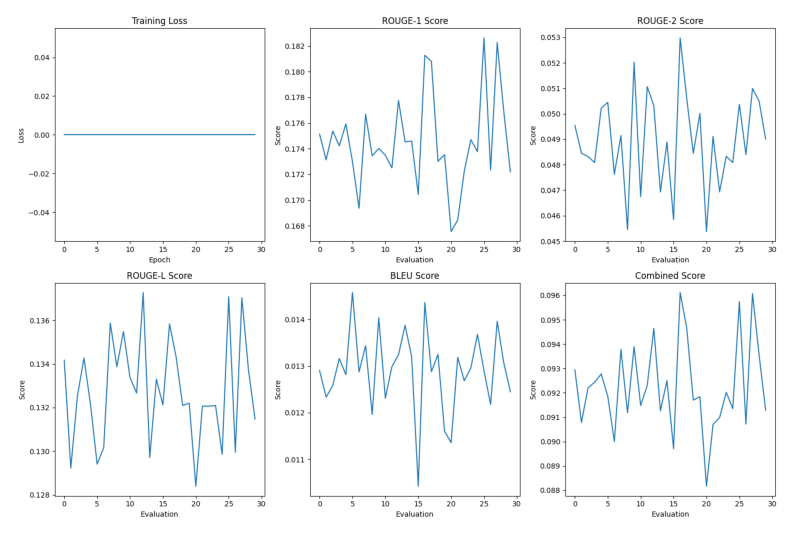

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



=== Test Questions ===


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Question: What is machine learning?
Generated Answer: answer: What is machine learning? Answer: Machine learning is a subset of artificial intelligence that enables systems to learn from data and make decisions or predictions without being explicitly programmed. Answer: Machine learning is a subset of artificial intelligence that enables systems to learn from data and make decisions or predictions without being explicitly programmed. Answer: Machine learning is a subset of artificial intelligence
----------------------------


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Question: How does a neural network work?
Generated Answer: answer: How does a neural network work? Answer: A neural network is a computational model inspired by the structure and function of the human brain. It consists of layers of interconnected nodes, called neurons, which process and transmit information. Each neuron receives input from other neurons or external sources, applies a weight to each input, sums the weighted inputs, and passes the sum
----------------------------
Question: Explain the concept of reinforcement learning.
Generated Answer: answer: Explain the concept of reinforcement learning. Answer: Reinforcement learning is a type of machine learning where an agent learns to make decisions by performing actions in an environment. The agent receives feedback in the form of rewards or penalties for its actions, and the goal is to maximize the cumulative reward over time.
</think>

Reinforcement learning (RL) is a type
----------------------------


In [4]:
def main():
    # Define the data file path (update this with your actual file path)
    file_path = "/kaggle/input/comprehensive-medical-q-a-dataset/train.csv"  # Replace with your actual CSV path
    
    # Load and preprocess data
    X_train, X_test, y_train, y_test = load_and_preprocess_data(file_path, sample_size=300)
    
    print(f"Training on {len(X_train)} examples, testing on {len(X_test)} examples")
    
    # Initialize the model
    model = AutoModelForCausalLM.from_pretrained(model_name)
    
    # Create trainer
    trainer = QAGRPOTrainer(
        model=model,
        tokenizer=tokenizer,
        train_questions=X_train,
        train_answers=y_train,
        test_questions=X_test,
        test_answers=y_test,
        max_length=128,
        max_new_tokens=64
    )
    
    # Train model
    print("Training model with GRPO...")
    trainer.train(epochs=30, eval_freq=1)
    
    # Plot learning curves
    trainer.plot_learning_curves()
    
    # Final evaluation
    print("\n=== Final Model Evaluation ===")
    metrics = trainer.evaluate()


    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread('learning_curves_seq2seq_grpo.png')
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')  
    plt.show()
    
    
    # Test with example questions
    test_questions = [
        "What is machine learning?",
        "How does a neural network work?",
        "Explain the concept of reinforcement learning."
    ]
    
    print("\n=== Test Questions ===")
    for question in test_questions:
        answer = trainer.generate_answer(question)
        print(f"Question: {question}")
        print(f"Generated Answer: {answer}")
        print("----------------------------")

if __name__ == "__main__":
    main()
    